# Modules

In [60]:
# Required packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import pyDOE as doe
import sklearn.gaussian_process.kernels as skl
import pymc3 as pm
import theano.tensor as tt
import theano
import time
import seaborn as sns
from tqdm import tqdm
#import sys
from joblib import Parallel, delayed
import multiprocessing
#import psutil
import os
import shutil
import copy
from matplotlib import gridspec
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

import pickle as pkl
import tensorflow as tf
import tensorflow_probability as tfp
#from scipy.optimize import minimize
#from scipy.optimize import fmin

# Function defs. - Utilities

In [250]:
##### Run this block before any simulation or LDM code #####
def input_locations(d_input, n_input, lims, criterion = "c"): 
    """Simulation inputs generator
    
    The function generates inputs for model/observations according to latin hypercube design or uniform design
    within given range and dimension of inputs
    
    Args:
        d_input: The dimension of inputs to be generated
        n_input: The number of inputs
        lims: Ndarray with the range of inputs for each variable , each row is limits for each var
        criterion: "m", "c" for lating hypercube, "uniform" for uniform design
        
    Returns:
        inputs: n_input * d_input Ndarray with generated input points.
    """
    if criterion == "uniform":
        inputs = []
        for i in range(d_input):
            inputs = inputs + [np.linspace(lims[i, 0], lims[i, 1], int(n_input ** (1 / d_input)))]
            
        grid_list = np.meshgrid(*inputs)
        
        inputs = np.zeros((n_input, d_input))
        for i in range(d_input):
            inputs[:,i] = grid_list[i].flatten()        
        
    else:
        # Data generation
        inputs = doe.lhs(d_input, samples = n_input, criterion = criterion)

        # Transformation for the interval
        for i in range(d_input):
            inputs[:,i] = inputs[:,i] * (lims[i,1] - lims[i, 0]) + lims[i, 0]

    return inputs

def gp_mean_cov(input_obs, input_m, d_input, theta, kernels, means):
    """The function generates the mean and convariance function of the prior GP that is 
    to be used for triaining data generation of observations Y and model evaluations Z according to
    Kennedy & O'Hagan (2001) framework to calibration.
    
    Args:
        input_obs: Ndarray with observation inputs.
        input_m: Ndarray with model inputs.
        d_input: The dimension of model inputs.
        theta: True value of calibration parameter
        kernels: A dictionary containing 3 items: f, delta, and noise kernels
        means: A dictionary containing 2 items: f, delta
                
    Returns:
        M: Mean vector of MVN distribution
        K: Covariance matrix of MVN distribution
    """
    
    ##### Covariance part
    # Kernel input
    theta_stack = np.repeat(theta, len(input_obs))
    theta_stack = theta_stack.reshape((len(input_obs), input_m.shape[1] - d_input), order='F')
    kernel_input = np.concatenate((np.concatenate([input_obs, theta_stack], axis = 1), input_m), axis = 0)
    
    # Base kernel without noise for the model GP
    kernel_base = kernels["f"]
    K_base = kernel_base(kernel_input)
    
    # Model discrepancy kernel
    if kernels["delta"] != 0:
        
        zeros = np.zeros((input_m.shape[0], input_obs.shape[1]))
        delta_input = np.concatenate([input_obs, zeros])
        K_delta = kernels["delta"](delta_input)
        # Need to set the non-obs parts of the kernel to be zero
        K_delta[:, input_obs.shape[0]:] = 0
        K_delta[input_obs.shape[0]:, :] = 0
        K_base = K_base + K_delta
        
    # Add noise to the observations
    K = K_base + np.diag([kernels["sigma"] ** 2] * input_obs.shape[0] + [0] * input_m.shape[0])
    
    ##### Means part

    # Obs mean
    obs_mean = np.array([])
    input_obs_theta = np.concatenate([input_obs, theta_stack], axis = 1)
    for elem in input_obs_theta:
        # First input to mean is x, second input is theta
        obs_mean = np.append(obs_mean, means["f"](elem[:d_input], elem[d_input:]) + means["delta"](elem[:d_input]))
    
    # Model mean
    m_mean = np.array([])
    for elem in input_m:
        # First input to mean is x, second input is theta
        m_mean = np.append(m_mean, means["f"](elem[:d_input], elem[d_input:]))

    M = np.concatenate((obs_mean, m_mean))
    
    return M, K

def gp_mean_cov_pred(input_obs, input_m, d_input, theta, kernels, means):
    """The function generates the mean and convariance function of the prior GP that is 
    to be used for testing data generation of observations Y and model evaluations Z according to
    Kennedy & O'Hagan (2001) framework to calibration.
    
    Args:
        input_obs: Ndarray with observation inputs.
        input_m: Ndarray with model inputs. - this is an artefact, only used to derive dim
        d_input: The dimension of model inputs.
        theta: True value of calibration parameter
        kernels: A dictionary containing 3 items: f, delta, and noise kernels
        means: A dictionary containing 2 items: f, delta
                
    Returns:
        M: Mean vector of MVN distribution
        K: Covariance matrix of MVN distribution
    """
    
    ##### Covariance part
    # Kernel input
    theta_stack = np.repeat(theta, len(input_obs))
    theta_stack = theta_stack.reshape((len(input_obs), input_m.shape[1] - d_input), order='F')
    kernel_input = np.concatenate([input_obs, theta_stack], axis = 1)
    
    # Base kernel without noise for the model GP
    kernel_base = kernels["f"]
    K_base = kernel_base(kernel_input)
    
    # Model discrepancy kernel
    if kernels["delta"] != 0:
        delta_input = input_obs
        K_delta = kernels["delta"](delta_input)
        K_base = K_base + K_delta
        
    # Add noise to the observations
    K = K_base + np.diag([kernels["sigma"] ** 2] * input_obs.shape[0])
    
    ##### Means part
    obs_mean = np.array([])
    input_obs_theta = np.concatenate([input_obs, theta_stack], axis = 1)
    for elem in input_obs_theta:
        obs_mean = np.append(obs_mean, means["f"](elem[:d_input], elem[d_input:]) + means["delta"](elem[:d_input]))  
    M = obs_mean
    
    return M, K

def bijection_array(k, n, l): 
    """Calculates bijection of k in range 1,..., l * (2 * n - (l + 1)) / 2 
    mapped onto (i,j) where i in 1,..., n-j and j in 1,...,l
    
    Args:
        k: input
        n: number of observations
        l: truncation level of a vine
    
    Returns:
        i: index i
        j: index j
    """
        
    bijection_domain = int(round(l * (2 * n - (l + 1)) / 2))

    j = 0
    int_high_prev = 0
    int_high = 0
    while k > int_high:
        j = j + 1
        int_high_prev = int_high
        int_high = int_high + n - j

    i = k - int_high_prev
    
    return i, j

def partial_corr(i_low, i_hig, cond_list, data_input, kernels_input, corr_dict): 
    """Function calculates partial correlation rho_{i_low, i_hig: cond_list}
    based on the recursive formula. Here we assume i_low < i_hig and cond_list is
    ordered.
    
    Note:
    This is a utility function for the master functions defined below
    
    Args:
        i_low: First of the conditioned variables for partial correlation
        i_hig: Second of the conditioned variables for partial correlation
        cond_list: An ordered list of conditioning variables
        data_input: A dictionary containing 3 items: Response, X, theta for each of data points
        kernels_input: A dictionary containing 3 items: f, delta, and noise kernels
        corr_dict: a dictionary that is to be filled with calculated partial correlation
        
        NOTE: the entries in corr_dict have the following keys (strings) 
                i_low,i_high:cond_list[0],cond_list[-1] for conditioning list of size at leas 2
                i_low,i_high:cond_list[-1] for conditioning list of size 1
                i_low,i_high for conditioning list of size 0
    Returns:
        rho: Calculated partial correlation
        corr_dict: Updated correlation dictionary
    
    """
    
    if len(cond_list) > 0:
        
        corr_id = str(int(i_low)) + "," + str(int(i_hig)) + ":"
        if len(cond_list) > 1:
            corr_id = corr_id + str(int(cond_list[0])) + "," + str(int(cond_list[-1]))
        else:
            corr_id = corr_id + str(int(cond_list[0]))
            
        if corr_id not in corr_dict: 
            v = cond_list[-1]
            cond_list = cond_list[:-1]

            rho_i_j, corr_dict = partial_corr(i_low, i_hig, cond_list, data_input, kernels_input, corr_dict)

            rho_i_v, corr_dict = partial_corr(int(min(i_low,v)) , int(max(i_low,v)), cond_list,
                                                data_input, kernels_input, corr_dict)

            rho_v_j, corr_dict = partial_corr(int(min(i_hig,v)) , int(max(i_hig,v)), cond_list,
                                                data_input, kernels_input, corr_dict)

            rho = (rho_i_j - rho_i_v * rho_v_j) / np.sqrt((1 - rho_i_v ** 2) * (1 - rho_v_j ** 2))
            corr_dict[corr_id] = rho
        else:
            rho = corr_dict[corr_id]    
        
        
    else:
        corr_id = str(int(i_low)) + "," + str(int(i_hig))
        if corr_id not in corr_dict: 
                # All the neccessary inputs
            i_low_type = data_input["Response"][i_low - 1,:][1]
            i_hig_type = data_input["Response"][i_hig - 1,:][1]

            i_low_x = data_input["X"][i_low - 1,1:] 
            i_hig_x = data_input["X"][i_hig - 1,1:] 

            i_low_x_theta = np.concatenate((i_low_x, data_input["Theta"][i_low - 1,1:]))
            i_hig_x_theta = np.concatenate((i_hig_x, data_input["Theta"][i_hig - 1,1:]))

            # Here we need to distinguis between cases

            if (i_low_type == 1) & (i_hig_type == 0):
                # low is exp
                # high is model   

                #variances
                var_low = kernels_input["sigma"] ** 2
                if kernels_input["f"] != 0:
                    var_low = var_low + float(kernels_input["f"]([i_low_x_theta])) 
                    
                if kernels_input["delta"] != 0:
                    var_low = var_low + float(kernels_input["delta"]([i_low_x]))
                var_hig = float(kernels_input["f"]([i_hig_x_theta]))

                #correlation
                cov = float(kernels_input["f"](np.array([i_low_x_theta, i_hig_x_theta]))[0,1])
                rho = cov / (np.sqrt(var_hig * var_low))

            elif (i_low_type == 0) & (i_hig_type == 1):
                # low is model
                # hig is exp

                var_hig = float(kernels_input["f"]([i_hig_x_theta])) + kernels_input["sigma"] ** 2
                if kernels_input["delta"] != 0:
                    var_hig = var_hig + float(kernels_input["delta"]([i_hig_x]))
                var_low = float(kernels_input["f"]([i_low_x_theta]))

                #correlation
                cov = float(kernels_input["f"](np.array([i_low_x_theta, i_hig_x_theta]))[0,1])
                rho = cov / (np.sqrt(var_hig * var_low))

            elif (i_low_type == 0) & (i_hig_type == 0):
                # low is model
                # hig is model

                var_low = float(kernels_input["f"]([i_low_x_theta]))
                var_hig = float(kernels_input["f"]([i_hig_x_theta]))

                #correlation
                cov = float(kernels_input["f"](np.array([i_low_x_theta, i_hig_x_theta]))[0,1])
                rho = cov / (np.sqrt(var_hig * var_low))

            elif (i_low_type == 1) & (i_hig_type == 1):
                # low is exp
                # hig is exp

                #variances and covariances
                var_low = kernels_input["sigma"] ** 2
                var_hig = kernels_input["sigma"] ** 2
                cov = 0
                if kernels_input["f"] != 0:
                    var_low = float(kernels_input["f"]([i_low_x_theta])) + var_low
                    var_hig = float(kernels_input["f"]([i_hig_x_theta])) + var_hig
                    cov = float(kernels_input["f"](np.array([i_low_x_theta, i_hig_x_theta]))[0,1])
                if kernels_input["delta"] != 0:
                    var_low = var_low + float(kernels_input["delta"]([i_low_x]))
                    var_hig = var_hig + float(kernels_input["delta"]([i_hig_x]))
                    cov = float(cov + kernels_input["delta"](np.array([i_low_x, i_hig_x]))[0,1])

                rho = cov / (np.sqrt(var_hig * var_low))

            corr_dict[corr_id] = rho
        else:
            rho = corr_dict[corr_id]
    return rho, corr_dict


def partial_corr_c_master(i, j, data_input, kernels_input):
    """Function calculates partial correlation for the C-vine case.
    
    NOTE: This function is slightly redundant, I am not sure if I will actually need to use it
    
    Args:
        i: Index i from the bijection
        j: Index j from the bijection
        data_input: A dictionary containing 3 items: Response, X, theta for each of data points
        kernels_input: A dictionary containing 3 items: f, delta, and noise kernels
        
    Returns:
        rho: Calculated partial correlation for a Gaussian C-Vine to be calucalted
        corr_dict: A dictionary with all the partial correlations obrained through the recursion.
        
    NOTE: See partial_corr function for beter description of corr_dict
    """
    
    cond_list = [i + 1 for i in range(j - 1)]
    corr_dict = {}
    i_low = j
    i_hig = j + i
    
    rho, corr_dict = partial_corr(i_low, i_hig, cond_list, data_input, kernels_input, corr_dict)
    return rho, corr_dict

def partial_corr_d_master(i, j, data_input, kernels_input): 
    """Function calculates partial correlation for the D-vine case.
    
    NOTE: This function is slightly redundant, I am not sure if I will actually need to use it
    
    Args:
        i: Index i from the bijection
        j: Index j from the bijection
        data_input: A dictionary containing 3 items: Response, X, theta for each of data points
        kernels_input: A dictionary containing 3 items: f, delta, and noise kernels
        
    Returns:
        rho: Calculated partial correlation for a Gaussian D-Vine to be calucalted
        corr_dict: A dictionary with all the partial correlations obrained through the recursion.
        
    NOTE: See partial_corr function for beter description of corr_dict
    
    """
    
    cond_list = [i for i in range(i + 1 ,i + j)]
    corr_dict = {}
    i_low = i
    i_hig = j + i

    rho, corr_dict = partial_corr(i_low, i_hig, cond_list, data_input, kernels_input, corr_dict)
    return rho, corr_dict

def bivariate_gauss_copula(i, j, data_input, kernels_input, means_input, vine_type = "C"): 
    """Evaluates bivariate gaussian copula density for given values of i,j and vine copula type.
    
    Args:
        i: Output from bijection that uniquely identifies first datapoint
        j: Output from bijection that uniquely identifies second datapoint
        data_input: A dictionary containing 3 items: Response, X, theta for each of data points
        kernels_input: A dictionary containing 3 items: f, delta, and noise kernels
        means_input: A dictionary containing 2 items: f, delta
        vine_type: "C" or "D" depending on which wine copule we want to consider
        
    Returns:
        copula_density_eval: Evaluated bivariate gaussian copula    
    """
    
    # Calculating the corr_dict
    if vine_type == "C":
        cond_list = [i + 1 for i in range(j - 1)]
        i_low = j
        i_hig = j + i
        rho, corr_dict = partial_corr_c_master(i, j, data_input, kernels_input)
    elif vine_type == "D":
        cond_list = [i for i in range(i + 1 ,i + j)]
        i_low = i
        i_hig = j + i
        rho, corr_dict = partial_corr_d_master(i, j, data_input, kernels_input)
        
    # Based on a truncation level, what is the size of conditioning set?
    if len(cond_list) > 0:

        v = cond_list[-1]
        cond_list_h = cond_list[:-1]

        F_low = h_function(i_low, v, cond_list_h, data_input, kernels_input, means_input, corr_dict)
        F_hig = h_function(i_hig, v, cond_list_h, data_input, kernels_input, means_input, corr_dict)

        corr_low = min(i_low, i_hig)
        corr_hig = max(i_low, i_hig)
        
        # conditional indicator
        corr_id = str(int(corr_low)) + "," + str(int(corr_hig)) + ":" + str(int(cond_list[0]))
        if len(cond_list) > 1:
             corr_id = corr_id + "," + str(int(v))

        rho = corr_dict[corr_id]

    else:
        Y_low_std, Y_hig_std, var_low, var_hig, i_low_type, i_hig_type = std_transform(i_low, i_hig, data_input, kernels_input, means_input)

        F_low = sp.stats.norm.cdf(Y_low_std)
        F_hig = sp.stats.norm.cdf(Y_hig_std)
 

        corr_low = min(i_low, i_hig)
        corr_hig = max(i_low, i_hig)

        # conditional indicator
        corr_id = str(int(corr_low)) + "," + str(int(corr_hig))
        rho = corr_dict[corr_id]

    copula_density_eval = b_gaussian_c_pdf(F_low, F_hig, rho)
    
    return copula_density_eval

def h_function(i_low, i_hig, cond_list, data_input, kernels_input, means_input, corr_dict): #Works for general case
    """Calculates h(u_{i_low}, u_{i_hig}) parameterized by rho_{i_low,i_hig:cond_list} recuresively
    
    NOTE: i_low, i_hig have slightly different meaning that in the case of partial correlation
    because here oreder matters so i_low, i_hig here correspinds to ored of arguments
    
    Args:
        i_low: First argument index for h
        i_hig: Second argument index for h
        cond_list: A list of conditioning variables for h viz rho in description
        data_input: A dictionary containing 3 items: Response, X, theta for each of data points
        kernels_input: A dictionary containing 3 items: f, delta, and noise kernels
        means_input: A dictionary containing 2 items: f, delta
        corr_dict: A dictionary containg all the partial correlations precalculated using parial_corr fcn
        
    Returns:
        h: Calculated value of h function
    """
    
    if len(cond_list) > 0:

        v = cond_list[-1]
        cond_list_h = cond_list[:-1]
        
        F_low = h_function(i_low, v, cond_list_h, data_input, kernels_input, means_input, corr_dict)
        F_hig = h_function(i_hig, v, cond_list_h, data_input, kernels_input, means_input, corr_dict)
        
        corr_low = min(i_low, i_hig)
        corr_hig = max(i_low, i_hig)
        
        # conditional indicator 
        corr_id = str(int(corr_low)) + "," + str(int(corr_hig)) + ":" + str(int(cond_list[0]))
        if len(cond_list) > 1:
            corr_id = corr_id + "," + str(int(v))

        rho = corr_dict[corr_id]
        h = sp.stats.norm.cdf((sp.stats.norm.ppf(F_low) - rho * sp.stats.norm.ppf(F_hig)) / np.sqrt(1 - rho ** 2))
             
    else:
            
        Y_low_std, Y_hig_std, var_low, var_hig, i_low_type, i_hig_type = std_transform(i_low, i_hig, data_input, kernels_input, means_input)

        corr_low = min(i_low, i_hig)
        corr_hig = max(i_low, i_hig)

        
        rho = corr_dict[str(int(corr_low)) + "," + str(int(corr_hig))]
        h = sp.stats.norm.cdf((Y_low_std - rho * Y_hig_std) / np.sqrt(1 - rho ** 2))
        
    return h

def vine_p(i, j, l, n, data_input, kernels_input, means_input, vine_type = "C"):
    """Function calculates the p (as defined in Kejzlar and Maiti (2020))
    function based on the vine copula with given truncation
    
    Note:
    - this is the "p" for the Algorithm 1 and for Algorithm 1 + Control Variates 
    - p under Rao-Blackwellization defined below
    - this is version without Rao-Blackwellization
    
    Args:
        i: Index i from the bijection
        j: Index j from the bijection
        l: Truncation level
        n: Sample size
        data_input: A dictionary containing 3 items: Response, X, theta for each of data points
        kernels_input: A dictionary containing 3 items: f, delta, and noise kernels
        means_input: A dictionary containing 2 items: f, delta
        vine_type: "C" or "D" depending on which wine copule we want to consider
        
    Returns:
        p_eval: evaluated p_function
    """
    
    
    if vine_type == "D":
        if j > l: # This conditional is unnecesary since it is taken care of by the bijeciton function
            c_i_j = 1.0
        else:
            c_i_j = bivariate_gauss_copula(i, j, data_input, kernels_input, means_input, vine_type = "D")

        # definition of a_i multiplicatior
        a = 2 * l
        if i <= l:
            a = a - (l + 1 - i)
        if i > (n - l):
            a = a - (l - n + i)

        # definition of b_{i+j} multiplicator
        b = 2 * l
        if (i + j) <= l:
            b = b - (l + 1 - j - i)
        if (i + j) > (n - l):
            b = b - (l - n + j + i)

        # Standardized data
        Y_low_std, Y_hig_std, var_low, var_hig, i_low_type, i_hig_type  = std_transform(i, j + i, data_input, kernels_input, means_input)
    else:
        if j > l: # See above
            c_i_j = 1.0
        else:
            c_i_j = bivariate_gauss_copula(i, j, data_input, kernels_input, means_input, vine_type = "C")

        # definition of a_i multiplier 
        a = n - 1

        # definition of b_{j+i}
        b = l
        if (j + i) <= l:
            b = b + (n - 1 - l)
        
        
        # Standardized data
        Y_low_std, Y_hig_std, var_low, var_hig, i_low_type, i_hig_type = std_transform(j, j + i, data_input, kernels_input, means_input)
        
    a = float(a)
    b = float(b)
    
    p_eval = np.log(c_i_j) + (1 / a) * np.log(sp.stats.norm.pdf(Y_low_std)) + (1 / b) * np.log(sp.stats.norm.pdf(Y_hig_std))

    return p_eval

def data_type(i_low, i_hig, data_input):
    """Function extracts the type of data indexed by i_low and i_hig
    
     Args:
        i_low: First argument index
        i_hig: Second argument index
        data_input: A dictionary containing 3 items: Response, X, theta for each of data points
               
    Returns:
        i_low_type: 1 for y, 0 for z
        i_hig_type: 1 for y, 0 for z
    """
    
    i_low_type = data_input["Response"][i_low - 1,:][1]
    i_hig_type = data_input["Response"][i_hig - 1,:][1]
    
    return i_low_type, i_hig_type

def std_transform(i_low, i_hig, data_input, kernels_input, means_input): 
    """Standardize the data points according to the GP specification.
    
    Args:
        i_low: First argument index
        i_hig: Second argument index
        data_input: A dictionary containing 3 items: Response, X, theta for each of data points
        kernels_input: A dictionary containing 3 items: f, delta, and noise kernels
        means_input: A dictionary containing 2 items: f, delta
            
    Returns:
        Y_low_std: Standardized value with index i_low
        Y_hig_std: Standardized value with index i_hig 
        var_low: Variance of data point with index i_low
        var_hig: Variance of data point with index i_hig
        i_low_type: 1 for y, 0 for z
        i_hig_type: 1 for y, 0 for z
    """
    
    i_low_type = data_input["Response"][i_low - 1,:][1]
    i_hig_type = data_input["Response"][i_hig - 1,:][1]

    i_low_x = data_input["X"][i_low - 1,1:] 
    i_hig_x = data_input["X"][i_hig - 1,1:]

    i_low_y = data_input["Response"][i_low - 1,2]
    i_hig_y = data_input["Response"][i_hig - 1,2]

    i_low_theta = data_input["Theta"][i_low - 1,1:]
    i_hig_theta = data_input["Theta"][i_hig - 1,1:]

    # The basic simulation considers kernels without theta in them!
    i_low_x_theta = np.concatenate((i_low_x, data_input["Theta"][i_low - 1,1:]))
    i_hig_x_theta = np.concatenate((i_hig_x, data_input["Theta"][i_hig - 1,1:]))

        # Uniform inputs calculation

    if i_low_type == 1:
            # low is exp      
            # Varince
        var_low = kernels_input["sigma"] ** 2
        if kernels_input["f"] != 0:
            var_low = var_low + float(kernels_input["f"]([i_low_x_theta]))
        if kernels_input["delta"] != 0:
              var_low = float(var_low + float(kernels_input["delta"]([i_low_x])))
            # Mean
        mean_low = float(means_input["f"](i_low_x, i_low_theta) + means_input["delta"](i_low_x))

    elif i_low_type == 0:
            # low is model      
            # Variance
        var_low = float(kernels_input["f"]([i_low_x_theta]))
            # Mean
        mean_low = float(means_input["f"](i_low_x, i_low_theta))

    if i_hig_type == 1:
            # hig is exp     
            # Varince
        var_hig = kernels_input["sigma"] ** 2
        if kernels_input["f"] != 0:
            var_hig = float(kernels_input["f"]([i_hig_x_theta])) + var_hig
        if kernels_input["delta"] != 0:
            var_hig = float(var_hig + float(kernels_input["delta"]([i_hig_x])))
            # Mean
        mean_hig = float(means_input["f"](i_hig_x, i_hig_theta) + means_input["delta"](i_hig_x))

    elif i_hig_type == 0:
            # low is model    
            # Variance
        var_hig = float(kernels_input["f"]([i_hig_x_theta]))
            # Mean
        mean_hig = float(means_input["f"](i_hig_x, i_hig_theta))
        
        # USE logarith for stability
    Y_low_std = np.sign(i_low_y - mean_low) * np.exp(np.log(np.abs(i_low_y - mean_low)) - np.log(var_low) / 2)
    Y_hig_std = np.sign(i_hig_y - mean_hig) * np.exp(np.log(np.abs(i_hig_y - mean_hig)) - np.log(var_hig) / 2)
        
    return Y_low_std, Y_hig_std, var_low, var_hig, i_low_type, i_hig_type

def b_gaussian_c_pdf(u1, u2, rho):
    """Calculates the actual bivariate gaussian copula density.
    
    Args:
        u1: The value of cdf for first arg
        u2: the value of cdf for second arg
        
    Returns:
        density: Evaluated bivariate gaussian copula density    
    """
    w1 = sp.stats.norm.ppf(u1)
    w2 = sp.stats.norm.ppf(u2)
    
    density = (1 / np.sqrt(1 - rho ** 2)) * np.exp(- ((rho ** 2) * (w1 ** 2 + w2 ** 2) - 2 * rho * w1 * w2) / (2 * (1 - rho ** 2)))
    return density

##### Distribution family classes that are used as 1) Variational fmailies, 2) Overdispersed familiees, 3) Priors
# Each class contains the following methods:
#
# __init__(self, param, init)
#
# sample(self, n_size)
#
# log_pdf(self, theta)
#
# log_grad_pdf(self, theta)

class gaussian_mean_field_family:
    """Class for a mean field gaussian family of arbitrary dimension"""
    
    def __init__(self, param, dim):
        """The parameters for the Gaussian mean field family are passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["mu"] is a 1-dim Ndarray with the means of independent Gaussian distributions
                 - param["sigma"] is a 1-dim Ndarray with the np.log(SDs) of independent Gaussian distributions
            dim: dimension of the family
        """
        
        self.mu = param["mu"]
        self.sigma = param["sigma"]
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gaussian mean_field variational family
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            sample[:, i] = np.random.normal(loc = self.mu[i], scale = self.sigma[i], size = n_size)     
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gaussian family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            density = sp.stats.norm(loc = self.mu[i], scale = self.sigma[i])
            log_dens = log_dens + np.log(density.pdf(theta[i]))       
        return log_dens
    
    def grad_log_pdf(self, theta):
        """Calculates the value of score function at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log gradient will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(2 * dim) where gradient[:dim] are the values of score function
                    w.r.t mu and gradient[dim:] are the values of score function w.r.t sigma
        """
        
        gradient = np.zeros(self.dim * 2)
        for i in range(self.dim):
            # score function w.r.t. mean
            gradient[i] = (theta[i] - self.mu[i]) / (self.sigma[i] ** 2)
            # score function w.r.t. SD
            gradient[i + self.dim] = - 1 / self.sigma[i] + ((theta[i] - self.mu[i]) ** 2) / (self.sigma[i] ** 3)
        return gradient
    
class gamma_mean_field_family:
    """Class for a mean field gamma family of arbitrary dimension with np.log(param) parametrization
      
      Gamma parametrization:
          
          f(x|alpha, beta) = \frac{beta ^ alpha}{Gamma(alpha)} * x ^{alpha - 1} * \exp{- beta * x}
          
          E(X) = alpha / beta
          Var(X) = alpha / (beta^2)
          
    """
    
    def __init__(self, param, dim):
        """The parameters for the gamma mean field family are passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["alpha"] is a 1-dim Ndarray with the np.log(alpha) parameters of independent Gamma distributions
                 - param["beta"] is a 1-dim Ndarray with the np.log(beta) parameters of independent Gamma distributions
            dim: Dimension of the family
        """
        
        self.alpha = param["alpha"]
        self.beta = param["beta"]
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gamma mean field variational family
        
        Note: np.random.gamma has parametrization with shape = alpha, scale = 1 / beta
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            sample[:, i] = np.random.gamma(shape = self.alpha[i], scale = self.beta[i], size = n_size)
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gamma family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            log_dens = log_dens + (self.alpha[i] - 1) * np.log(theta[i]) - theta[i] / self.beta[i] - self.alpha[i] * np.log(self.beta[i]) - np.log(sp.special.gamma(self.alpha[i]))
    
        return log_dens
    
    def grad_log_pdf(self, theta):
        """Calculates the value of score function at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log gradient will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(2 * dim) where gradient[:dim] are the values of score function
                    w.r.t alpha and gradient[dim:] are the values of score function w.r.t beta
        """
        
        gradient = np.zeros(self.dim * 2)
        for i in range(self.dim):    
            # score function w.r.t. alpha
            gradient[i] = np.log(theta[i]) - np.log(self.beta[i]) - sp.special.digamma(self.alpha[i])
            # score function w.r.t. beta
            gradient[i + self.dim] = theta[i] / (self.beta[i] ** 2) - self.alpha[i] / self.beta[i]
        return gradient
    
class gaussian_mean_field_family_lambda_param:
    """Class for a mean field gaussian family of arbitrary dimension with scale parametrization 
    
    lambda = log(exp(sigma) - a)
    
    """
    def __init__(self, param, dim):
        """The parameters for the Gaussian mean field family aare passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["mu"] is a 1-dim Ndarray with the means of independent Gaussian distributions
                 - param["sigma"] is a 1-dim Ndarray with the transformed sd of independent Gaussian distributions
                 - param["a"] see parametrization
            dim: Dimension of the family
        """
        
        self.mu = param["mu"]
        self.sigma = param["sigma"]
        self.a = param["a"]
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gaussian mean_field variational family
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            sd = np.log(np.exp(self.sigma[i]) + self.a)
            sample[:, i] = np.random.normal(loc = self.mu[i], scale = sd, size = n_size)     
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gaussian family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            sd = np.log(np.exp(self.sigma[i]) + self.a)
            density = sp.stats.norm(loc = self.mu[i], scale = sd)
            log_dens = log_dens + np.log(density.pdf(theta[i]))       
        return log_dens
    
    def grad_log_pdf(self, theta):
        """Calculates the value of score function at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log gradient will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(2 * dim) where gradient[:dim] are the values of score function
                    w.r.t mu and gradient[dim:] are the values of score function w.r.t sigma
        """
        
        gradient = np.zeros(self.dim * 2)
        for i in range(self.dim):
            # score function w.r.t. mean
            gradient[i] = - (self.mu[i] - theta[i]) / (np.log(np.exp(self.sigma[i]) + self.a) ** 2)
            # score function w.r.t. lambda
            gradient[i + self.dim] = np.exp(self.sigma[i]) * (- 1 / (np.log(self.a + np.exp(self.sigma[i])) * (self.a + np.exp(self.sigma[i]))) + \
                                                             ((self.mu[i] - theta[i]) ** 2) / ((self.a + np.exp(self.sigma[i])) * np.log(self.a + np.exp(self.sigma[i])) ** 3))
        return gradient

    
class gamma_mean_field_family_lambda_param:
    """Class for a mean field gamma family of arbitrary, parametrized with mean and standard deviation
    
    
    lambda_alfa = log(exp(alfa) - a)
    lambda_beta = log(exp(alfa) - a)
    
    where alpha corresponds to the mean of the gamma distribution and beta corresponds to the std of the gamma dist
      
      Gamma parametrization:
          
          f(x|alpha, beta) = \frac{beta ^ alpha}{Gamma(alpha)} * x ^{alpha - 1} * \exp{- beta * x}
          
          E(X) = alpha / beta
          Var(X) = alpha / (beta^2)
          
    """
    
    def __init__(self, param, dim):
        """The parameters for the gamma mean field family are passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["alpha"] is a 1-dim Ndarray with the mean paramteres of the independent Gamma distribution
                 - param["beta"] is a 1-dim Ndarray with the stds of independent Gamma distributions
                 - param["a"] see parametrization
            dim: Dimension of the family
        """
        
        self.alpha = param["alpha"]
        self.beta = param["beta"]
        self.a = param["a"]
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gamma mean field variational family
        
        Note: np.random.gamma has parametrization with shape = alpha, scale = 1 / beta
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            mu = np.log(np.exp(self.alpha[i]) + self.a)
            sigma = np.log(np.exp(self.beta[i]) + self.a)
            alpha = float(mu/sigma) ** 2
            beta = float(mu/ (sigma**2))
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            samples = tfdGamma.sample(n_size)
            sample[:, i] = samples.numpy()
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gamma family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            
            mu = np.log(np.exp(self.alpha[i]) + self.a)
            sigma = np.log(np.exp(self.beta[i]) + self.a)
            alpha = float(mu/sigma) ** 2
            beta = float(mu/ (sigma**2))
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            log_dens = log_dens + float(tfdGamma.log_prob(theta[i]))
        return log_dens
    
    def grad_log_pdf(self, theta):
        """Calculates the value of score function at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log gradient will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(2 * dim) where gradient[:dim] are the values of score function
                    w.r.t alpha and gradient[dim:] are the values of score function w.r.t beta
        """
        
        gradient = np.zeros(self.dim * 2)
        for i in range(self.dim):    
            l_m = self.alpha[i]
            l_s = self.beta[i]
            # score function w.r.t. lambda_alpha
            g1m = (np.log(self.a + np.exp(l_s)) ** 2) * (self.a + np.exp(l_m))
            g2m = np.log(self.a + np.exp(l_m))
            gradient[i] = (np.exp(l_m) * g2m - theta[i] * np.exp(l_m) - 2 * np.exp(l_m) * sp.special.digamma((g2m / np.log(self.a + np.exp(l_s))) ** 2) + \
                          2 * np.exp(l_m) * np.log(theta[i]) * g2m + 2 * np.log(g2m / (np.log(self.a + np.exp(l_s)) ** 2)) * np.exp(l_m) * g2m) / g1m
            
            # score function w.r.t. lambda_beta
            g1l = (np.log(self.a + np.exp(l_s)) ** 3) * (self.a + np.exp(l_s))
            g2l = np.log(self.a + np.exp(l_m)) ** 2
            gradient[i + self.dim] = (2 * np.exp(l_s) * sp.special.digamma(g2l / (np.log(self.a + np.exp(l_s)) ** 2)) * g2l - \
                                     2 * np.log(np.log(self.a + np.exp(l_m)) / (np.log(self.a + np.exp(l_s)) ** 2)) * np.exp(l_s) * g2l -\
                                     2 * np.exp(l_s) * g2l - 2 * np.exp(l_s) * np.log(theta[i]) * g2l + 2 * theta[i] * np.exp(l_s) * np.log(self.a + np.exp(l_m))) / g1l
        return gradient
    

class gamma_mean_field_family_ms:
    """Class for a mean field gamma family of arbitrary, parametrized with mean and standard deviation
    
    Directly parametrized no transformation here
      
      Gamma parametrization:
          
          f(x|alpha, beta) = \frac{beta ^ alpha}{Gamma(alpha)} * x ^{alpha - 1} * \exp{- beta * x}
          
          E(X) = alpha / beta
          Var(X) = alpha / (beta^2)
          
    """
    
    def __init__(self, param, dim):
        """The parameters for the gamma mean field family are passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["alpha"] is a 1-dim Ndarray with the np.log(alpha) parameters of independent Gamma distributions
                 - param["beta"] is a 1-dim Ndarray with the np.log(beta) parameters of independent Gamma distributions
                 - param["a"] see parametrization
            dim: Dimension of the family
        """
        
        self.alpha = param["alpha"]
        self.beta = param["beta"]
        self.a = param["a"]
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gamma mean field variational family
        
        Note: np.random.gamma has parametrization with shape = alpha, scale = 1 / beta
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            mu = self.alpha[i]
            sigma = self.beta[i]
            alpha = float(mu/sigma) ** 2
            beta = float(mu/ (sigma**2))
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            samples = tfdGamma.sample(n_size)
            sample[:, i] = samples.numpy()
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gamma family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            
            mu = self.alpha[i]
            sigma = self.beta[i]
            alpha = float(mu/sigma) ** 2
            beta = float(mu/ (sigma**2))
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            log_dens = log_dens + float(tfdGamma.log_prob(theta[i]))
        return log_dens
    
    def grad_log_pdf(self, theta):
        """Calculates the value of score function at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(2 * dim) where gradient[:dim] are the values of score function
                    w.r.t alpha and gradient[dim:] are the values of score function w.r.t beta
        """
        
        gradient = np.zeros(self.dim * 2)
        for i in range(self.dim):    
            # score function w.r.t. np.log(alpha)
            l_m = self.alpha[i]
            l_s = self.beta[i]
            
            gradient[i] = (l_m - theta[i] + 2 * l_m * np.log(theta[i]) + 2 * l_m * np.log(l_m / (l_s ** 2)) - 2 * l_m * sp.special.digamma((l_m/l_s) ** 2)) / (l_s ** 2)
    
            gradient[i + self.dim] = 2 * (l_m * theta[i] - l_m ** 2 + sp.special.digamma((l_m/l_s)** 2) * l_m ** 2 - np.log(theta[i]) * l_m ** 2 - np.log(l_m / (l_s ** 2)) * l_m **2) / (l_s ** 3)
        return gradient
    
class gamma_mean_field_family_ms_overdisp:
    """Class for a mean field gamma family of arbitrary, parametrized with mean and standard deviation
    directly
      
      Gamma parametrization:
          
          f(x|alpha, beta) = \frac{beta ^ alpha}{Gamma(alpha)} * x ^{alpha - 1} * \exp{- beta * x}
          
          E(X) = alpha / beta
          Var(X) = alpha / (beta^2)
          
    """
    
    def __init__(self, param, dim, tau):
        """The parameters for the gamma mean field family are passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["alpha"] is a 1-dim Ndarray with the np.log(alpha) parameters of independent Gamma distributions
                 - param["beta"] is a 1-dim Ndarray with the np.log(beta) parameters of independent Gamma distributions
                 - param["a"] see parametrization
            dim: Dimension of the family
            tau: Dispersion coefficient >= 1
        """
        
        self.alpha = param["alpha"]
        self.beta = param["beta"]
        self.a = param["a"]
        self.tau = tau
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gamma mean field variational family
        
        Note: np.random.gamma has parametrization with shape = alpha, scale = 1 / beta
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            mu = self.alpha[i]
            sigma = self.beta[i]
            alpha = (float(mu/sigma) ** 2 + self.tau[i] - 1) / self.tau[i]
            beta = float(mu/ (sigma**2)) / self.tau[i]
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            samples = tfdGamma.sample(n_size)
            sample[:, i] = samples.numpy()
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gamma family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            
            mu = self.alpha[i]
            sigma = self.beta[i]
            alpha = (float(mu/sigma) ** 2 + self.tau[i] - 1) / self.tau[i]
            beta = float(mu/ (sigma**2)) / self.tau[i]
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            log_dens = log_dens + float(tfdGamma.log_prob(theta[i]))
        return log_dens
    
    def grad_log_pdf_tau(self, theta):
        """Calculate the value of score function at theta w.r.t dispersion coefficient tau
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log gradient will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(dim) with the values of score function
                    w.r.t tau
        """
        gradient = np.zeros(self.dim)
        for i in range(self.dim):    
            mu = self.alpha[i]
            sigma = self.beta[i]
            alpha = float(mu/sigma) ** 2
            beta = float(mu/ (sigma**2))
            
            gradient[i] = (self.tau[i] * np.log(beta / self.tau[i]) - (alpha + self.tau[i] - 1) + beta * theta[i] - \
                          np.log(beta / self.tau[i]) * (alpha + self.tau[i] - 1) + sp.special.digamma((alpha + self.tau[i] - 1) /self.tau[i]) * (alpha - 1) - \
                          np.log(theta[i]) * (alpha - 1)) / self.tau[i]      
        return gradient
   
    
class gaussian_mean_field_family_lambda_param_overdisp:
    """Class for a mean field overdispersed gaussian family of arbitrary dimension with scale parametrization 
    
    lambda = log(exp(sigma) - a)
    
    """
    def __init__(self, param, dim, tau):
        """The parameters for the Gaussian mean field family aare passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["mu"] is a 1-dim Ndarray with the means of independent Gaussian distributions
                 - param["sigma"] is a 1-dim Ndarray with the np.log(SDs) of independent Gaussian distributions
                 - param["a"] see parametrization 
            dim: Dimension of the family
            tau: Dispersion coefficient >= 1
        """
        
        self.mu = param["mu"]
        self.sigma = param["sigma"]
        self.a = param["a"]
        self.tau = tau
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gaussian mean_field variational family
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            sd = np.log(np.exp(self.sigma[i]) + self.a) * np.sqrt(self.tau[i])
            sample[:, i] = np.random.normal(loc = self.mu[i], scale = sd , size = n_size)     
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gaussian family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            sd = np.log(np.exp(self.sigma[i]) + self.a) * np.sqrt(self.tau[i])
            density = sp.stats.norm(loc = self.mu[i], scale = sd)
            log_dens = log_dens + np.log(density.pdf(theta[i]))       
        return log_dens
    
    def grad_log_pdf_tau(self, theta):
        """"Calculate the value of score function at theta w.r.t dispersion coefficient tau
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log gradient will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(dim) with the values of score function
                    w.r.t tau
        """
        gradient = np.zeros(self.dim)
        for i in range(self.dim):
            sd = np.log(np.exp(self.sigma[i]) + self.a)
            gradient[i] = - 1/(2 * self.tau[i]) + (((theta[i] - self.mu[i]) / (self.tau[i] * sd)) ** 2) / 2
            
        return gradient

class gamma_mean_field_family_lambda_param_overdisp:
    """Class for a mean field overdispersed gamma family of arbitrary, parametrized with mean and standard deviation
    
        lambda_alfa = log(exp(alfa) - a)
        lambda_beta = log(exp(alfa) - a)
    
        where alpha corresponds to the mean of the gamma distribution and beta corresponds to the std of the gamma dist
      
      Gamma parametrization:
          
          f(x|alpha, beta) = \frac{beta ^ alpha}{Gamma(alpha)} * x ^{alpha - 1} * \exp{- beta * x}
          
          E(X) = alpha / beta
          Var(X) = alpha / (beta^2)
          
    """
    
    def __init__(self, param, dim, tau):
        """The parameters for the gamma mean field family are passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["alpha"] is a 1-dim Ndarray with the np.log(alpha) parameters of independent Gamma distributions
                 - param["beta"] is a 1-dim Ndarray with the np.log(beta) parameters of independent Gamma distributions
                 - param["a"] see above
            tau: Overdispersion parameter value
        """
        
        self.alpha = param["alpha"]
        self.beta = param["beta"]
        self.a = param["a"]
        self.tau = tau
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gamma mean field variational family
        
        Note: np.random.gamma has parametrization with shape = alpha, scale = 1 / beta
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            mu = np.log(np.exp(self.alpha[i]) + self.a)
            sigma = np.log(np.exp(self.beta[i]) + self.a)
            alpha = (float(mu/sigma) ** 2 + self.tau[i] - 1) / self.tau[i]
            beta = float(mu/ (sigma**2)) / self.tau[i]
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            samples = tfdGamma.sample(n_size)
            sample[:, i] = samples.numpy()
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gamma family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            
            mu = np.log(np.exp(self.alpha[i]) + self.a)
            sigma = np.log(np.exp(self.beta[i]) + self.a)
            alpha = (float(mu/sigma) ** 2 + self.tau[i] - 1) / self.tau[i]
            beta = float(mu/ (sigma**2)) / self.tau[i]
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            log_dens = log_dens + float(tfdGamma.log_prob(theta[i]))
        return log_dens
    
    
    def grad_log_pdf_tau(self, theta):
        """"Calculate the value of score function at theta w.r.t dispersion coefficient tau
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log gradient will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(dim) with the values of score function
                    w.r.t tau
        """
        
        gradient = np.zeros(self.dim)
        for i in range(self.dim):    
            mu = np.log(np.exp(self.alpha[i]) + self.a)
            sigma = np.log(np.exp(self.beta[i]) + self.a)
            alpha = (float(mu/sigma) ** 2)
            beta = float(mu/ (sigma**2))
            
            gradient[i] = (self.tau[i] * np.log(beta / self.tau[i]) - (alpha + self.tau[i] - 1) + beta * theta[i] - \
                          np.log(beta / self.tau[i]) * (alpha + self.tau[i] - 1) + sp.special.digamma((alpha + self.tau[i] - 1) /self.tau[i]) * (alpha - 1) - \
                          np.log(theta[i]) * (alpha - 1)) / self.tau[i]      
        return gradient
##### END of distribution class definition


##### GP model means class definintions    
class delta_mean:
    def __init__(self, hyperparametrs):
        """General class representing the mean function of model discrepancy GP
        
        Args:
            hyperparameters: A dictionary of hyperparameters for the mean
        """
        self.hyperparameters = hyperparametrs
        
    def zero(self, x):
        """Zero mean: m(x) = 0
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
        Returns: 0
        """
        return 0
    
    def constant(self, x):
        """Constant mean: m(x) = \Beta
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            self.hyperparameters: A scalar with dictionary key "Beta"
        Returns: self.hyperparameters["Beta"]
        """
        return self.hyperparameters["Beta"]
    
    def linear(self, x):
        """Linear mean: m(x) =Intercept + \Beta * x^T
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            self.hyperparameters: A scalar with dictionary key "Intercept" and a vector of parameters
                                  with dictionary key "Beta" of the same length as lengt(x)
        Returns:
            mean: Intercept + \Beta * (x, theta)^T
        """
        mean = self.hyperparameters["Intercept"] + np.dot(self.hyperparameters["Beta"], x)
        return mean
    
    
class model_mean:
    def __init__(self, hyperparametrs):
        """General class representing the mean function of computer model GP
        
        Args:
            hyperparameters: A dictionary of hyperparameters for the mean
        """
        self.hyperparameters = hyperparametrs
        
    def zero(self, x, theta):
        """Zero mean: m(x,theta) = 0
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            theta: 1-dim Ndarray (or scalar) of calibration parameters  
        Returns: 0
        """
        return 0
    
    def constant(self, x, theta):
        """Constant mean: m(x,theta) = \Beta
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            theta: 1-dim Ndarray (or scalar) of calibration parameters
            self.hyperparameters: A scalar with dictionary key "Beta"
        Returns: self.hyperparameters["Beta"]
        """
        return self.hyperparameters["Beta"]
    
    def dot_product(self, x, theta):
        """Dot product mean, for two dimensional model input x as defined in the 
           simulation setup in Kejzlar and Maiti (2020): 
           
           m(x,theta) = \Beta * (\theta_1 * cos(x_1) + \theta_2 * cos(x_2))
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            theta: 1-dim Ndarray (or scalar) of calibration parameter
            self.hyperparameters: A scalar with dictionary key "Beta"
        Returns: self.hyperparameters["Beta"] * np.dot(x, theta)
        """
        if x.ndim == 1:
            return self.hyperparameters["Beta"] * np.dot(np.array([np.cos(x[0]), np.sin(x[1])]), theta)
        else:
            return self.hyperparameters["Beta"] * np.dot(np.array([np.cos(x[:,0]), np.sin(x[:,1])]), theta)
##### END of GP model means class definitnon
    
##### Adaptive learning rates definitnion AdaGrad, Adam, RMSProp    
def AdaGrad(diag_G, gradient, eta = 0.01, eps = 1 / (10 ** 8)):
    """Adaptive Learning rate computation using AdaGrad.
    
    Args:
        diag_G: Diagonal of the sum of squared gradients from previous steps
        gradient: The value of the gradiant in the current step of SGA
        eta: Innitial step size
        eps: Small constant to prevent division by 0
        
    Returns:
        rho: Step size for SGA
        diag_G_next: Diagonal of the sum of squared gradients from previous steps + gradient ** 2 
    """
    
    diag_G_next = diag_G + gradient ** 2
    rho = eta / np.sqrt(eps + diag_G_next)   
    return rho, diag_G_next

def RMSProp(avg_old, gradient, decay = 1 / 2, eta = 0.01 , eps = 1 / (10 ** 6)):
    """Adaptive learning rate computation using RMSProp.
    
    Args:
        avg_old: The value decay * avg_old + (1 - decay) * gradient ** 2 from previous step
        gradient: The value of the gradiant in the current step of SGA
        decay: The value of forgetting factor
        eta: Innitial step size
        eps: Small constant to prevent division by 0
        
    Returns:
        rho: Step size for SGA
        avg_next: The value of decay * avg_old + (1 - decay) * gradient ** 2 for the currents step
    """
    avg_new =  decay * avg_old + (1 - decay) * gradient ** 2
    rho =  eta / np.sqrt(avg_new + eps)
    return rho, avg_new

def Adam(m_old, v_old, gradient, step_counter, decay = 1 / 2, eta = 0.01 , eps = 1 / (10 ** 6)):
    """Calculates the proposed change in the value of parameters that are being optimized with SGA using
       the Adam algorithim, i.e. computes the value of "proposal", where param_new = param_old + proposal
    
    Args:
        m_old: The value decay * m_old + (1 - decay) * gradient from previous step
        v_old: The value decay * m_old + (1 - decay) * gradient ** 2 from previous step
        gradient: The value of the gradiant in the current step of SGA
        step_counter: The current step value in the SGA
        decay: The value of forgetting factor
        eta: Innitial step size
        eps: Small constant to prevent division by 0
        
    Returns:
        proposal: Teh proposed "addition" to the parameters value in SGA
        m_old: The value decay * m_old + (1 - decay) * gradient from the current step
        v_old: The value decay * m_old + (1 - decay) * gradient ** 2 from the current step
    """
    
    m_new = decay * m_old + (1 - decay) * gradient
    v_new = decay * v_old + (1 - decay) * gradient ** 2
    m_new_hat = m_new / (1 - decay ** step_counter)
    v_new_hat = v_new / (1 - decay ** step_counter)
    proposal = eta * m_new_hat / np.sqrt(v_new_hat + eps)
    return proposal, m_new, v_new
##### END of adaptive learning rates defitnitons


def init_variational_dictionary(init_summary, variational_dictionary, overdispersed_dictionary):
    """Function initializes the variational and overdispersed families - Simulation
    
    Args:
        init_summary: Pandas DataFrame with each row corresponding to a GP parameter and a mean and sd column
                    to initialize
        variational_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
        overdispersed_dictionary: A dictionary of instances of overdisepersed gamma_mean_field_family
                            and gaussian_mean_field_family in a dictionary with keys {"theta", "sigma",
                            "kernel_f_l", "kernel_f_eta", "kernel_delta_l", "kernel_delta_eta"} and "mean_f"
                            or "mean_delta" if the mean hyperparameters are not fixed.
        
    Return:
        variational_dictionary: Initialized variational_dictionary
        overdispersed_dictionary: Initialized overdispersed_dictionary   
    """

    #thetas init
    mu = np.array(init_summary["mean"].filter(like='theta'))
    sd = np.array(init_summary["sd"].filter(like='theta'))
    param_a = variational_dictionary['theta'].a
    variational_dictionary['theta'].mu = mu
    variational_dictionary['theta'].sigma = np.log(np.exp(sd) - param_a)
    overdispersed_dictionary['theta'].mu = mu
    overdispersed_dictionary['theta'].sigma = np.log(np.exp(sd) - param_a)

    # mean delta init
    if 'mean_delta' in variational_dictionary:
        mu = np.array(init_summary["mean"].filter(like='mean_delta'))
        sd = np.array(init_summary["sd"].filter(like='mean_delta'))
        param_a = variational_dictionary['mean_delta'].a
        variational_dictionary['mean_delta'].mu = mu
        variational_dictionary['mean_delta'].sigma = np.log(np.exp(sd) - param_a)
        overdispersed_dictionary['mean_delta'].mu = mu
        overdispersed_dictionary['mean_delta'].sigma = np.log(np.exp(sd) - param_a)

    # sigma init
    mu = np.array(init_summary["mean"].filter(like='sigma'))
    sd = np.array(init_summary["sd"].filter(like='sigma'))
    param_a = variational_dictionary['sigma'].a
    variational_dictionary['sigma'].alpha = np.log(np.exp(mu) - param_a)
    variational_dictionary['sigma'].beta = np.log(np.exp(sd) - param_a)
    overdispersed_dictionary['sigma'].alpha = np.log(np.exp(mu) - param_a)
    overdispersed_dictionary['sigma'].beta = np.log(np.exp(sd) - param_a)


    # kernel_f_l
    mu = np.array(init_summary["mean"].filter(like='kernel_f_l'))
    sd = np.array(init_summary["sd"].filter(like='kernel_f_l'))
    param_a = variational_dictionary['kernel_f_l'].a
    variational_dictionary['kernel_f_l'].alpha = np.log(np.exp(mu) - param_a)
    variational_dictionary['kernel_f_l'].beta = np.log(np.exp(sd) - param_a)
    overdispersed_dictionary['kernel_f_l'].alpha = np.log(np.exp(mu) - param_a)
    overdispersed_dictionary['kernel_f_l'].beta = np.log(np.exp(sd) - param_a)

    # kernel_f_eta
    mu = np.array(init_summary["mean"].filter(like='kernel_f_eta'))
    sd = np.array(init_summary["sd"].filter(like='kernel_f_eta'))
    param_a = variational_dictionary['kernel_f_eta'].a
    variational_dictionary['kernel_f_eta'].alpha = np.log(np.exp(mu) - param_a)
    variational_dictionary['kernel_f_eta'].beta = np.log(np.exp(sd) - param_a)
    overdispersed_dictionary['kernel_f_eta'].alpha = np.log(np.exp(mu) - param_a)
    overdispersed_dictionary['kernel_f_eta'].beta = np.log(np.exp(sd) - param_a)


    # kernel_delta_l
    mu = np.array(init_summary["mean"].filter(like='kernel_delta_l'))
    sd = np.array(init_summary["sd"].filter(like='kernel_delta_l'))
    param_a = variational_dictionary['kernel_delta_l'].a
    variational_dictionary['kernel_delta_l'].alpha = np.log(np.exp(mu) - param_a)
    variational_dictionary['kernel_delta_l'].beta = np.log(np.exp(sd) - param_a)
    overdispersed_dictionary['kernel_delta_l'].alpha = np.log(np.exp(mu) - param_a)
    overdispersed_dictionary['kernel_delta_l'].beta = np.log(np.exp(sd) - param_a)

    # kernel_delta_eta
    mu = np.array(init_summary["mean"].filter(like='kernel_delta_eta'))
    sd = np.array(init_summary["sd"].filter(like='kernel_delta_eta'))
    param_a = variational_dictionary['kernel_delta_eta'].a
    variational_dictionary['kernel_delta_eta'].alpha = np.log(np.exp(mu) - param_a)
    variational_dictionary['kernel_delta_eta'].beta = np.log(np.exp(sd) - param_a)
    overdispersed_dictionary['kernel_delta_eta'].alpha = np.log(np.exp(mu) - param_a)
    overdispersed_dictionary['kernel_delta_eta'].beta = np.log(np.exp(sd) - param_a)
    
    return variational_dictionary, overdispersed_dictionary


def init_variational_dictionary_LDM(init_summary, variational_dictionary, overdispersed_dictionary):
    """Function initializes the variational and overdispersed families - LDM
    
    Args:
        init_summary: Pandas DataFrame with each row corresponding to a GP parameter and a mean and sd column
                    to initialize
        variational_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
        overdispersed_dictionary: A dictionary of instances of overdisepersed gamma_mean_field_family
                            and gaussian_mean_field_family in a dictionary with keys {"theta", "sigma",
                            "kernel_f_l", "kernel_f_eta", "kernel_delta_l", "kernel_delta_eta"} and "mean_f"
                            or "mean_delta" if the mean hyperparameters are not fixed.
        
    Return:
        variational_dictionary: Initialized variational_dictionary
        overdispersed_dictionary: Initialized overdispersed_dictionary   
    """

    #thetas init
    mu = np.array(init_summary["mean"].filter(like='theta'))
    sd = np.array(init_summary["sd"].filter(like='theta'))
    param_a = variational_dictionary['theta'].a
    variational_dictionary['theta'].mu = mu
    variational_dictionary['theta'].sigma = np.log(np.exp(sd) - param_a)
    overdispersed_dictionary['theta'].mu = mu
    overdispersed_dictionary['theta'].sigma = np.log(np.exp(sd) - param_a)

    # mean delta init
    if 'mean_delta' in variational_dictionary:
        mu = np.array(init_summary["mean"].filter(like='mean_delta'))
        sd = np.array(init_summary["sd"].filter(like='mean_delta'))
        param_a = variational_dictionary['mean_delta'].a
        variational_dictionary['mean_delta'].mu = mu
        variational_dictionary['mean_delta'].sigma = np.log(np.exp(sd) - param_a)
        overdispersed_dictionary['mean_delta'].mu = mu
        overdispersed_dictionary['mean_delta'].sigma = np.log(np.exp(sd) - param_a)

    # sigma init
    mu = np.array(init_summary["mean"].filter(like='sigma'))
    sd = np.array(init_summary["sd"].filter(like='sigma'))
    param_a = variational_dictionary['sigma'].a
    variational_dictionary['sigma'].alpha = np.log(np.exp(mu) - param_a)
    variational_dictionary['sigma'].beta = np.log(np.exp(sd) - param_a)
    overdispersed_dictionary['sigma'].alpha = np.log(np.exp(mu) - param_a)
    overdispersed_dictionary['sigma'].beta = np.log(np.exp(sd) - param_a)


    # kernel_delta_l
    mu = np.array(init_summary["mean"].filter(like='kernel_delta_l'))
    sd = np.array(init_summary["sd"].filter(like='kernel_delta_l'))
    param_a = variational_dictionary['kernel_delta_l'].a
    variational_dictionary['kernel_delta_l'].alpha = np.log(np.exp(mu) - param_a)
    variational_dictionary['kernel_delta_l'].beta = np.log(np.exp(sd) - param_a)
    overdispersed_dictionary['kernel_delta_l'].alpha = np.log(np.exp(mu) - param_a)
    overdispersed_dictionary['kernel_delta_l'].beta = np.log(np.exp(sd) - param_a)

    # kernel_delta_eta
    mu = np.array(init_summary["mean"].filter(like='kernel_delta_eta'))
    sd = np.array(init_summary["sd"].filter(like='kernel_delta_eta'))
    param_a = variational_dictionary['kernel_delta_eta'].a
    variational_dictionary['kernel_delta_eta'].alpha = np.log(np.exp(mu) - param_a)
    variational_dictionary['kernel_delta_eta'].beta = np.log(np.exp(sd) - param_a)
    overdispersed_dictionary['kernel_delta_eta'].alpha = np.log(np.exp(mu) - param_a)
    overdispersed_dictionary['kernel_delta_eta'].beta = np.log(np.exp(sd) - param_a)
    
    # kernel_f_l
    mu = np.array(init_summary["mean"].filter(like='kernel_f_l'))
    sd = np.array(init_summary["sd"].filter(like='kernel_f_l'))
    param_a = variational_dictionary['kernel_f_l'].a
    variational_dictionary['kernel_f_l'].alpha = np.log(np.exp(mu) - param_a)
    variational_dictionary['kernel_f_l'].beta = np.log(np.exp(sd) - param_a)
    overdispersed_dictionary['kernel_f_l'].alpha = np.log(np.exp(mu) - param_a)
    overdispersed_dictionary['kernel_f_l'].beta = np.log(np.exp(sd) - param_a)

    # kernel_f_eta
    mu = np.array(init_summary["mean"].filter(like='kernel_f_eta'))
    sd = np.array(init_summary["sd"].filter(like='kernel_f_eta'))
    param_a = variational_dictionary['kernel_f_eta'].a
    variational_dictionary['kernel_f_eta'].alpha = mu
    variational_dictionary['kernel_f_eta'].beta = sd
    overdispersed_dictionary['kernel_f_eta'].alpha = mu
    overdispersed_dictionary['kernel_f_eta'].beta = sd
    
    return variational_dictionary, overdispersed_dictionary

##### Posterior predictive distributions calculations

def post_pred_vc_indep(variational_dictionary, var_lambda_array,
                 input_obs, input_m, input_new, Y_Z, Y_new,
                 d_input, n_pred, n_steps, n_sample):
    """Function calculates the MSE and logprob of an independent training dataset for each step 
    of an output provided by the variational algorithm
    
    Args:
        input_m: Ndarray with model inputs.
        input_obs: Variable input for the training data
        input_new: Variable inputs for the testing data
        Y_Z: Training datast
        Y_new: Testing dataset
        d_input: Dimension of the input variable
        n_pred: Size of testing dataset
        n_sample: A number of samples used to calcluate posterior means of parameters
        variational_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
        theta_dim: The dimension of calibraiton parameters.
        n_steps: The number of evolutions of SGA to be used
        var_lambda_array: A Pandas DataFrame of the evolution of variational parameters during the optimization.
                          Each row correspond to a single evolution step
    Return:
        MSE_array: An array of MSE values of length n_pred
        logprob_array: An array of log predictive likelihood of length n_pred
    """
    
    
    var_lambda, indices = variational_doctioinary_to_lambda(variational_dictionary)
    var_lambda_array = pd.DataFrame(var_lambda_array, columns = indices)
    
    MSE_array = []
    logprob_array = []
    
    for i in tqdm(range(n_steps)):
        
        variational_dictionary = var_lambda_to_variational_dictionary(variational_dictionary,
                                                                      var_lambda_array.iloc[i,:].values,
                                                                      indices)
        
        # Samples from VD
        kernel_f_eta_sample = variational_dictionary["kernel_f_eta"].sample(n_sample)
        kernel_f_l_sample = variational_dictionary["kernel_f_l"].sample(n_sample)
        kernel_delta_eta_sample = variational_dictionary["kernel_delta_eta"].sample(n_sample)
        kernel_delta_l_sample = variational_dictionary["kernel_delta_l"].sample(n_sample)
        theta_sample = variational_dictionary["theta"].sample(n_sample)
        mean_delta_sample = variational_dictionary["mean_delta"].sample(n_sample)
        sigma_sample = variational_dictionary["sigma"].sample(n_sample)
        
        # Means of VD
        kernel_f_eta_m = np.mean(kernel_f_eta_sample, axis = 0)
        kernel_f_l_m = np.mean(kernel_f_l_sample, axis = 0)
        kernel_delta_l_m = np.mean(kernel_delta_l_sample, axis = 0)
        kernel_delta_eta_m = np.mean(kernel_delta_eta_sample, axis = 0)
        theta_m = variational_dictionary["theta"].mu
        sigma_m = np.mean(sigma_sample, axis = 0)
        mean_delta_m = variational_dictionary["mean_delta"].mu
        
        ##### Kernels     
        kernel = {"sq_quad": [kernel_f_eta_m, kernel_f_l_m]}
        kernel_type = list(kernel)[0]
        if kernel_type == "sq_quad":
            kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       
            
        # Discrepancy kernel
        kernel = {"sq_quad": [kernel_delta_eta_m, kernel_delta_l_m]}
        kernel_type = list(kernel)[0]
        if kernel_type == "sq_quad":
            kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       

        # Kernels input 
        kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(sigma_m)}
        kernels = {"f": "sq_quad", "delta": "sq_quad"}

        ##### Means definition
        f_beta = 1
        model_hyperparameters = {"Beta": float(f_beta)}
        delta_hyperparameters = {"Beta": float(mean_delta_m)}

        f_mean_init = model_mean(model_hyperparameters)
        delta_mean_init = delta_mean(delta_hyperparameters)

        means_input = {"f": f_mean_init.dot_product, "delta": delta_mean_init.constant}
        means = {"f": f_mean_init.dot_product, "delta": "constant" }
        
        input_pred_obs = np.concatenate([input_new, input_obs[:10,:]], axis = 0)
        M, K = gp_mean_cov(input_pred_obs, input_m[:10,:], d_input, theta_m, kernels_input, means_input)
               
        m_new = M[:n_pred,None]
        S11 = K[:n_pred,:n_pred]
        # Predictive mean and covariance
        pred_mean = m_new
        pred_cov = S11
        
        MSE = np.mean((Y_new.flatten() - pred_mean.flatten()) ** 2)
        tfd = tfp.distributions
        mvn = tfd.MultivariateNormalFullCovariance(loc=pred_mean.flatten(), covariance_matrix=pred_cov)
        logprob = mvn.log_prob(Y_new.flatten())
        
        MSE_array = MSE_array + [MSE]
        logprob_array = logprob_array + [logprob]   
    
    return MSE_array, logprob_array


def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False

    
def check_symmetric(a, rtol=1e-12, atol=1e-12):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def is_pos_def(x):
    """Returns true when input is positive-definite"""
    egval = np.linalg.eigvals(x)
    #print(egval)
    return np.all(egval > 0)


def post_pred_vc_LDM(folder, variational_dictionary, var_lambda_array,
                    input_obs, input_m, input_new, Y_Z, Y_new,
                    d_input, n_pred, n_sample):
    """Function samples from posterior predictive distribution under LDM at the last stage given
        by var_lambda_array
    
    Args:
        folder: Path to save the results
        input_m: Ndarray with model inputs.
        input_obs: Variable input for the training data
        input_new: Variable inputs for the testing data
        Y_Z: Training datast
        Y_new: Testing dataset
        d_input: Dimension of the input variable
        n_pred: Size of testing dataset
        n_sample: A number of samples used to calcluate posterior means of parameters
        variational_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
        theta_dim: The dimension of calibraiton parameters.
        n_steps: The number of evolutions of SGA to be used
        var_lambda_array: A Pandas DataFrame of the evolution of variational parameters during the optimization.
                          Each row correspond to a single evolution step
    Return:
        Y_new_array: 2 dimensional array of samples from posterior distribution
        pred_mean_array: posterior predictive means
        pd_status_array: 0 if posterior predictive cov is not positive definite 1 otherwise
        pd_diff_array: the sum of abolute differences between elements of original predictive cov and 
                        the nearest PD matrix in case in case status = 0
        MSE_array: An array of MSE values of length n_pred
    """
    
    
    var_lambda, indices = variational_doctioinary_to_lambda(variational_dictionary)
    var_lambda_array = pd.DataFrame(var_lambda_array, columns = indices)
    
    MSE_array = []
    pd_status_array = []
    pd_diff_array = []
    Y_new_array = []
    pred_mean_array = []
    
    if not os.path.exists(folder):
        os.makedirs(folder)
    else:
        shutil.rmtree(folder)           #removes all the subdirectories!
        os.makedirs(folder)
    
    
    # The last row
    variational_dictionary = var_lambda_to_variational_dictionary(variational_dictionary,var_lambda_array.iloc[-1,:].values, indices)
    
    # Samples from VD
    kernel_f_eta_sample = variational_dictionary["kernel_f_eta"].sample(n_sample)
    kernel_f_l_sample = variational_dictionary["kernel_f_l"].sample(n_sample)
    kernel_delta_eta_sample = variational_dictionary["kernel_delta_eta"].sample(n_sample)
    kernel_delta_l_sample = variational_dictionary["kernel_delta_l"].sample(n_sample)
    theta_sample = variational_dictionary["theta"].sample(n_sample)
    #mean_delta_sample = variational_dictionary["mean_delta"].sample(n_sample)
    sigma_sample = variational_dictionary["sigma"].sample(n_sample)
    
    for i in tqdm(range(n_sample)):
          
        # Means of VD
        kernel_f_eta_m = kernel_f_eta_sample[i,:]
        kernel_f_l_m = kernel_f_l_sample[i,:]
        kernel_delta_l_m = kernel_delta_l_sample[i,:]
        kernel_delta_eta_m = kernel_delta_eta_sample[i,:]
        theta_m = theta_sample[i,:]
        sigma_m = sigma_sample[i,:]

        ##### Kernels     
        kernel = {"sq_quad": [kernel_f_eta_m, kernel_f_l_m]}
        kernel_type = list(kernel)[0]
        if kernel_type == "sq_quad":
            kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       

        # Discrepancy kernel
        kernel = {"sq_quad": [kernel_delta_eta_m, kernel_delta_l_m]} # sigma, l_scale
        kernel_type = list(kernel)[0]
        if kernel_type == "sq_quad":
            kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       

        # Kernels input 
        kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(sigma_m)}
        kernels = {"f": "sq_quad", "delta": "sq_quad"}

        ##### Means definition
        f_beta = 1
        model_hyperparameters = {"Beta": float(1)}
        delta_hyperparameters = {"Beta": float(1)}

        f_mean_init = model_mean(model_hyperparameters)
        delta_mean_init = delta_mean(delta_hyperparameters)

        means_input = {"f": f_mean_init.zero, "delta": delta_mean_init.zero}
        means = {"f": "zero", "delta": "zero" }

        input_pred_obs = np.concatenate([input_new, input_obs], axis = 0)
        M, K = gp_mean_cov(input_pred_obs, input_m, d_input, theta_m, kernels_input, means_input)

        m_new = M[:n_pred,None]
        m_old = M[n_pred:,None]
        S12 = K[:n_pred,n_pred:]
        S22 = K[n_pred:,n_pred:]
        S11 = K[:n_pred,:n_pred]
        d = Y_Z[:,None]
        S22_S21 = np.linalg.solve(S22, S12.transpose())
        S22_d = np.linalg.solve(S22, d - m_old)

        # Predictive mean
        pred_mean = m_new  + np.dot(S12, S22_d)
        pred_cov = S11 - np.dot(S12, S22_S21)
        is_pd = True
        if is_pd:
            status = 1
            diff = 0
        else:
            print("Cov is NOT positive definite")
            status = 0
            pred_cov_old = pred_cov
            pred_cov = nearestPD(pred_cov)
            diff = np.sum(np.abs(pred_cov - pred_cov_old))

        MSE = np.mean((Y_new.flatten() - pred_mean.flatten()) ** 2)

        tfd = tfp.distributions
        mvn = tfd.MultivariateNormalFullCovariance(loc=pred_mean.flatten(), covariance_matrix=pred_cov)
        Y_new_tensor = mvn.sample(1)
        Y_new_predict = Y_new_tensor.numpy().flatten()


        MSE_array = MSE_array + [MSE]
        Y_new_array = Y_new_array + [Y_new_predict]
        pred_mean_array = pred_mean_array + [pred_mean]
        pd_status_array = pd_status_array + [status]
        pd_diff_array = pd_diff_array + [diff]

        if (i % 10) == 9:
            np.save(os.getcwd() + "/" + folder + "/" + "mse", np.array(MSE_array))
            np.save(os.getcwd() + "/" + folder + "/" + "pd", np.array(pd_status_array))
            np.save(os.getcwd() + "/" + folder + "/" + "diff", np.array(pd_diff_array))
            np.save(os.getcwd() + "/" + folder + "/" + "y_new", np.array(Y_new_array))
            np.save(os.getcwd() + "/" + folder + "/" + "pred_mean", np.array(pred_mean_array))
    
    
    return MSE_array, Y_new_array, pred_mean_array, pd_status_array, pd_diff_array

##### Plotting utility functions

def param_transform(array, param_a):
    return np.log(np.exp(array) + param_a)

def variational_approximation_plot_param(var_lambda_array, time_steps, param_a, parameter = "theta", cutoff = None):
    """Utility to plot a variational family parameters after SGA optimization.
    
    Args:
        var_lambda_array: A Pandas DataFrame output form VC_calibration_hyper.
        time_steps: An array of time steps from optimization
        param_a: the value of "a" used in the variational family parametrization
        parameter: Which component of GP parametrization is to be displayed.
        cutoff: Cutoff sample for display
    """
    l_max = int(var_lambda_array[parameter].shape[1] / 2)
    fig, ax = plt.subplots(l_max, 2)
    ax = ax.reshape((l_max, 2))
    time = (time_steps - time_steps[0]) / 60
    if len(time) != len(var_lambda_array[parameter].values[:cutoff,:]):
        avg_step_len = time[-1] / len(var_lambda_array[parameter].values[:cutoff,:])
        time = np.array([i * avg_step_len for i in range(len(var_lambda_array[parameter].values[:cutoff,:]))])

    for l in range(l_max):
        if (parameter == "theta") or (parameter == "mean_f") or (parameter == "mean_delta"):
            line1, = ax[l, 0].plot(time, var_lambda_array[parameter].values[:cutoff,l])
            line2 = ax[l, 0].axhline(y = var_lambda_array[parameter].values[cutoff - 1,l],
                                     color = 'k', linestyle = '--' , linewidth = 1)
            ax[l, 0].legend((line1, line2), ("SGA", str(round(var_lambda_array[parameter].values[cutoff - 1,l], 4))),
                            fontsize=8, loc = 'lower right')
        elif (parameter == "kernel_f_eta"):
            line1, = ax[l, 0].plot(time, var_lambda_array[parameter].values[:cutoff,l])
            line2 = ax[l, 0].axhline(y = var_lambda_array[parameter].values[cutoff - 1,l],
                                     color = 'k', linestyle = '--' , linewidth = 1)
            ax[l, 0].legend((line1, line2), ("SGA", str(round(var_lambda_array[parameter].values[cutoff - 1,l], 4))),
                            fontsize=8, loc = 'lower right')
            
        else:
            line1, = ax[l, 0].plot(time, param_transform(var_lambda_array[parameter].values[:cutoff,l], param_a))
            line2 = ax[l, 0].axhline(y = param_transform(var_lambda_array[parameter].values[cutoff - 1,l], param_a),
                                     color = 'k', linestyle = '--' , linewidth = 1)
            ax[l, 0].legend((line1, line2), ("SGA", str(round(param_transform(var_lambda_array[parameter].values[cutoff - 1,l], param_a), 4))),
                            fontsize=8, loc = 'lower right')
            
        ax[l, 0].set_xlabel('time [min]')

        # STDS
        line3, = ax[l, 1].plot(time, param_transform(var_lambda_array[parameter].values[:cutoff,l + l_max], param_a))
        line4 = ax[l, 1].axhline(y = param_transform(var_lambda_array[parameter].values[cutoff - 1,l + l_max], param_a),
                                 color = 'k', linestyle = '--' , linewidth = 1)
        ax[l, 1].legend((line3, line4), ("SGA", str(round(param_transform(var_lambda_array[parameter].values[cutoff - 1,l + l_max], param_a), 4))),
                        fontsize=8, loc = 'lower right')
        ax[l, 1].yaxis.set_label_position("right")
        ax[l, 1].yaxis.tick_right()
        ax[l, 1].set_xlabel('time [min]')
        

    plt.subplots_adjust(wspace=0.1, hspace=0)   
    fig.set_figwidth(12)
    fig.set_figheight(2.5 * l_max)
    fig.suptitle('Parameter: ' + parameter, fontsize=14, fontweight='bold')
    plt.show()
    return



# Variational Calibration - Rao-Blackwellization

In [62]:
##### This chunk containts the main interface functions for VC with Rao-Blackwellization only
##### however, it also has some utilities for other variance reduction functions, so run this code
##### irrespective the version of VC

def variational_doctioinary_to_lambda(variational_dictionary):
    """Function takes a dictionary of variational mean field family and transforms it into a 1-dim Ndarray
    of that represents a gradient of log pdfs. The oredr in the gradient is as follows:
    [theat.mu, theta.sigma, sigma.alpha, sigma.beta, kernel_f_l.alpha, kernel_f_l.beta,
    kernel_f_eta.alpha, kernel_f_eta.beta, kernel_delta_l.alpha, kernel_delta_l.beta, kernel_delta_eta.alpha,
    kernel_delta_eta.beta] and then [mean_f.mu, mean_f.sigma, mean_delta.mu, mean_delta.sigma] if the mean 
    hyperparameters are not fixed.
    
    Args:
        variational_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
    Return:
        log_variational_grad: A 1-dim NDarray of of gradient of log variational pdf where the gradients are in
                            the order: theta, sigma, kernel_f_l, kernel_f_eta, kernel_delta_l, kernel_delta_eta,
                            mean_f, mean_delta
        indexes: A list of strings that outlines what value in log_variational_grad corresponds to which part 
                of the GP specifications.
        
    """
    indexes = []
    ### Theta + kernels
    var_lambda = variational_dictionary["theta"].mu
    if "kernel_f_l" in variational_dictionary:
        var_lambda = np.concatenate([var_lambda, variational_dictionary["theta"].sigma,
                                     variational_dictionary["sigma"].alpha,
                                     variational_dictionary["sigma"].beta,
                                     variational_dictionary["kernel_f_l"].alpha,
                                     variational_dictionary["kernel_f_l"].beta,
                                     variational_dictionary["kernel_f_eta"].alpha,
                                     variational_dictionary["kernel_f_eta"].beta,
                                     variational_dictionary["kernel_delta_l"].alpha,
                                     variational_dictionary["kernel_delta_l"].beta,
                                     variational_dictionary["kernel_delta_eta"].alpha,
                                     variational_dictionary["kernel_delta_eta"].beta])
        
        indexes = indexes + ["theta"] * variational_dictionary["theta"].dim * 2 + \
                        ["sigma"] * variational_dictionary["sigma"].dim * 2 + \
                        ["kernel_f_l"] * variational_dictionary["kernel_f_l"].dim * 2 + \
                        ["kernel_f_eta"] * variational_dictionary["kernel_f_eta"].dim * 2 + \
                        ["kernel_delta_l"] * variational_dictionary["kernel_delta_l"].dim * 2 + \
                        ["kernel_delta_eta"] * variational_dictionary["kernel_delta_eta"].dim * 2
    else:
        var_lambda = np.concatenate([var_lambda, variational_dictionary["theta"].sigma,
                                     variational_dictionary["sigma"].alpha,
                                     variational_dictionary["sigma"].beta,
                                     variational_dictionary["kernel_delta_l"].alpha,
                                     variational_dictionary["kernel_delta_l"].beta,
                                     variational_dictionary["kernel_delta_eta"].alpha,
                                     variational_dictionary["kernel_delta_eta"].beta])
        indexes = indexes + ["theta"] * variational_dictionary["theta"].dim * 2 + \
                        ["sigma"] * variational_dictionary["sigma"].dim * 2 + \
                        ["kernel_delta_l"] * variational_dictionary["kernel_delta_l"].dim * 2 + \
                        ["kernel_delta_eta"] * variational_dictionary["kernel_delta_eta"].dim * 2
        

    ### Means
    if "mean_f" in variational_dictionary:
        var_lambda = np.concatenate([var_lambda, variational_dictionary["mean_f"].mu,
                                         variational_dictionary["mean_f"].sigma])   
    if "mean_delta" in variational_dictionary:
        var_lambda = np.concatenate([var_lambda,  variational_dictionary["mean_delta"].mu,
                                         variational_dictionary["mean_delta"].sigma])
    ## Indexes  


    if "mean_f" in variational_dictionary:
        indexes = indexes + ["mean_f"] * variational_dictionary["mean_f"].dim * 2
    if "mean_delta" in variational_dictionary:
        indexes = indexes + ["mean_delta"] * variational_dictionary["mean_delta"].dim * 2
    
    return var_lambda.flatten(), indexes

def ELBO_mask_SGA(i_low_type, i_hig_type, ELBO, variational_dictionary):
    """Function calculates the mask of ELBO so that the noisy ELBO gradient estimates are unbiased,
       based on the type of argument passed onto the function, i.e. sets ELBO = 0 for appropriate 
       elements of the elbo, for example if i_low_type = i_hig_type = 0, the elements of 
       delta GP are not updated
    
    Args:
        i_low_type: 1 for y, 0 for z
        i_hig_type: 1 for y, 0 for z
        ELBO: An array corresponding to the ELBO
        variational_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.                      
    Return:
        ELBO_new: Adjusted ELBO
    """
    
    indexes = []
    
    ## Indexes  
        
    if (i_low_type == 1) & (i_hig_type == 0):
        indexes = indexes + [1] * variational_dictionary["theta"].dim * 2 + \
                        [1] * variational_dictionary["sigma"].dim * 2 + \
                        [1] * variational_dictionary["kernel_f_l"].dim * 2 + \
                        [1] * variational_dictionary["kernel_f_eta"].dim * 2 + \
                        [1] * variational_dictionary["kernel_delta_l"].dim * 2 + \
                        [1] * variational_dictionary["kernel_delta_eta"].dim * 2

        if "mean_f" in variational_dictionary:
            indexes = indexes + [1] * variational_dictionary["mean_f"].dim * 2
        if "mean_delta" in variational_dictionary:
            indexes = indexes + [1] * variational_dictionary["mean_delta"].dim * 2

    elif (i_low_type == 0) & (i_hig_type == 1):   
        indexes = indexes + [1] * variational_dictionary["theta"].dim * 2 + \
                        [1] * variational_dictionary["sigma"].dim * 2 + \
                        [1] * variational_dictionary["kernel_f_l"].dim * 2 + \
                        [1] * variational_dictionary["kernel_f_eta"].dim * 2 + \
                        [1] * variational_dictionary["kernel_delta_l"].dim * 2 + \
                        [1] * variational_dictionary["kernel_delta_eta"].dim * 2

        if "mean_f" in variational_dictionary:
            indexes = indexes + [1] * variational_dictionary["mean_f"].dim * 2
        if "mean_delta" in variational_dictionary:
            indexes = indexes + [1] * variational_dictionary["mean_delta"].dim * 2


    elif (i_low_type == 0) & (i_hig_type == 0):
        indexes = indexes + [0] * variational_dictionary["theta"].dim * 2 + \
                        [0] * variational_dictionary["sigma"].dim * 2 + \
                        [1] * variational_dictionary["kernel_f_l"].dim * 2 + \
                        [1] * variational_dictionary["kernel_f_eta"].dim * 2 + \
                        [0] * variational_dictionary["kernel_delta_l"].dim * 2 + \
                        [0] * variational_dictionary["kernel_delta_eta"].dim * 2

        if "mean_f" in variational_dictionary:
            indexes = indexes + [1] * variational_dictionary["mean_f"].dim * 2
        if "mean_delta" in variational_dictionary:
            indexes = indexes + [0] * variational_dictionary["mean_delta"].dim * 2


    elif (i_low_type == 1) & (i_hig_type == 1):
        
        if "kernel_f_l" in variational_dictionary:
            indexes = indexes + [1] * variational_dictionary["theta"].dim * 2 + \
                            [1] * variational_dictionary["sigma"].dim * 2 + \
                            [1] * variational_dictionary["kernel_f_l"].dim * 2 + \
                            [1] * variational_dictionary["kernel_f_eta"].dim * 2 + \
                            [1] * variational_dictionary["kernel_delta_l"].dim * 2 + \
                            [1] * variational_dictionary["kernel_delta_eta"].dim * 2
        else:
            indexes = indexes + [1] * variational_dictionary["theta"].dim * 2 + \
                            [1] * variational_dictionary["sigma"].dim * 2 + \
                            [1] * variational_dictionary["kernel_delta_l"].dim * 2 + \
                            [1] * variational_dictionary["kernel_delta_eta"].dim * 2
            

        if "mean_f" in variational_dictionary:
            indexes = indexes + [1] * variational_dictionary["mean_f"].dim * 2
        if "mean_delta" in variational_dictionary:
            indexes = indexes + [1] * variational_dictionary["mean_delta"].dim * 2
            
    ELBO_new = ELBO * np.array(indexes)
    return ELBO_new


def var_lambda_to_variational_dictionary(variational_dictionary, var_lambda, indexes):
    """Function takes the current the the updated value of variational parameters from the
    upcoming step in the SGA and updates the variational dictionary with these values.
    
    Args:
        variational_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
        var_lambda: A 1-dim NDarray of updated values of variational parameters in order [theat.mu, theta.sigma,
                    sigma.alpha, sigma.beta, kernel_f_l.alpha, kernel_f_l.beta,
                    kernel_f_eta.alpha, kernel_f_eta.beta, kernel_delta_l.alpha, kernel_delta_l.beta, kernel_delta_eta.alpha,
                    kernel_delta_eta.beta] and then [mean_f.mu, mean_f.sigma, mean_delta.mu, mean_delta.sigma] if the mean 
                    hyperparameters are not fixed.
        indexes: A list of strings that outlines what value in var_lambda corresponds to which part 
                of the GP specifications.
    Return:
        variational_dictionary: Updated variational dictionary
    """
    var_lambda_pd = pd.DataFrame(var_lambda.reshape(1, len(indexes)), columns=indexes)

    # Theta
    dim = variational_dictionary["theta"].dim
    variational_dictionary["theta"].mu = np.array(var_lambda_pd["theta"])[0,:dim].astype(float)
    variational_dictionary["theta"].sigma = np.array(var_lambda_pd["theta"])[0,dim:].astype(float)
    # Noise
    variational_dictionary["sigma"].alpha = np.array(var_lambda_pd["sigma"])[0,:1].astype(float)
    variational_dictionary["sigma"].beta = np.array(var_lambda_pd["sigma"])[0,1:].astype(float)
    # kernel_f
    if "kernel_f_l" in variational_dictionary:
        dim = variational_dictionary["kernel_f_l"].dim
        variational_dictionary["kernel_f_l"].alpha = np.array(var_lambda_pd["kernel_f_l"])[0, :dim].astype(float)
        variational_dictionary["kernel_f_l"].beta = np.array(var_lambda_pd["kernel_f_l"])[0, dim:].astype(float)

        variational_dictionary["kernel_f_eta"].alpha = np.array(var_lambda_pd["kernel_f_eta"])[0,:1].astype(float)
        variational_dictionary["kernel_f_eta"].beta = np.array(var_lambda_pd["kernel_f_eta"])[0,1:].astype(float)
    # kernel_delta
    dim = variational_dictionary["kernel_delta_l"].dim
    variational_dictionary["kernel_delta_l"].alpha = np.array(var_lambda_pd["kernel_delta_l"])[0, :dim].astype(float)
    variational_dictionary["kernel_delta_l"].beta = np.array(var_lambda_pd["kernel_delta_l"])[0, dim:].astype(float)

    variational_dictionary["kernel_delta_eta"].alpha = np.array(var_lambda_pd["kernel_delta_eta"])[0,:1].astype(float)
    variational_dictionary["kernel_delta_eta"].beta = np.array(var_lambda_pd["kernel_delta_eta"])[0,1:].astype(float)

    if "mean_f" in variational_dictionary:
        dim = variational_dictionary["mean_f"].dim
        variational_dictionary["mean_f"].mu = np.array(var_lambda_pd["mean_f"])[0,:dim].astype(float)
        variational_dictionary["mean_f"].sigma = np.array(var_lambda_pd["mean_f"])[0,dim:].astype(float)
    if "mean_delta" in variational_dictionary:
        dim = variational_dictionary["mean_delta"].dim
        variational_dictionary["mean_delta"].mu = np.array(var_lambda_pd["mean_delta"])[0,:dim].astype(float)
        variational_dictionary["mean_delta"].sigma = np.array(var_lambda_pd["mean_delta"])[0,dim:].astype(float)
    
    return variational_dictionary

def delta_ELBO_hyper_priors_variational_RB(priors_dictionary, variational_dictionary, theta_sample_dictionary):
    """Function calculate the values of log_priors_pdf, log_variational_pdf, and log_variational_grad, given
       the current value of variational parameters.
       
    Args:
        theta_sample_dictionary: A sample from the variational family as a dictionary containing the keys
                                {"theta", "sigma", "kernel_f_l", "kernel_f_eta", "kernel_delta_l", "kernel_delta_eta"}
                                and "mean_f" or "mean_delta" if the mean hyperparameters are not fixed.
        priors_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
        variational_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
    Return:
        log_priors_pdf: A float scalar of the logarithm of priors pdf for all the parameters.
        log_variational_pdf: A float scalar of the logarithm of variational mean field family pdf
                            for all the parameters.
        log_variational_grad: A 1-dim NDarray of of gradient of log variational pdf where the gradients are in
                            the order: theta, sigma, kernel_f_l, kernel_f_eta, kernel_delta_l, kernel_delta_eta,
                            mean_f, mean_delta
    """
    log_priors_pdf = np.repeat(priors_dictionary["theta"].log_pdf(theta_sample_dictionary["theta"]), priors_dictionary["theta"].dim * 2)  
    log_variational_pdf = np.repeat(variational_dictionary["theta"].log_pdf(theta_sample_dictionary["theta"]), variational_dictionary["theta"].dim * 2)
    # Going over all the priors
    ### Theta prior
    if "kernel_f_l" in priors_dictionary:
        log_priors_pdf = np.concatenate([log_priors_pdf, np.repeat(priors_dictionary["sigma"].log_pdf(theta_sample_dictionary["sigma"]), priors_dictionary["sigma"].dim * 2), 
                                         np.repeat(priors_dictionary["kernel_f_l"].log_pdf(theta_sample_dictionary["kernel_f_l"]),priors_dictionary["kernel_f_l"].dim * 2) ,
                                         np.repeat(priors_dictionary["kernel_f_eta"].log_pdf(theta_sample_dictionary["kernel_f_eta"]), priors_dictionary["kernel_f_eta"].dim * 2) ,
                                         np.repeat(priors_dictionary["kernel_delta_l"].log_pdf(theta_sample_dictionary["kernel_delta_l"]), priors_dictionary["kernel_delta_l"].dim * 2),
                                         np.repeat(priors_dictionary["kernel_delta_eta"].log_pdf(theta_sample_dictionary["kernel_delta_eta"]), priors_dictionary["kernel_delta_eta"].dim*2)])
    else:
        log_priors_pdf = np.concatenate([log_priors_pdf, np.repeat(priors_dictionary["sigma"].log_pdf(theta_sample_dictionary["sigma"]), priors_dictionary["sigma"].dim * 2), 
                                     np.repeat(priors_dictionary["kernel_delta_l"].log_pdf(theta_sample_dictionary["kernel_delta_l"]), priors_dictionary["kernel_delta_l"].dim * 2),
                                     np.repeat(priors_dictionary["kernel_delta_eta"].log_pdf(theta_sample_dictionary["kernel_delta_eta"]), priors_dictionary["kernel_delta_eta"].dim*2)])
    ### Means
    log_priors_pdf.flatten()
    if "mean_f" in priors_dictionary:
        log_priors_pdf = np.concatenate([log_priors_pdf, np.repeat(priors_dictionary["mean_f"].log_pdf(theta_sample_dictionary["mean_f"]), priors_dictionary["mean_f"].dim * 2)])   
    if "mean_delta" in priors_dictionary:
        log_priors_pdf = np.concatenate([log_priors_pdf, np.repeat(priors_dictionary["mean_delta"].log_pdf(theta_sample_dictionary["mean_delta"]), priors_dictionary["mean_delta"].dim * 2)])   
 
    if "kernel_f_l" in priors_dictionary:
        log_variational_pdf= np.concatenate([log_variational_pdf, np.repeat(variational_dictionary["sigma"].log_pdf(theta_sample_dictionary["sigma"]), variational_dictionary["sigma"].dim * 2),
                                                                np.repeat(variational_dictionary["kernel_f_l"].log_pdf(theta_sample_dictionary["kernel_f_l"]), variational_dictionary["kernel_f_l"].dim * 2),
                                                                np.repeat(variational_dictionary["kernel_f_eta"].log_pdf(theta_sample_dictionary["kernel_f_eta"]), variational_dictionary["kernel_f_eta"].dim * 2),
                                                                np.repeat(variational_dictionary["kernel_delta_l"].log_pdf(theta_sample_dictionary["kernel_delta_l"]), variational_dictionary["kernel_delta_l"].dim * 2),
                                                                np.repeat(variational_dictionary["kernel_delta_eta"].log_pdf(theta_sample_dictionary["kernel_delta_eta"]), variational_dictionary["kernel_delta_eta"].dim * 2)])
    else:
        log_variational_pdf= np.concatenate([log_variational_pdf, np.repeat(variational_dictionary["sigma"].log_pdf(theta_sample_dictionary["sigma"]), variational_dictionary["sigma"].dim * 2),
                                                                np.repeat(variational_dictionary["kernel_delta_l"].log_pdf(theta_sample_dictionary["kernel_delta_l"]), variational_dictionary["kernel_delta_l"].dim * 2),
                                                                np.repeat(variational_dictionary["kernel_delta_eta"].log_pdf(theta_sample_dictionary["kernel_delta_eta"]), variational_dictionary["kernel_delta_eta"].dim * 2)])
    
    ### Means
    log_variational_pdf.flatten()
    if "mean_f" in priors_dictionary:
        log_variational_pdf = np.concatenate([log_variational_pdf, np.repeat(variational_dictionary["mean_f"].log_pdf(theta_sample_dictionary["mean_f"]), variational_dictionary["mean_f"].dim*2)])   
    if "mean_delta" in priors_dictionary:
        log_variational_pdf = np.concatenate([log_variational_pdf, np.repeat(variational_dictionary["mean_delta"].log_pdf(theta_sample_dictionary["mean_delta"]), variational_dictionary["mean_delta"].dim*2)])   
 
    ########### Gradient handling log_variational_grad
    ### Theta
    log_variational_grad = variational_dictionary["theta"].grad_log_pdf(theta_sample_dictionary["theta"]) 

    ### Noise + other scales
    if "kernel_f_l" in variational_dictionary:
        log_variational_grad = np.concatenate([log_variational_grad, variational_dictionary["sigma"].grad_log_pdf(theta_sample_dictionary["sigma"]),
                                                                variational_dictionary["kernel_f_l"].grad_log_pdf(theta_sample_dictionary["kernel_f_l"]),
                                                                variational_dictionary["kernel_f_eta"].grad_log_pdf(theta_sample_dictionary["kernel_f_eta"]),
                                                                variational_dictionary["kernel_delta_l"].grad_log_pdf(theta_sample_dictionary["kernel_delta_l"]),
                                                                variational_dictionary["kernel_delta_eta"].grad_log_pdf(theta_sample_dictionary["kernel_delta_eta"])])
    else:
        log_variational_grad = np.concatenate([log_variational_grad, variational_dictionary["sigma"].grad_log_pdf(theta_sample_dictionary["sigma"]),
                                                                variational_dictionary["kernel_delta_l"].grad_log_pdf(theta_sample_dictionary["kernel_delta_l"]),
                                                                variational_dictionary["kernel_delta_eta"].grad_log_pdf(theta_sample_dictionary["kernel_delta_eta"])])
    
    ### Means
    log_variational_grad.flatten()
    if "mean_f" in priors_dictionary:
        log_variational_grad = np.concatenate([log_variational_grad, variational_dictionary["mean_f"].grad_log_pdf(theta_sample_dictionary["mean_f"])])   
    if "mean_delta" in priors_dictionary:
        log_variational_grad = np.concatenate([log_variational_grad, variational_dictionary["mean_delta"].grad_log_pdf(theta_sample_dictionary["mean_delta"])])   
 
    return log_priors_pdf, log_variational_pdf, log_variational_grad

def vine_p_RB(i, j, l, n, data_input, kernels_input, means_input, vine_type = "C"): #Works for general case
    """Function calculates the log copula density, and log likelihoods used to compute tilde p
    in algorithm 2 (as defined in Kejzlar and Maiti (2020))
    
    Note:
    - Rao-Blackwellizaed Version
    - this is the "p" for the Algorithm 1 and for Algorithm 1 + Control Variates 
    - p under Rao-Blackwellization defined below
    
    Args:
        i: Index i from the bijection
        j: Index j from the bijection
        l: Truncation level
        n: Sample size
        data_input: A dictionary containing 3 items: Response, X, theta for each of data points
        kernels_input: A dictionary containing 3 items: f, delta, and noise kernels
        means_input: A dictionary containing 2 items: f, delta
        vine_type: "C" or "D" depending on which wine copule we want to consider
        
    Returns:
        log_c: log bivariate copula density
        log_pdf_low: log likelihood of datapoint with smaller index
        log_pdf_hig: log likelihood of datapoint with larger index
    
    """
    
    if vine_type == "D":
        if j > l:
            c_i_j = 1.0
        else:
            c_i_j = bivariate_gauss_copula(i, j, data_input, kernels_input, means_input, vine_type = "D")

        # definition of a_i multiplicatior
        a = 2 * l
        if i <= l:
            a = a - (l + 1 - i)
        if i > (n - l):
            a = a - (l - n + i)

        # definition of b_{i+j} multiplicator
        b = 2 * l
        if (i + j) <= l:
            b = b - (l + 1 - j - i)
        if (i + j) > (n - l):
            b = b - (l - n + j + i)

        # Standardized data
        Y_low_std, Y_hig_std, var_low, var_hig, i_low_type, i_hig_type  = std_transform(i, j + i, data_input, kernels_input, means_input)
    else:
        if j > l:
            c_i_j = 1.0
        else:
            c_i_j = bivariate_gauss_copula(i, j, data_input, kernels_input, means_input, vine_type = "C")

        # definition of a_i multiplier 
        a = n - 1
        # definition of b_{j+i}
        b = l
        if (j + i) <= l:
            b = b + (n - 1 - l)
              
        # Standardized data
        Y_low_std, Y_hig_std, var_low, var_hig, i_low_type, i_hig_type = std_transform(j, j + i, data_input, kernels_input, means_input)
        
    a = float(a)
    b = float(b)
    

    log_c = np.log(c_i_j)
    log_pdf_low = (1 / a) * np.log(sp.stats.norm.pdf(Y_low_std))
    log_pdf_hig = (1 / b) * np.log(sp.stats.norm.pdf(Y_hig_std))

    return log_c, log_pdf_low, log_pdf_hig

def vine_p_to_p_eval(log_c, log_pdf_low, log_pdf_hig, i_low_type, i_hig_type, priors_dictionary, means_input = None):
    """Function takes output from vine_p_RB and turns it into the value tilde "p" in algorithm 2 (as defined in Kejzlar and Maiti (2020))
    
    Args:
        log_c: log bivariate copula density
        log_pdf_low: log likelihood of datapoint with smaller index
        log_pdf_hig: log likelihood of datapoint with larger index
        i_low_type: 1 for y, 0 for z
        i_hig_type: 1 for y, 0 for z
        priors_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
        means_input: A dictionary containing 2 items: f, delta
        
    Returns:
        vine_p: Value of tilde "p"
    """
    
    if (i_low_type == 1) & (i_hig_type == 0):
        if means_input != None:
            if (means_input["f"].__name__ == "zero") or (means_input["f"].__name__ == "constant"):
                vine_p_theta = log_c
            else:
                vine_p_theta = log_c + log_pdf_low
        vine_p_sigma = log_c + log_pdf_low
        vine_p_f_l = log_c
        vine_p_f_eta = log_c + log_pdf_hig + log_pdf_low
        vine_p_delta_l = log_c
        vine_p_delta_eta = log_c + log_pdf_low
        
        if "mean_delta" in variational_dictionary:
            vine_p_beta = log_c + log_pdf_low
            

    elif (i_low_type == 0) & (i_hig_type == 1):
        if means_input != None:
            if (means_input["f"].__name__ == "zero") or (means_input["f"].__name__ == "constant"):
                 vine_p_theta = log_c
            else:
                vine_p_theta = log_c + log_pdf_hig
        vine_p_sigma = log_c + log_pdf_hig
        vine_p_f_l = log_c
        vine_p_f_eta = log_c + log_pdf_hig + log_pdf_low
        vine_p_delta_l = log_c
        vine_p_delta_eta = log_c + log_pdf_hig
        
        if "mean_delta" in variational_dictionary:
            vine_p_beta = log_c + log_pdf_hig



    elif (i_low_type == 0) & (i_hig_type == 0):
        vine_p_theta = 0
        vine_p_sigma = 0
        vine_p_f_l = log_c
        vine_p_f_eta = log_c + log_pdf_hig + log_pdf_low
        vine_p_delta_l = 0
        vine_p_delta_eta = 0
        
        if "mean_delta" in variational_dictionary:
            vine_p_beta = 0


    elif (i_low_type == 1) & (i_hig_type == 1):
        if means_input != None:
            if (means_input["f"].__name__ == "zero") or (means_input["f"].__name__ == "constant"):
                vine_p_theta = log_c
            else:
                vine_p_theta = log_c + log_pdf_low + log_pdf_hig
        vine_p_sigma = log_c + log_pdf_low + log_pdf_hig
        if "kernel_f_l" in priors_dictionary:
            vine_p_f_l = log_c
            vine_p_f_eta = log_c + log_pdf_hig + log_pdf_low
        vine_p_delta_l = log_c
        vine_p_delta_eta = log_c + log_pdf_low + log_pdf_hig
        
        if "mean_delta" in variational_dictionary:
            vine_p_beta = log_c + log_pdf_low + log_pdf_hig
            
    vine_p = np.repeat(vine_p_theta, priors_dictionary["theta"].dim * 2)
    
    if "mean_f" in variational_dictionary:
            vine_p_beta_f = log_c + log_pdf_low + log_pdf_hig
    
    if "kernel_f_l" in priors_dictionary:
        vine_p = np.concatenate([vine_p, np.repeat(vine_p_sigma, priors_dictionary["sigma"].dim * 2), 
                                         np.repeat(vine_p_f_l,priors_dictionary["kernel_f_l"].dim * 2) ,
                                         np.repeat(vine_p_f_eta, priors_dictionary["kernel_f_eta"].dim * 2) ,
                                         np.repeat(vine_p_delta_l, priors_dictionary["kernel_delta_l"].dim * 2),
                                         np.repeat(vine_p_delta_eta, priors_dictionary["kernel_delta_eta"].dim*2)])
    else:
        vine_p = np.concatenate([vine_p, np.repeat(vine_p_sigma, priors_dictionary["sigma"].dim * 2), 
                                         np.repeat(vine_p_delta_l, priors_dictionary["kernel_delta_l"].dim * 2),
                                         np.repeat(vine_p_delta_eta, priors_dictionary["kernel_delta_eta"].dim*2)])
    vine_p.flatten()
    
    if "mean_f" in priors_dictionary:
        vine_p = np.concatenate([vine_p, np.repeat(vine_p_beta_f, priors_dictionary["mean_f"].dim * 2)])
    
    if "mean_delta" in priors_dictionary:
        vine_p = np.concatenate([vine_p, np.repeat(vine_p_beta, priors_dictionary["mean_delta"].dim * 2)])
        
    return vine_p

def delta_ELBO_hyper_RB(data_input, Y_index, Z_index, input_m, means, kernels,
               vine_type, theta_sample_dictionary, priors_dictionary, variational_dictionary,
               n_obs, x_dim, theta_dim, i, j, l, n):
    """Function calculates the gradient of ELBO only with Rao-Blackwellization, i.e. withou control variates
    or importance sampling. It works for a general variational family because the specifics are abstracted 
    into level above.
    
    Args:
        data_input: A dictionary containing 3 items: Response, X, theta for each of data points
        Y_index: Index of data points in range 1,..., len(Y)
        Z_index: Index of data points in range len(Y) + 1, n
        input_m: Variable inputs and parameters form model evaluations, each row is (x, theta)
        kernels: A dictionary containing 3 items: {"f": string describing the type of kernel,
                 "delta": string describing the type of kernel, "noise": current noise value as float}
        means: A dictionary containing 2 items: f, delta
               {"f": string desciribing the type of mean, "delta": string describing the type of mean}
               note: if there are no priors present for the mean parameters, the dictionary contains instances 
               of model_mean and delta_mean classes
        vine_type: "C" or "D" depending on which wine copule we want to consider
        theta_sample_dictionary: A sample from the variational family as a dictionary containing the keys
                                {"theta", "sigma", "kernel_f_l", "kernel_f_eta", "kernel_delta_l", "kernel_delta_eta"}
                                and "mean_f" or "mean_delta" if the mean hyperparameters are not fixed.
        priors_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
        variational_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
        n_obs: The number of experimental observations.
        x_dim: The dimension of model inputs.
        theta_dim: The dimension of calibraiton parameters.
        i: Index i from the bijection
        j: Index j from the bijection
        l: Truncation level
        n: Total number of data, i.e. n_obs + n_m
        
    Returns:
        Elbo_add: The value of gradient of ELBO evaluated at current sample from variational family.
                  It is in the form of 1 dim Ndarray vector. In case the computation fails, it is a vector
                  of np.nan values.
        h: The value of log_variational_grad (nothing is done with it here in this function). In case 
           the computation of gradient of ELBO fails, it is a vector of np.nan values.
           - NOTE: this is an artifact here, but used in the CV version
    """
    # How does theta_smaple_dictionary work:
    # the key in the dictionary is what part of the GP specification it is related with a list under the key
    # if it is any other key than "theta", the first item in the list is what kind of type of kernel/mean it is
    # the rest is the current value of hyperparameters
    
    
    kernel_type = kernels["f"]
    if kernel_type == "sq_quad":
        kernel_f = float(theta_sample_dictionary["kernel_f_eta"]) ** 2 * skl.RBF(length_scale = theta_sample_dictionary["kernel_f_l"])       
    elif kernel_type == "matern":
        kernel_f = float(theta_sample_dictionary["kernel_f_eta"]) ** 2 * skl.Matern(length_scale = theta_sample_dictionary["kernel_f_l"], nu = 1.5)
    elif kernel_type == "zero":
        kernel_f = 0
    # kernel delta
    kernel_type = kernels["delta"]
    if kernel_type == "sq_quad":
        kernel_delta = float(theta_sample_dictionary["kernel_delta_eta"]) ** 2 * skl.RBF(length_scale = theta_sample_dictionary["kernel_delta_l"])       
    elif kernel_type == "matern":
        kernel_delta = float(theta_sample_dictionary["kernel_delta_eta"]) ** 2 * skl.Matern(length_scale = theta_sample_dictionary["kernel_delta_l"],
                                                               nu = 1.5)
    elif kernel_type == "zero":
        kernel_delta = 0
    
    noise = theta_sample_dictionary["sigma"][0]
    kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
    # mean_f
    if "mean_f" in priors_dictionary: # Is mean fixed or not?
        mean_type = means["f"]
        if mean_type != "linear":
            mean_hyperparameters = {"Beta": float(theta_sample_dictionary["mean_f"])}
            mean_f_init = model_mean(mean_hyperparameters)
            
            if mean_type == "constant":
                mean_f = mean_f_init.constant
            elif mean_type == "dot_product":
                mean_f = mean_f_init.dot_product
            elif mean_type == "LDM":
                mean_f = mean_f_init.LDM
            
        else:
            # Linear mean
            mean_hyperparameters = {"Intercep": float(theta_sample_dictionary["mean_f"][1]),
                                    "Beta": float(theta_sample_dictionary["mean_f"][2:])}  
            mean_f_init = model_mean(mean_hyperparameters)
            mean_f = mean_f_init.linear
    else:
        mean_f = means["f"]
        
    # mean_delta
    if "mean_delta" in priors_dictionary: # Is mean fixed or not?
        mean_type = means["delta"]
        if mean_type != "linear":
            mean_hyperparameters = {"Beta": float(theta_sample_dictionary["mean_delta"])}
            mean_delta_init = delta_mean(mean_hyperparameters)
            mean_delta = mean_delta_init.constant # No dot product version here            
        else:
            # Linear mean
            mean_hyperparameters = {"Intercep": float(theta_sample_dictionary["mean_delta"][1]),
                                    "Beta": float(theta_sample_dictionary["mean_delta"][2:])}  
            mean_delta_init = delta_mean(mean_hyperparameters)
            mean_delta = mean_delta_init.linear
    else:
        mean_delta = means["delta"]
        
    means_input = {"f": mean_f, "delta": mean_delta}

                   
    log_priors_pdf, log_variational_pdf, log_variational_grad = delta_ELBO_hyper_priors_variational_RB(priors_dictionary,
                                                                                                    variational_dictionary,
                                                                                                    theta_sample_dictionary)  
    
    theta_variational = np.repeat(theta_sample_dictionary["theta"], n_obs)
    # This works for dim of theta > 1
    theta_variational = theta_variational.reshape((n_obs, theta_dim), order='F')
    
    Y_theta = np.concatenate((Y_index, theta_variational), axis = 1)
    if np.any(input_m != None):
        Z_theta = np.concatenate((Z_index, input_m[:,x_dim:]), axis = 1)
        Theta_input = np.concatenate((Y_theta, Z_theta))
    else:
        Theta_input = Y_theta
    
    data_input["Theta"] = Theta_input
    
    log_c, log_pdf_low, log_pdf_hig = vine_p_RB(i, j, l, n, data_input, kernels_input, means_input, vine_type = vine_type)

    if vine_type == "D":
        i_low = i
        i_hig = i + j
    elif vine_type == "C":
        i_low = j
        i_hig = i + j
            
    i_low_type = data_input["Response"][i_low - 1,:][1]
    i_hig_type = data_input["Response"][i_hig - 1,:][1]
    
    p_eval = vine_p_to_p_eval(log_c, log_pdf_low, log_pdf_hig, i_low_type, i_hig_type, priors_dictionary, means_input = means_input)
    
    
    if (np.all(np.isnan(p_eval)) != True) & (np.all(np.isfinite(np.array([p_eval, log_priors_pdf, log_variational_pdf]))) == True):    
        ELBO_add = int(round(l * (2 * n - (l + 1)) / 2)) * log_variational_grad * p_eval
        ELBO_add = ELBO_add - log_variational_grad * (log_variational_pdf - log_priors_pdf)
        h = log_variational_grad 
        if np.isnan(ELBO_add).all() != True:
            return ELBO_add, h
        else:
            return np.repeat(np.nan, len(log_variational_grad)), np.repeat(np.nan, len(log_variational_grad))         
    else:
        return np.repeat(np.nan, len(log_variational_grad)), np.repeat(np.nan, len(log_variational_grad))
    
##### The following function is the main intervace for Variational Calibration

def VC_calibration_hyper_RB(data_input, Y_index, Z_index, input_m, kernels,
                         means, vine_type, priors_dictionary, variational_dictionary, x_dim, theta_dim, n_steps,
                         S, l, folder, learning_rate = "RMSProp", n_core = 1, eta = 0.01, decay = 1 / 2):
    """Scalable variational calibration of computer models according to Kejzlar and Maiti (2020).
    
    - Rao-Blackwellization ONLY
    
    Args:
        data_input: A dictionary containing 3 items: Response, X, theta for each of data points
        Y_index: Index of data points in range 1,..., len(Y)
        Z_index: Index of data points in range len(Y) + 1, n
        input_m: Ndarray with model inputs.
        kernels: A dictionary containing 3 items: {"f": string describing the type of kernel,
                 "delta": string describing the type of kernel, "noise": current noise value as float}
        means: A dictionary containing 2 items: f, delta
               {"f": string desciribing the type of mean, "delta": string describing the type of mean}
               note: if there are no priors present for the mean parameters, the dictionary contains instances 
               of model_mean and delta_mean classes
        vine_type: "C" or "D" depending on which wine copule we want to consider
        theta_sample_dictionary: A sample from the variational family as a dictionary containing the keys
                                {"theta", "sigma", "kernel_f_l", "kernel_f_eta", "kernel_delta_l", "kernel_delta_eta"}
                                and "mean_f" or "mean_delta" if the mean hyperparameters are not fixed.
        priors_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
        variational_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
        x_dim: The dimension of model inputs.
        theta_dim: The dimension of calibraiton parameters.
        n_steps: The number of evolutions of SGA to be performed.
        S: Numer of samples from the variational family to be taken in the MCMC approximation of ELBO
        l: Truncation level
        folder: The string with path to the folder where the results would be stored
                - stores array of variatioanal parameters and time stamps
                - saves every 10 iterations - this can be modified at the end of the function def.
        learning_rate: The learning reate algorithm to be used in SGA: "Basic," "AdaGrad," "RMSProp," or "Adam"
        n_core: The number of cores to be used for the parallel evaluation of MCMC integrals
        eta: Innitial learning rate
        decay: The value of forgetting factor to be used in either "RMSProp" or "Adam"
    Returns:
        time_counter: An array of system time of each evolution step of the SGA
        var_lambda_array: A Pandas DataFrame of the evolution of variational parameters during the optimization.
                          Each row correspond to a single evolution step
    """
    
    time_counter = np.array(time.monotonic())
    
    n_m = input_m.shape[0]
    n_obs = data_input["Response"].shape[0] - n_m
    n = n_m + n_obs
    bijection_domain = int(round(l * (2 * n - (l + 1)) / 2))
    
    ##### Innitial variational parameters
    var_lambda, indexes = variational_doctioinary_to_lambda(variational_dictionary)
    

    var_lambda_array = pd.DataFrame(var_lambda.reshape(1, len(indexes)), columns=indexes)
    # Creating folder to save results
    if not os.path.exists(folder):
        os.makedirs(folder)
    else:
        shutil.rmtree(folder)           #removes all the subdirectories!
        os.makedirs(folder)
    
    # Learning rate preset
    if learning_rate == "RMSProp":
        # RMSProp preset
        eps = 1 / (10 ** 6)
        avg_old = np.zeros(len(var_lambda))
    elif learning_rate == "AdaGrad":   
        # AdaGrad preset to default values
        eps = 1 / (10 ** 6)
        diag_G = np.zeros(len(var_lambda))
    elif learning_rate == "Basic":
    # Fixed step size - Do Not reccomend to use
        #eps = 0.05
        eps = eta
        alpha = - 0.75
        t = np.round((eps / bijection_domain) ** (1 / alpha)) # step counter
        rho = t ** (alpha)
    elif learning_rate == "Adam":
        eps = 1 / (10 ** 6)
        m_old = np.zeros(len(var_lambda))
        v_old = np.zeros(len(var_lambda))
        step_counter = 1
    
    for steps in tqdm(range(n_steps), desc = "SGA optimization"):
        
        # Bijection
        k = np.random.randint(1, bijection_domain + 1)
        i, j = bijection_array(k, n, l)

        
        #### Variational defintion family at the current value of the variational parameter
        variational_dictionary = var_lambda_to_variational_dictionary(variational_dictionary, var_lambda, indexes)
        
        #### Sampling from the variational family for MCMC approximation 
        theta_sample_dictionary_MCMC = []
        for s in range(S):
            theta_sample_dictionary = {}
            for item in variational_dictionary:
                theta_sample_dictionary[item] = variational_dictionary[item].sample(1).flatten()
            theta_sample_dictionary_MCMC = theta_sample_dictionary_MCMC + [theta_sample_dictionary]
        
        ELBO = 0
        ELBO_add_array, h_array = zip(*Parallel(n_jobs = n_core)(delayed(delta_ELBO_hyper_RB)(data_input, Y_index,
                                                                                           Z_index, input_m, means,
                                                                                           kernels, vine_type,
                                                                                           theta_sample_dictionary,
                                                                                           priors_dictionary,
                                                                                           variational_dictionary,
                                                                                           n_obs, x_dim, theta_dim, i,
                                                                                           j, l, n) for theta_sample_dictionary in theta_sample_dictionary_MCMC))
        ELBO_add_array = np.asarray(ELBO_add_array).T
        h_array = np.asarray(h_array).T
                
        nan_mask = ~np.all(np.isnan(h_array), axis = 0)
        h_array = h_array[:, nan_mask]
        ELBO_add_array = ELBO_add_array[:, nan_mask]
        mean_S = h_array.shape[1]

        # Estimate of control variete
        num = np.sum((h_array - np.mean(h_array, axis= 1)[:,None]) * (ELBO_add_array - np.mean(ELBO_add_array, axis= 1)[:,None]), axis = 1) / (ELBO_add_array.shape[1] - 1)
        denom = np.var(h_array, axis= 1)
        a = 0
        ELBO = (np.sum(ELBO_add_array, axis = 1) - a * np.sum(h_array, axis = 1)) / mean_S
        
        # Here we will judge the the types of data
        ############################################
        if vine_type == "D":
            i_low = i
            i_hig = i + j
        elif vine_type == "C":
            i_low = j
            i_hig = i + j
            
        i_low_type = data_input["Response"][i_low - 1,:][1]
        i_hig_type = data_input["Response"][i_hig - 1,:][1]
        
        
        ELBO = ELBO_mask_SGA(i_low_type, i_hig_type, ELBO, variational_dictionary)
        if (mean_S != 0) and (~np.all(np.isnan(ELBO))):
            if learning_rate == "RMSProp":
                rho, avg_new = RMSProp(avg_old = avg_old, gradient = ELBO, decay = decay, eta = eta , eps = eps)
            elif learning_rate == "AdaGrad":
                rho, diag_G_prop = AdaGrad(diag_G = diag_G, gradient = ELBO, eta = eta, eps = eps)
            
            if learning_rate == "Adam":
                proposal, m_new, v_new = Adam(m_old = m_old, v_old = v_old, gradient = ELBO, step_counter = step_counter,
                                              decay = decay, eta = eta , eps = eps)
                var_lambda_prop = var_lambda + proposal
            else:
                var_lambda_prop = var_lambda + rho * ELBO
            var_lambda = var_lambda_prop
            
            
            time_counter = np.append(time_counter, time.monotonic())
                
            if learning_rate == "RMSProp":
                    #RMSProp
                avg_old = avg_new
            elif learning_rate == "AdaGrad":
                    # AdaGrad
                diag_G = diag_G_prop
            elif learning_rate == "Basic":
                    # stepsize update
                t = t + 1
                rho = t ** (alpha)
            elif learning_rate == "Adam":
                m_old = m_new
                v_old = v_new
                step_counter = step_counter + 1
        else:
            print("here")
            time_counter = np.append(time_counter, time.monotonic())            
        
        var_lambda_array = var_lambda_array.append(pd.DataFrame(var_lambda.reshape(1, len(indexes)), columns=indexes))
        # Change this modulo setting based how often you want the samples to be saved
        if (steps % 10) == 9:
            np.save(os.getcwd() + "/" + folder + "/" + "param_nobs_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) +  "_vine_" + vine_type + "_step_" + str(n_steps), var_lambda_array)
            np.save(os.getcwd() + "/" + folder + "/" + "time_nobs_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) + "_vine_" + vine_type + "_step_" + str(n_steps), time_counter)
    
    return time_counter, var_lambda_array

# Variational Calibration - Rao-Blackwellization + Control Variates

In [63]:
#### Interface for Variational Calibration with Rao-Blackwellization and CV
# Make sure you run the chunk "Variational Calibration - Rao-Blackwellization" prior this because it contains
# some utility functions needed here

def VC_calibration_hyper_RB_CV(data_input, Y_index, Z_index, input_m, kernels,
                         means, vine_type, priors_dictionary, variational_dictionary, x_dim, theta_dim, n_steps,
                         S, S_CV, l, folder, learning_rate = "RMSProp", n_core = 1, eta = 0.01, decay = 1 / 2):
    """Scalable variational calibration of computer models according to Kejzlar and Maiti (2020).
    
    - Rao-Blackwellization + Control Variates
    
    Args:
        data_input: A dictionary containing 3 items: Response, X, theta for each of data points
        Y_index: Index of data points in range 1,..., len(Y)
        Z_index: Index of data points in range len(Y) + 1, n
        input_m: Ndarray with model inputs.
        kernels: A dictionary containing 3 items: {"f": string describing the type of kernel,
                 "delta": string describing the type of kernel, "noise": current noise value as float}
        means: A dictionary containing 2 items: f, delta
               {"f": string desciribing the type of mean, "delta": string describing the type of mean}
               note: if there are no priors present for the mean parameters, the dictionary contains instances 
               of model_mean and delta_mean classes
        vine_type: "C" or "D" depending on which wine copule we want to consider
        theta_sample_dictionary: A sample from the variational family as a dictionary containing the keys
                                {"theta", "sigma", "kernel_f_l", "kernel_f_eta", "kernel_delta_l", "kernel_delta_eta"}
                                and "mean_f" or "mean_delta" if the mean hyperparameters are not fixed.
        priors_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
        variational_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
        x_dim: The dimension of model inputs.
        theta_dim: The dimension of calibraiton parameters.
        n_steps: The number of evolutions of SGA to be performed.
        S: Numer of samples from the variational family to be taken in the MCMC approximation of ELBO
        S_cv: number of independet samples to be generated in order to compute control variates
        l: Truncation level
        folder: The string with path to the folder where the results would be stored
                - stores array of variatioanal parameters and time stamps
                - saves every 10 iterations - this can be modified at the end of the function def.
        learning_rate: The learning reate algorithm to be used in SGA: "Basic," "AdaGrad," "RMSProp," or "Adam"
        n_core: The number of cores to be used for the parallel evaluation of MCMC integrals
        eta: Innitial learning rate
        decay: The value of forgetting factor to be used in either "RMSProp" or "Adam"
    Returns:
        time_counter: An array of system time of each evolution step of the SGA
        var_lambda_array: A Pandas DataFrame of the evolution of variational parameters during the optimization.
                          Each row correspond to a single evolution step
    """
    
    time_counter = np.array(time.monotonic())
    
    n_m = input_m.shape[0]
    n_obs = data_input["Response"].shape[0] - n_m
    n = n_m + n_obs
    bijection_domain = int(round(l * (2 * n - (l + 1)) / 2))
    
    ##### Innitial variational parameters
    var_lambda, indexes = variational_doctioinary_to_lambda(variational_dictionary)
    var_lambda_array = pd.DataFrame(var_lambda.reshape(1, len(indexes)), columns=indexes)
    # Creating folder to save results
    if not os.path.exists(folder):
        os.makedirs(folder)
    else:
        shutil.rmtree(folder)           #removes all the subdirectories!
        os.makedirs(folder)
    
    # Learning rate preset
    if learning_rate == "RMSProp":
        # RMSProp preset
        eps = 1 / (10 ** 6)
        avg_old = np.zeros(len(var_lambda))
    elif learning_rate == "AdaGrad":   
        # AdaGrad preset to default values
        eps = 1 / (10 ** 6)
        diag_G = np.zeros(len(var_lambda))
    elif learning_rate == "Basic":
        # Fixed step size - Do not recommend
        eps = eta
        alpha = - 0.75
        t = np.round((eps / bijection_domain) ** (1 / alpha)) # step counter
        rho = t ** (alpha)
    elif learning_rate == "Adam":
        eps = 1 / (10 ** 6)
        m_old = np.zeros(len(var_lambda))
        v_old = np.zeros(len(var_lambda))
        step_counter = 1
    
    # the main VD algorithm
    eta_original = eta
    for steps in tqdm(range(n_steps), desc = "SGA optimization"):
        if steps < 10:
            eta = eta_original / 10
        else:
            eta = eta_original
        
        # Bijection
        k = np.random.randint(1, bijection_domain + 1)
        i, j = bijection_array(k, n, l)

        #### Variational defintion family at the current value of the variational parameter
        variational_dictionary = var_lambda_to_variational_dictionary(variational_dictionary, var_lambda, indexes)
        
        #### Sampling from the variational family for MCMC approximation 
        theta_sample_dictionary_MCMC = []
        for s in range(S + S_CV):
            theta_sample_dictionary = {}
            for item in variational_dictionary:
                theta_sample_dictionary[item] = variational_dictionary[item].sample(1).flatten()
            theta_sample_dictionary_MCMC = theta_sample_dictionary_MCMC + [theta_sample_dictionary]
        
        ### Kernels and means
        ELBO = 0
        ELBO_add_array, h_array = zip(*Parallel(n_jobs = n_core)(delayed(delta_ELBO_hyper_RB)(data_input, Y_index,
                                                                                           Z_index, input_m, means,
                                                                                           kernels, vine_type,
                                                                                           theta_sample_dictionary,
                                                                                           priors_dictionary,
                                                                                           variational_dictionary,
                                                                                           n_obs, x_dim, theta_dim, i,
                                                                                           j, l, n) for theta_sample_dictionary in theta_sample_dictionary_MCMC))
        
        # Control Variates handling
        ELBO_add_array = np.asarray(ELBO_add_array).T
        h_array = np.asarray(h_array).T
                
        nan_mask = ~np.all(np.isnan(h_array), axis = 0)
        h_array = h_array[:, nan_mask]
        ELBO_add_array = ELBO_add_array[:, nan_mask]
        
        # Separation of data into CV estimates part and ELBO estimates part
        h_array_CV = h_array[:,(-S_CV):]
        ELBO_add_array_CV = ELBO_add_array[:,(-S_CV):]
        h_array = h_array[:, :(-S_CV)]
        ELBO_add_array = ELBO_add_array[:, :(-S_CV)]
        
        mean_S = h_array.shape[1]

        # Estimate of control variete
        num = np.sum((h_array_CV - np.mean(h_array_CV, axis= 1)[:,None]) * (ELBO_add_array_CV - np.mean(ELBO_add_array_CV, axis= 1)[:,None]), axis = 1) / (ELBO_add_array_CV.shape[1] - 1)
        denom = np.var(h_array_CV, axis= 1)
        a = num / denom
        
        ELBO = (np.sum(ELBO_add_array, axis = 1) - a * np.sum(h_array, axis = 1)) / mean_S
        
        ############################################
        if vine_type == "D":
            i_low = i
            i_hig = i + j
        elif vine_type == "C":
            i_low = j
            i_hig = i + j
            
        i_low_type = data_input["Response"][i_low - 1,:][1]
        i_hig_type = data_input["Response"][i_hig - 1,:][1]
        
        
        ELBO = ELBO_mask_SGA(i_low_type, i_hig_type, ELBO, variational_dictionary)

        if (mean_S != 0) and (~np.all(np.isnan(ELBO))):
            if learning_rate == "RMSProp":
                rho, avg_new = RMSProp(avg_old = avg_old, gradient = ELBO, decay = decay, eta = eta , eps = eps)
            elif learning_rate == "AdaGrad":
                rho, diag_G_prop = AdaGrad(diag_G = diag_G, gradient = ELBO, eta = eta, eps = eps)
            
        # Validity check for proposal
            if learning_rate == "Adam":
                proposal, m_new, v_new = Adam(m_old = m_old, v_old = v_old, gradient = ELBO, step_counter = step_counter,
                                              decay = decay, eta = eta , eps = eps)
                var_lambda_prop = var_lambda + proposal
            else:
                var_lambda_prop = var_lambda + rho * ELBO
            var_lambda = var_lambda_prop
            
            
            time_counter = np.append(time_counter, time.monotonic())
                
            if learning_rate == "RMSProp":
                    #RMSProp
                avg_old = avg_new
            elif learning_rate == "AdaGrad":
                    # AdaGrad
                diag_G = diag_G_prop
            elif learning_rate == "Basic":
                    # stepsize update
                t = t + 1
                rho = t ** (alpha)
            elif learning_rate == "Adam":
                m_old = m_new
                v_old = v_new
                step_counter = step_counter + 1
        else:
            print("here")
            time_counter = np.append(time_counter, time.monotonic())
                
        # Change this modulo setting based how often you want the samples to be saved
        var_lambda_array = var_lambda_array.append(pd.DataFrame(var_lambda.reshape(1, len(indexes)), columns=indexes))
        if (steps % 10) == 9:
            np.save(os.getcwd() + "/" + folder + "/" + "param_nobs_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) +  "_vine_" + vine_type + "_step_" + str(n_steps), var_lambda_array)
            np.save(os.getcwd() + "/" + folder + "/" + "time_nobs_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) + "_vine_" + vine_type + "_step_" + str(n_steps), time_counter)
    
    return time_counter, var_lambda_array

# Variational Calibration - Rao-Blackwellization + Control Variates + Imoprtance Sampling

In [64]:
#### Interface for Variational Calibration with Rao-Blackwellization and CV and Importance Sampling
# Make sure you run the chunk "Variational Calibration - Rao-Blackwellization" prior this because it contains
# some utility functions needed here

def overdispersed_dictionary_to_tau(overdispersed_dictionary):
    """Function takes a dictionary of overdispersed mean field family and transforms it into a 1-dim Ndarray
    of that represents the dispersion coefficients tau. The order in the taus is as follows:
    [theat.tau, sigma.tau, kernel_f_l.tau, kernel_f_eta.tau, kernel_delta_l.tau, kernel_delta_eta.tau,]
    and then [mean_f.tau, mean_delta.tau] if the mean hyperparameters are not fixed.
    
    Args:
        overdispersed_dictionary: A dictionary of instances of overdisepersed gamma_mean_field_family
                            and gaussian_mean_field_family in a dictionary with keys {"theta", "sigma",
                            "kernel_f_l", "kernel_f_eta", "kernel_delta_l", "kernel_delta_eta"} and "mean_f"
                            or "mean_delta" if the mean hyperparameters are not fixed.
    Return:
        tau_lambda: A 1-dim NDarray of dispersion coefficients in the orders:
                    theta, sigma, kernel_f_l, kernel_f_eta, kernel_delta_l, kernel_delta_eta,mean_f, mean_delta
        indexes: A list of strings that outlines what value in tau_lambda corresponds to which part 
                of the GP specifications.
        
    """
    indexes = []
    ### Theta + kernels
    tau_lambda = overdispersed_dictionary["theta"].tau
    if "kernel_f_l" in overdispersed_dictionary:
        tau_lambda = np.concatenate([tau_lambda, overdispersed_dictionary["sigma"].tau,
                                     overdispersed_dictionary["kernel_f_l"].tau,
                                     overdispersed_dictionary["kernel_f_eta"].tau,
                                     overdispersed_dictionary["kernel_delta_l"].tau,
                                     overdispersed_dictionary["kernel_delta_eta"].tau])
        indexes = indexes + ["theta"] * overdispersed_dictionary["theta"].dim + \
                        ["sigma"] * overdispersed_dictionary["sigma"].dim + \
                        ["kernel_f_l"] * overdispersed_dictionary["kernel_f_l"].dim + \
                        ["kernel_f_eta"] * overdispersed_dictionary["kernel_f_eta"].dim + \
                        ["kernel_delta_l"] * overdispersed_dictionary["kernel_delta_l"].dim + \
                        ["kernel_delta_eta"] * overdispersed_dictionary["kernel_delta_eta"].dim 
    else:
        tau_lambda = np.concatenate([tau_lambda, overdispersed_dictionary["sigma"].tau,
                                     overdispersed_dictionary["kernel_delta_l"].tau,
                                     overdispersed_dictionary["kernel_delta_eta"].tau])
        indexes = indexes + ["theta"] * overdispersed_dictionary["theta"].dim + \
                        ["sigma"] * overdispersed_dictionary["sigma"].dim + \
                        ["kernel_delta_l"] * overdispersed_dictionary["kernel_delta_l"].dim + \
                        ["kernel_delta_eta"] * overdispersed_dictionary["kernel_delta_eta"].dim 

    ### Means
    if "mean_f" in variational_dictionary:
        tau_lambda = np.concatenate([tau_lambda, overdispersed_dictionary["mean_f"].tau])   
    if "mean_delta" in variational_dictionary:
        tau_lambda = np.concatenate([tau_lambda,  overdispersed_dictionary["mean_delta"].tau])
    ## Indexes  

    if "mean_f" in variational_dictionary:
        indexes = indexes + ["mean_f"] * overdispersed_dictionary["mean_f"].dim 
    if "mean_delta" in variational_dictionary:
        indexes = indexes + ["mean_delta"] * overdispersed_dictionary["mean_delta"].dim
    
    return tau_lambda.flatten(), indexes


def overdispersed_log_gradients(overdispersed_dictionary, theta_sample_dictionary_MCMC):
    """Function obtains gradients of the log-likelihood of overdispersed mean field family w.r.t tau.
    
    Args:
        overdispersed_dictionary: A dictionary of instances of overdisepersed gamma_mean_field_family
                            and gaussian_mean_field_family in a dictionary with keys {"theta", "sigma",
                            "kernel_f_l", "kernel_f_eta", "kernel_delta_l", "kernel_delta_eta"} and "mean_f"
                            or "mean_delta" if the mean hyperparameters are not fixed.
        theta_sample_dictionary_MCMC: A sample from the variational family as a dictionary containing the keys
                                {"theta", "sigma", "kernel_f_l", "kernel_f_eta", "kernel_delta_l", "kernel_delta_eta"}
                                and "mean_f" or "mean_delta" if the mean hyperparameters are not fixed.
        
    Return:
        log_overdispersed_array: A 1-dim NDarray of of gradient of log overdispersed pdf w.r.t tau where the
                            gradients are in the order: theta, sigma, kernel_f_l, kernel_f_eta, kernel_delta_l,
                            kernel_delta_eta, mean_f, mean_delta.
    """
    
    log_overdispersed_array = []
    for theta_sample_dictionary in theta_sample_dictionary_MCMC:
    
        log_overdispersed_grad = overdispersed_dictionary["theta"].grad_log_pdf_tau(theta_sample_dictionary["theta"]) 

        ### Noise + other scales
        if "kernel_f_l" in overdispersed_dictionary:
            log_overdispersed_grad = np.concatenate([log_overdispersed_grad, overdispersed_dictionary["sigma"].grad_log_pdf_tau(theta_sample_dictionary["sigma"]),
                                                                    overdispersed_dictionary["kernel_f_l"].grad_log_pdf_tau(theta_sample_dictionary["kernel_f_l"]),
                                                                    overdispersed_dictionary["kernel_f_eta"].grad_log_pdf_tau(theta_sample_dictionary["kernel_f_eta"]),
                                                                    overdispersed_dictionary["kernel_delta_l"].grad_log_pdf_tau(theta_sample_dictionary["kernel_delta_l"]),
                                                                    overdispersed_dictionary["kernel_delta_eta"].grad_log_pdf_tau(theta_sample_dictionary["kernel_delta_eta"])])
        else:
            log_overdispersed_grad = np.concatenate([log_overdispersed_grad, overdispersed_dictionary["sigma"].grad_log_pdf_tau(theta_sample_dictionary["sigma"]),
                                                                overdispersed_dictionary["kernel_delta_l"].grad_log_pdf_tau(theta_sample_dictionary["kernel_delta_l"]),
                                                                overdispersed_dictionary["kernel_delta_eta"].grad_log_pdf_tau(theta_sample_dictionary["kernel_delta_eta"])])

        ### Means
        log_overdispersed_grad.flatten()
        if "mean_f" in priors_dictionary:
            log_overdispersed_grad = np.concatenate([log_overdispersed_grad, overdispersed_dictionary["mean_f"].grad_log_pdf_tau(theta_sample_dictionary["mean_f"])])   
        if "mean_delta" in priors_dictionary:
            log_overdispersed_grad = np.concatenate([log_overdispersed_grad, overdispersed_dictionary["mean_delta"].grad_log_pdf_tau(theta_sample_dictionary["mean_delta"])])   
    
        #print(log_overdispersed_grad.flatten())
        log_overdispersed_array = log_overdispersed_array + [log_overdispersed_grad.flatten()]
        #print(np.array(log_overdispersed_array).shape)
    
    return np.array(log_overdispersed_array).T

def var_lambda_tau(ELBO_add_array, overdispersed_dictionary, log_overdispersed_grad, indexes, indexes_tau):
    """Function extracts the sign of log_overdispersed_grad w.r.t tau that is used to update the dispersion
        coefficients
        
    Args:
        Elbo_add: The value of gradient of ELBO evaluated at current sample from variational family.
                  It is in the form of 1 dim Ndarray vector. In case the computation fails, it is a vector
                  of np.nan values.
        overdispersed_dictionary: A dictionary of instances of overdisepersed gamma_mean_field_family
                            and gaussian_mean_field_family in a dictionary with keys {"theta", "sigma",
                            "kernel_f_l", "kernel_f_eta", "kernel_delta_l", "kernel_delta_eta"} and "mean_f"
                            or "mean_delta" if the mean hyperparameters are not fixed.
        log_overdispersed_grad: A 1-dim NDarray of of gradient of log overdispersed pdf w.r.t tau where the
                            gradients are in the order: theta, sigma, kernel_f_l, kernel_f_eta, kernel_delta_l,
                            kernel_delta_eta, mean_f, mean_delta
        indexes: A list of strings that outlines what value in log_variational_grad w.r.t tau corresponds to 
                which part of the GP specifications.
        indexes_tau: A list of strings that outlines what value in tau_lambda corresponds to which part 
                of the GP specifications.
    Return:
        var_tau_lambda_sign: A 1-dim NDarray of sign of log_overdispersed_grad w.r.t tau in the orders:
                    theta, sigma, kernel_f_l, kernel_f_eta, kernel_delta_l, kernel_delta_eta,mean_f, mean_delta   
    """
    
    ELBO_pd = pd.DataFrame(ELBO_add_array.T ** 2, columns = indexes)
    log_overdispersed_grad_pd = pd.DataFrame(log_overdispersed_grad.T, columns = indexes_tau)
    samples = ELBO_add_array.shape[1]
    
    # Theta
    dim = overdispersed_dictionary["theta"].dim
    theta_tau = (np.array(ELBO_pd["theta"])[:,:dim].astype(float) + np.array(ELBO_pd["theta"])[:,dim:].astype(float)) *\
    np.array(log_overdispersed_grad_pd["theta"]).astype(float).reshape((samples, dim))
    theta_tau = np.sign(np.sum(theta_tau, axis = 0))
    
    sigma_tau = (np.array(ELBO_pd["sigma"])[:,:1].astype(float) + np.array(ELBO_pd["sigma"])[:,1:].astype(float)) * \
    np.array(log_overdispersed_grad_pd["sigma"]).astype(float).reshape((samples, 1))
    sigma_tau = np.sign(np.sum(sigma_tau, axis = 0))
    
    dim = overdispersed_dictionary["kernel_delta_l"].dim
    kernel_delta_l_tau = (np.array(ELBO_pd["kernel_delta_l"])[:,:dim].astype(float) + np.array(ELBO_pd["kernel_delta_l"])[:,dim:].astype(float)) *\
    np.array(log_overdispersed_grad_pd["kernel_delta_l"]).astype(float).reshape((samples, dim))
    kernel_delta_l_tau = np.sign(np.sum(kernel_delta_l_tau, axis = 0))
    
    kernel_delta_eta_tau = (np.array(ELBO_pd["kernel_delta_eta"])[:,:1].astype(float) + np.array(ELBO_pd["kernel_delta_eta"])[:,1:].astype(float)) * \
    np.array(log_overdispersed_grad_pd["kernel_delta_eta"]).astype(float).reshape((samples, 1))
    kernel_delta_eta_tau = np.sign(np.sum(kernel_delta_eta_tau, axis = 0))
    
    
    if "kernel_f_l" in overdispersed_dictionary:
        dim = overdispersed_dictionary["kernel_f_l"].dim
        kernel_f_l_tau = (np.array(ELBO_pd["kernel_f_l"])[:,:dim].astype(float) + np.array(ELBO_pd["kernel_f_l"])[:,dim:].astype(float)) *\
        np.array(log_overdispersed_grad_pd["kernel_f_l"]).astype(float).reshape((samples, dim))
        kernel_f_l_tau = np.sign(np.sum(kernel_f_l_tau, axis = 0))

        kernel_f_eta_tau = (np.array(ELBO_pd["kernel_f_eta"])[:,:1].astype(float) + np.array(ELBO_pd["kernel_f_eta"])[:,1:].astype(float)) * \
        np.array(log_overdispersed_grad_pd["kernel_f_eta"]).astype(float).reshape((samples, 1))
        kernel_f_eta_tau = np.sign(np.sum(kernel_f_eta_tau, axis = 0))
        
        var_lambda_tau_sign = np.concatenate([theta_tau, sigma_tau, kernel_f_l_tau, kernel_f_eta_tau, kernel_delta_l_tau, kernel_delta_eta_tau])
    else:
        var_lambda_tau_sign = np.concatenate([theta_tau, sigma_tau, kernel_delta_l_tau, kernel_delta_eta_tau])
    
    if "mean_f" in overdispersed_dictionary:
        dim = overdispersed_dictionary["mean_f"].dim
        mean_f_tau = (np.array(ELBO_pd["mean_f"])[:,:dim].astype(float) + np.array(ELBO_pd["mean_f"])[:,dim:].astype(float)) *\
        np.array(log_overdispersed_grad_pd["mean_f"]).astype(float).reshape((samples, dim))
        mean_f_tau = np.sign(np.sum(mean_f_tau, axis = 0))
        var_lambda_tau_sign = np.concatenate([var_lambda_tau_sign, mean_f_tau])
    if "mean_delta" in overdispersed_dictionary:
        dim = overdispersed_dictionary["mean_delta"].dim
        mean_delta_tau = (np.array(ELBO_pd["mean_delta"])[:,:dim].astype(float) + np.array(ELBO_pd["mean_delta"])[:,dim:].astype(float)) *\
        np.array(log_overdispersed_grad_pd["mean_delta"]).astype(float).reshape((samples, dim))
        mean_delta_tau = np.sign(np.sum(mean_delta_tau, axis = 0))
        var_lambda_tau_sign = np.concatenate([var_lambda_tau_sign, mean_delta_tau])
    
    return var_lambda_tau_sign


def overdispersed_tau_to_overdispersed_dictionary(overdispersed_dictionary, overdispersed_tau,
                                                  var_lambda, indexes, indexes_tau):
    """Function updates the tau dispersion coefficient of an overdispersed family.
    
    Args:
        overdispersed_dictionary: A dictionary of instances of overdisepersed gamma_mean_field_family
                            and gaussian_mean_field_family in a dictionary with keys {"theta", "sigma",
                            "kernel_f_l", "kernel_f_eta", "kernel_delta_l", "kernel_delta_eta"} and "mean_f"
                            or "mean_delta" if the mean hyperparameters are not fixed.
        tau_lambda: A 1-dim NDarray of dispersion coefficients in the orders:
                    theta, sigma, kernel_f_l, kernel_f_eta, kernel_delta_l, kernel_delta_eta,mean_f, mean_delta
        var_lambda: A 1-dim NDarray of updated values of variational parameters in order [theat.mu, theta.sigma,
                    sigma.alpha, sigma.beta, kernel_f_l.alpha, kernel_f_l.beta,
                    kernel_f_eta.alpha, kernel_f_eta.beta, kernel_delta_l.alpha, kernel_delta_l.beta, kernel_delta_eta.alpha,
                    kernel_delta_eta.beta] and then [mean_f.mu, mean_f.sigma, mean_delta.mu, mean_delta.sigma] if the mean 
                    hyperparameters are not fixed.
        indexes: A list of strings that outlines what value in var_lambda corresponds to which part 
                of the GP specifications.
        indexes_tau: A list of strings that outlines what value in tau_lambda corresponds to which part 
                of the GP specifications.
    Return:
        overdispersed_dictionary: Updated variational dictionary
    """
    var_lambda_pd = pd.DataFrame(var_lambda.reshape(1, len(indexes)), columns=indexes)
    overdispersed_tau_pd = pd.DataFrame(overdispersed_tau.reshape(1, len(indexes_tau)), columns=indexes_tau) 

# updating variational family

    # Theta
    dim = overdispersed_dictionary["theta"].dim
    overdispersed_dictionary["theta"].mu = np.array(var_lambda_pd["theta"])[0,:dim].astype(float)
    overdispersed_dictionary["theta"].sigma = np.array(var_lambda_pd["theta"])[0,dim:].astype(float)
    overdispersed_dictionary["theta"].tau = np.array(overdispersed_tau_pd["theta"]).astype(float).flatten()
    # Noise
    overdispersed_dictionary["sigma"].alpha = np.array(var_lambda_pd["sigma"])[0,:1].astype(float)
    overdispersed_dictionary["sigma"].beta = np.array(var_lambda_pd["sigma"])[0,1:].astype(float)
    overdispersed_dictionary["sigma"].tau = np.array(overdispersed_tau_pd["sigma"]).astype(float).flatten()
    # kernel_f
    if "kernel_f_l" in overdispersed_dictionary:
        dim = overdispersed_dictionary["kernel_f_l"].dim
        overdispersed_dictionary["kernel_f_l"].alpha = np.array(var_lambda_pd["kernel_f_l"])[0, :dim].astype(float)
        overdispersed_dictionary["kernel_f_l"].beta = np.array(var_lambda_pd["kernel_f_l"])[0, dim:].astype(float)
        overdispersed_dictionary["kernel_f_l"].tau = np.array(overdispersed_tau_pd["kernel_f_l"]).astype(float).flatten()

        overdispersed_dictionary["kernel_f_eta"].alpha = np.array(var_lambda_pd["kernel_f_eta"])[0,:1].astype(float)
        overdispersed_dictionary["kernel_f_eta"].beta = np.array(var_lambda_pd["kernel_f_eta"])[0,1:].astype(float)
        overdispersed_dictionary["kernel_f_eta"].tau = np.array(overdispersed_tau_pd["kernel_f_eta"]).astype(float).flatten()
        # kernel_delta
    dim = overdispersed_dictionary["kernel_delta_l"].dim
    overdispersed_dictionary["kernel_delta_l"].alpha = np.array(var_lambda_pd["kernel_delta_l"])[0, :dim].astype(float)
    overdispersed_dictionary["kernel_delta_l"].beta = np.array(var_lambda_pd["kernel_delta_l"])[0, dim:].astype(float)
    overdispersed_dictionary["kernel_delta_l"].tau = np.array(overdispersed_tau_pd["kernel_delta_l"]).astype(float).flatten()

    overdispersed_dictionary["kernel_delta_eta"].alpha = np.array(var_lambda_pd["kernel_delta_eta"])[0,:1].astype(float)
    overdispersed_dictionary["kernel_delta_eta"].beta = np.array(var_lambda_pd["kernel_delta_eta"])[0,1:].astype(float)
    overdispersed_dictionary["kernel_delta_eta"].tau = np.array(overdispersed_tau_pd["kernel_delta_eta"]).astype(float).flatten()

    if "mean_f" in overdispersed_dictionary:
        dim = overdispersed_dictionary["mean_f"].dim
        overdispersed_dictionary["mean_f"].mu = np.array(var_lambda_pd["mean_f"])[0,:dim].astype(float)
        overdispersed_dictionary["mean_f"].sigma = np.array(var_lambda_pd["mean_f"])[0,dim:].astype(float)
        overdispersed_dictionary["mean_f"].tau = np.array(overdispersed_tau_pd["mean_f"]).astype(float).flatten()
    if "mean_delta" in overdispersed_dictionary:
        dim = overdispersed_dictionary["mean_delta"].dim
        overdispersed_dictionary["mean_delta"].mu = np.array(var_lambda_pd["mean_delta"])[0,:dim].astype(float)
        overdispersed_dictionary["mean_delta"].sigma = np.array(var_lambda_pd["mean_delta"])[0,dim:].astype(float)
        overdispersed_dictionary["mean_delta"].tau = np.array(overdispersed_tau_pd["mean_delta"]).astype(float).flatten()
    
    return overdispersed_dictionary

def weights_overdispersed_bbvi_simple(variational_dictionary, overdispersed_dictionary, theta_sample_dictionary_MCMC):
    """Computes the importance sampling weights as defined in Kejzlar and Maiti (2020) and proposed by
       Ruiz Et al. (2016)
       
       Args:
       variational_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
        overdispersed_dictionary: A dictionary of instances of overdisepersed gamma_mean_field_family
                            and gaussian_mean_field_family in a dictionary with keys {"theta", "sigma",
                            "kernel_f_l", "kernel_f_eta", "kernel_delta_l", "kernel_delta_eta"} and "mean_f"
                            or "mean_delta" if the mean hyperparameters are not fixed.
        theta_sample_dictionary_MCMC: A sample from the variational family as a dictionary containing the keys
                                {"theta", "sigma", "kernel_f_l", "kernel_f_eta", "kernel_delta_l", "kernel_delta_eta"}
                                and "mean_f" or "mean_delta" if the mean hyperparameters are not fixed.
        Return:
            weights: Computed importance weights    
    """
    
    weights = []
    if "kernel_f_l" in overdispersed_dictionary:
        weights_dim = overdispersed_dictionary["theta"].dim * 2 + overdispersed_dictionary["sigma"].dim * 2 + \
                    overdispersed_dictionary["kernel_f_l"].dim * 2 + overdispersed_dictionary["kernel_f_eta"].dim * 2 + \
                    overdispersed_dictionary["kernel_delta_l"].dim * 2 + overdispersed_dictionary["kernel_delta_eta"].dim * 2
    else:
        weights_dim = overdispersed_dictionary["theta"].dim * 2 + overdispersed_dictionary["sigma"].dim * 2 + \
                    overdispersed_dictionary["kernel_delta_l"].dim * 2 + overdispersed_dictionary["kernel_delta_eta"].dim * 2
    if "mean_f" in overdispersed_dictionary:
            weights_dim = weights_dim + overdispersed_dictionary["mean_f"].dim * 2

    if "mean_delta" in overdispersed_dictionary:
            weights_dim = weights_dim + overdispersed_dictionary["mean_delta"].dim * 2

    for theta_sample_dictionary in theta_sample_dictionary_MCMC:
        
        log_overdispersed_pdf = 0
        log_variational_pdf = 0
        # Going over all the priors
        ### Theta prior
        log_overdispersed_pdf = log_overdispersed_pdf + overdispersed_dictionary["theta"].log_pdf(theta_sample_dictionary["theta"]) 

        ### Noise prior
        log_overdispersed_pdf = log_overdispersed_pdf + overdispersed_dictionary["sigma"].log_pdf(theta_sample_dictionary["sigma"])

        ### Kernel f hyperparameters priors
        ## length scales
        if "kernel_f_l" in overdispersed_dictionary:
            log_overdispersed_pdf = log_overdispersed_pdf + overdispersed_dictionary["kernel_f_l"].log_pdf(theta_sample_dictionary["kernel_f_l"])

            ## eta
            log_overdispersed_pdf = log_overdispersed_pdf + overdispersed_dictionary["kernel_f_eta"].log_pdf(theta_sample_dictionary["kernel_f_eta"])

              ### Kernel f hyperparameters
        ## length scales
            log_variational_pdf = log_variational_pdf + variational_dictionary["kernel_f_l"].log_pdf(theta_sample_dictionary["kernel_f_l"])

        ## eta
            log_variational_pdf = log_variational_pdf + variational_dictionary["kernel_f_eta"].log_pdf(theta_sample_dictionary["kernel_f_eta"])

        ### Kernel delta hyperparameters priors
        ## length scales
        log_overdispersed_pdf = log_overdispersed_pdf + overdispersed_dictionary["kernel_delta_l"].log_pdf(theta_sample_dictionary["kernel_delta_l"])

        ## eta
        log_overdispersed_pdf = log_overdispersed_pdf + overdispersed_dictionary["kernel_delta_eta"].log_pdf(theta_sample_dictionary["kernel_delta_eta"])

        ### Mean f hyperparameters
        if "mean_f" in overdispersed_dictionary:
            log_overdispersed_pdf = log_overdispersed_pdf + overdispersed_dictionary["mean_f"].log_pdf(theta_sample_dictionary["mean_f"])

        if "mean_delta" in overdispersed_dictionary:
            log_overdispersed_pdf = log_overdispersed_pdf + overdispersed_dictionary["mean_delta"].log_pdf(theta_sample_dictionary["mean_delta"])

        # Going over all the variational distributions
        ### Theta 
        log_variational_pdf = log_variational_pdf + variational_dictionary["theta"].log_pdf(theta_sample_dictionary["theta"]) 

        ### Noise 
        log_variational_pdf = log_variational_pdf + variational_dictionary["sigma"].log_pdf(theta_sample_dictionary["sigma"])

      
        ### Kernel delta hyperparameters
        ## length scales
        log_variational_pdf = log_variational_pdf + variational_dictionary["kernel_delta_l"].log_pdf(theta_sample_dictionary["kernel_delta_l"])

        ## eta
        log_variational_pdf = log_variational_pdf + variational_dictionary["kernel_delta_eta"].log_pdf(theta_sample_dictionary["kernel_delta_eta"])

        ### Mean f hyperparameters
        if "mean_f" in overdispersed_dictionary:
            log_variational_pdf = log_variational_pdf + variational_dictionary["mean_f"].log_pdf(theta_sample_dictionary["mean_f"])

        if "mean_delta" in overdispersed_dictionary:
            log_variational_pdf = log_variational_pdf + variational_dictionary["mean_delta"].log_pdf(theta_sample_dictionary["mean_delta"])

        weights = weights + [np.repeat(float(np.exp(log_variational_pdf)/np.exp(log_overdispersed_pdf)), weights_dim)]
    
    return np.array(weights).T


def VC_calibration_hyper_RB_CV_OD(data_input, Y_index, Z_index, input_m, kernels,
                         means, vine_type, priors_dictionary, variational_dictionary, overdispersed_dictionary, x_dim, theta_dim, n_steps,
                         S, S_CV, l, folder, learning_rate = "RMSProp", alpha_tau = 0.1, n_core = 1, eta = 0.01, decay = 1 / 2):
    """Scalable variational calibration of computer models according to Kejzlar and Maiti (2020).
    
    - Rao-Blackwellization + Control Variates + Importance sampling
    
    Args:
        data_input: A dictionary containing 3 items: Response, X, theta for each of data points
        Y_index: Index of data points in range 1,..., len(Y)
        Z_index: Index of data points in range len(Y) + 1, n
        input_m: Ndarray with model inputs.
        kernels: A dictionary containing 3 items: {"f": string describing the type of kernel,
                 "delta": string describing the type of kernel, "noise": current noise value as float}
        means: A dictionary containing 2 items: f, delta
               {"f": string desciribing the type of mean, "delta": string describing the type of mean}
               note: if there are no priors present for the mean parameters, the dictionary contains instances 
               of model_mean and delta_mean classes
        vine_type: "C" or "D" depending on which wine copule we want to consider
        theta_sample_dictionary: A sample from the variational family as a dictionary containing the keys
                                {"theta", "sigma", "kernel_f_l", "kernel_f_eta", "kernel_delta_l", "kernel_delta_eta"}
                                and "mean_f" or "mean_delta" if the mean hyperparameters are not fixed.
        priors_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
        variational_dictionary: A dictionary of instances of gamma_mean_field_family and gaussian_mean_field_family
                            in a dictionary with keys {"theta", "sigma", "kernel_f_l", "kernel_f_eta",
                            "kernel_delta_l", "kernel_delta_eta"} and "mean_f" or "mean_delta" if the
                            mean hyperparameters are not fixed.
        overdispersed_dictionary: A dictionary of instances of overdisepersed gamma_mean_field_family
                            and gaussian_mean_field_family in a dictionary with keys {"theta", "sigma",
                            "kernel_f_l", "kernel_f_eta", "kernel_delta_l", "kernel_delta_eta"} and "mean_f"
                            or "mean_delta" if the mean hyperparameters are not fixed.
        x_dim: The dimension of model inputs.
        theta_dim: The dimension of calibraiton parameters.
        n_steps: The number of evolutions of SGA to be performed.
        S: Numer of samples from the variational family to be taken in the MCMC approximation of ELBO
        S_cv: number of independet samples to be generated in order to compute control variates
        l: Truncation level
        folder: The string with path to the folder where the results would be stored
                - stores array of variatioanal parameters, dispersion coefficients and time stamps
                - saves every 10 iterations - this can be modified at the end of the function def.
        learning_rate: The learning reate algorithm to be used in SGA: "Basic," "AdaGrad," "RMSProp," or "Adam"
        n_core: The number of cores to be used for the parallel evaluation of MCMC integrals
        eta: Innitial learning rate
        decay: The value of forgetting factor to be used in either "RMSProp" or "Adam"
    Returns:
        time_counter: An array of system time of each evolution step of the SGA
        var_lambda_array: A Pandas DataFrame of the evolution of variational parameters during the optimization.
                          Each row correspond to a single evolution step
        overdispersed_tau_array: A Pandas DataFrame of the evolution of dispersion coefficients during the optimization.
                          Each row correspond to a single evolution step
    """
    time_counter = np.array(time.monotonic())
    
    if np.any(input_m != None):
        n_m = input_m.shape[0]
        n_obs = data_input["Response"].shape[0] - n_m
        n = n_m + n_obs
    else:
        n_obs = data_input["Response"].shape[0]
        n = n_obs
    bijection_domain = int(round(l * (2 * n - (l + 1)) / 2))
    
    ##### Innitial variational and tau parameters
    var_lambda, indexes = variational_doctioinary_to_lambda(variational_dictionary)
    overdispersed_tau, indexes_tau = overdispersed_dictionary_to_tau(overdispersed_dictionary)
    
    var_lambda_array = pd.DataFrame(var_lambda.reshape(1, len(indexes)), columns=indexes)
    overdispersed_tau_array = pd.DataFrame(overdispersed_tau.reshape(1, len(indexes_tau)), columns=indexes_tau)
    # Creating folder to save results
    if not os.path.exists(folder):
        os.makedirs(folder)
    else:
        shutil.rmtree(folder)           #removes all the subdirectories!
        os.makedirs(folder)
    
    # Learning rate preset
    if learning_rate == "RMSProp":
        # RMSProp preset
        eps = 1 / (10 ** 6)
        avg_old = np.zeros(len(var_lambda))
    elif learning_rate == "AdaGrad":   
        # AdaGrad preset to default values
        eps = 1 / (10 ** 6)
        diag_G = np.ones(len(var_lambda)) * 1000
    elif learning_rate == "Basic":
    # Fixed step size - Do not recommend to use
        eps = eta
        alpha = - 0.75
        t = np.round((eps / bijection_domain) ** (1 / alpha)) # step counter
        rho = t ** (alpha)
    elif learning_rate == "Adam":
        eps = 1 / (10 ** 6)
        m_old = np.zeros(len(var_lambda))
        v_old = np.zeros(len(var_lambda))
        step_counter = 1
    
    # the main VD algorithm
    eta_original = eta
    for steps in tqdm(range(n_steps), desc = "SGA optimization"):
        if steps < 10:
            eta = eta_original / 10
        else:
            eta = eta_original
        
        # Bijection
        k = np.random.randint(1, bijection_domain + 1)
        i, j = bijection_array(k, n, l)
        
        #### Variational defintion family at the current value of the variational parameter
        variational_dictionary = var_lambda_to_variational_dictionary(variational_dictionary, var_lambda, indexes)
        overdispersed_dictionary = overdispersed_tau_to_overdispersed_dictionary(overdispersed_dictionary, overdispersed_tau,
                                                                                 var_lambda, indexes, indexes_tau)
        
        #### Dispersed family at the currnet value of the variational parameter and taus
        #### Sampling from the variational family for MCMC approximation - overdispersed version
        theta_sample_dictionary_MCMC = []
        for s in range(S + S_CV):
            theta_sample_dictionary = {}
            for item in overdispersed_dictionary:
                theta_sample_dictionary[item] = overdispersed_dictionary[item].sample(1).flatten()
            theta_sample_dictionary_MCMC = theta_sample_dictionary_MCMC + [theta_sample_dictionary]
        
        ### Kernels and means
        ELBO = 0
        ELBO_add_array, h_array = zip(*Parallel(n_jobs = n_core)(delayed(delta_ELBO_hyper_RB)(data_input, Y_index,
                                                                                           Z_index, input_m, means,
                                                                                           kernels, vine_type,
                                                                                           theta_sample_dictionary,
                                                                                           priors_dictionary,
                                                                                           variational_dictionary,
                                                                                           n_obs, x_dim, theta_dim, i,
                                                                                           j, l, n) for theta_sample_dictionary in theta_sample_dictionary_MCMC))
        
        
        # Control Variates handling
        ELBO_add_array = np.asarray(ELBO_add_array).T
        h_array = np.asarray(h_array).T
                
        nan_mask = ~np.all(np.isnan(h_array), axis = 0)
        h_array = h_array[:, nan_mask]
        ELBO_add_array = ELBO_add_array[:, nan_mask]
        
        # Here, I need to compute the weights and multiply by appropriate weights
        weights_array = weights_overdispersed_bbvi_simple(variational_dictionary,
                                                          overdispersed_dictionary,
                                                          theta_sample_dictionary_MCMC)
        
        weights_array = weights_array[:, nan_mask]
        h_array = h_array * weights_array 
        ELBO_add_array = ELBO_add_array * weights_array
        # Separation of data into CV estimates part and ELBO estimates part
        h_array_CV = h_array[:,(-S_CV):]
        ELBO_add_array_CV = ELBO_add_array[:,(-S_CV):]
        h_array = h_array[:, :(-S_CV)]
        ELBO_add_array = ELBO_add_array[:, :(-S_CV)]
       
        # Estimate of control variete
        num = np.sum((h_array_CV - np.mean(h_array_CV, axis= 1)[:,None]) * (ELBO_add_array_CV - np.mean(ELBO_add_array_CV, axis= 1)[:,None]), axis = 1) / (ELBO_add_array_CV.shape[1] - 1)
        denom = np.var(h_array_CV, axis= 1)
        a = num / denom
        
        mean_S = h_array.shape[1] 
        ELBO = (np.sum(ELBO_add_array, axis = 1) - a * np.sum(h_array, axis = 1)) / mean_S
        
        # Dispersion parameter update
        log_overdispersed_grad = overdispersed_log_gradients(overdispersed_dictionary, theta_sample_dictionary_MCMC)
        log_overdispersed_grad = log_overdispersed_grad[:, nan_mask]
        log_overdispersed_grad = log_overdispersed_grad[:, :(-S_CV)]
        
        sign_update_tau = var_lambda_tau(ELBO_add_array, overdispersed_dictionary, log_overdispersed_grad, indexes, indexes_tau)
        
        # Here we will judge the the types of data
        ############################################
        if vine_type == "D":
            i_low = i
            i_hig = i + j
        elif vine_type == "C":
            i_low = j
            i_hig = i + j
            
        i_low_type = data_input["Response"][i_low - 1,:][1]
        i_hig_type = data_input["Response"][i_hig - 1,:][1]
        
        
        ELBO = ELBO_mask_SGA(i_low_type, i_hig_type, ELBO, variational_dictionary)
        if (mean_S != 0) and (~np.all(np.isnan(ELBO))):
            if learning_rate == "RMSProp":
                rho, avg_new = RMSProp(avg_old = avg_old, gradient = ELBO, decay = decay, eta = eta , eps = eps)
            elif learning_rate == "AdaGrad":
                rho, diag_G_prop = AdaGrad(diag_G = diag_G, gradient = ELBO, eta = eta, eps = eps)
            
            if learning_rate == "Adam":
                proposal, m_new, v_new = Adam(m_old = m_old, v_old = v_old, gradient = ELBO, step_counter = step_counter,
                                              decay = decay, eta = eta , eps = eps)
                var_lambda_prop = var_lambda + proposal
            else:
                var_lambda_prop = var_lambda + rho * ELBO
                overdispersed_tau_prop = overdispersed_tau + alpha_tau * sign_update_tau
                overdispersed_tau_prop[(overdispersed_tau_prop > 20) | (overdispersed_tau_prop < 1)] = overdispersed_tau[(overdispersed_tau_prop > 20) | (overdispersed_tau_prop < 1)]
                
            var_lambda = var_lambda_prop
            overdispersed_tau = overdispersed_tau_prop  
            time_counter = np.append(time_counter, time.monotonic())
                
            if learning_rate == "RMSProp":
                    #RMSProp
                avg_old = avg_new
            elif learning_rate == "AdaGrad":
                    # AdaGrad
                diag_G = diag_G_prop
            elif learning_rate == "Basic":
                    # stepsize update
                t = t + 1
                rho = t ** (alpha)
            elif learning_rate == "Adam":
                m_old = m_new
                v_old = v_new
                step_counter = step_counter + 1
        else:
            print("here")
            time_counter = np.append(time_counter, time.monotonic())
                
         
        # Change this modulo setting based how often you want the samples to be saved
        var_lambda_array = var_lambda_array.append(pd.DataFrame(var_lambda.reshape(1, len(indexes)), columns=indexes))
        overdispersed_tau_array = overdispersed_tau_array.append(pd.DataFrame(overdispersed_tau.reshape(1, len(indexes_tau)), columns=indexes_tau))
        if (steps % 10) == 9:
            np.save(os.getcwd() + "/" + folder + "/" + "param_nobs_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) +  "_vine_" + vine_type + "_step_" + str(n_steps), var_lambda_array)
            np.save(os.getcwd() + "/" + folder + "/" + "time_nobs_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) + "_vine_" + vine_type + "_step_" + str(n_steps), time_counter)
            np.save(os.getcwd() + "/" + folder + "/" + "tau_nobs_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) + "_vine_" + vine_type + "_step_" + str(n_steps), overdispersed_tau_array)
    
    return time_counter, var_lambda_array, overdispersed_tau_array

# Applications - Simulation Study

In [84]:
##### This block contains code to carry out the VC according to the Simulation study,
# the code for MCMC approaches is in MCMC_calibration.ipynb notebook

# Generating the training data and defining prior distributions 
priors_dictionary = {}
theta_dim = 2
ns = 30 #Numerators for eta_f and eta_delta
tf.random.set_seed(123)
np.random.seed(123)

### Theta prior
mean_theta = np.array([0.5,0.5])
cov_theta = np.array([1/10,1/10])
dim = theta_dim
theta_prior = gaussian_mean_field_family(param = {"mu": mean_theta, "sigma": cov_theta}, dim = dim)
theta = theta_prior.sample(1).flatten() # The true theta value as a sample from prior distribution
priors_dictionary["theta"] = theta_prior

### Noise prior
alpha = np.array([1])
beta = np.array([1/80])
dim = 1
noise_prior = gamma_mean_field_family(param = {"alpha": alpha, "beta": beta}, dim = dim)
noise = np.array([0.01]) # Noise value for simulation
priors_dictionary["sigma"] = noise_prior

### Kernel f hyperparameters priors
## length scales
alpha = np.array([1])
beta = np.array([20])
beta = np.array([1/4])
dim = 1
kernel_f_l_prior = gamma_mean_field_family(param = {"alpha": alpha, "beta": beta}, dim = dim)
kernel_f_l = 1 # true value of length scale
priors_dictionary["kernel_f_l"] = kernel_f_l_prior
## eta
alpha = np.array([1])
beta = np.array([1/40])
dim = 1
kernel_f_eta_prior = gamma_mean_field_family(param = {"alpha": alpha, "beta": beta}, dim = dim)
kernel_f_eta = 1/ns # true value of eta_f
priors_dictionary["kernel_f_eta"] = kernel_f_eta_prior

### Kernel delta hyperparameters priors
## length scales
alpha = np.array([1])
beta = np.array([1/4])
dim = 1
kernel_delta_l_prior = gamma_mean_field_family(param = {"alpha": alpha, "beta": beta}, dim = dim)
kernel_delta_l = 1/2 # true vaule of lenght scale
priors_dictionary["kernel_delta_l"] = kernel_delta_l_prior

## eta
alpha = np.array([1])
beta = np.array([1/40])
dim = 1
kernel_delta_eta_prior = gamma_mean_field_family(param = {"alpha": alpha, "beta": beta}, dim = dim)
kernel_delta_eta = 1/ns # true value of delta_eta
priors_dictionary["kernel_delta_eta"] = kernel_delta_eta_prior

### Mean f hyperparameters
f_beta = 1

### Mean delta hyperparameters
mean_beta = np.array([0])
cov_beta = np.array([1/4])
dim = 1
mean_delta_prior = gaussian_mean_field_family(param = {"mu": mean_beta, "sigma": cov_beta}, dim = dim)
delta_beta = 0.15 # true value of beta
priors_dictionary["mean_delta"] = mean_delta_prior

##### Kernel definition
# f kernel
kernel = {"sq_quad": [kernel_f_eta, kernel_f_l]}
kernel_type = list(kernel)[0]
if kernel_type == "sq_quad":
    kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       
    
if kernel_type == "matern": # option for mattern kernel
    kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.Matern(length_scale = kernel[kernel_type][1],
                                                               nu = kernel[kernel_type][2])
# delta kernel
kernel = {"sq_quad": [kernel_delta_eta, kernel_delta_l]} # sigma, l_scale
kernel_type = list(kernel)[0]
if kernel_type == "sq_quad":
    kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       
    
if kernel_type == "matern":
    kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.Matern(length_scale = kernel[kernel_type][1],
                                                               nu = kernel[kernel_type][2])
if kernel_type == "zero":
    kernel_delta = 0
    
# Kernels input 
kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
kernels = {"f": "sq_quad", "delta": "sq_quad"}

##### Means definition
model_hyperparameters = {"Beta": float(f_beta)}
delta_hyperparameters = {"Beta": float(delta_beta)}

f_mean_init = model_mean(model_hyperparameters)
delta_mean_init = delta_mean(delta_hyperparameters)

means_input = {"f": f_mean_init.dot_product, "delta": delta_mean_init.constant}
means = {"f": f_mean_init.dot_product, "delta": "constant" }

#### Data generation part
n_obs = 144 # set to 2500, 5000, 10000 for the scalability simulation
n_m = 81 # set to 2500, 5000, 10000 for the scalability simulation
n_average = 1
d_input = 2 # dimension of the variable input
tf.random.set_seed(123)
np.random.seed(123)
# For scalability simulation switch criterion = "c" for numerical stability
lims = np.array([[0, 3], [0, 3]])
input_obs = input_locations(d_input, n_obs, lims=lims, criterion = "uniform")
d_input = 2
lims = np.array([[0, 3], [0,3], [0, 1], [0, 1]])
input_m = input_locations(theta_dim + d_input, n_m, lims=lims, criterion = "uniform")
print(theta)

tf.random.set_seed(123)
np.random.seed(123)
# Mean and covariance functions for the training data
M, K = gp_mean_cov(input_obs, input_m, d_input, theta, kernels_input, means_input)
tfd = tfp.distributions
mvn = tfd.MultivariateNormalFullCovariance(loc=M, covariance_matrix=K)
Y_Z_tensor = mvn.sample(1)
Y_Z = Y_Z_tensor.numpy().flatten()
Y = Y_Z[:n_obs][:,None]
Z = Y_Z[n_obs:][:,None]

[0.39143694 0.59973454]


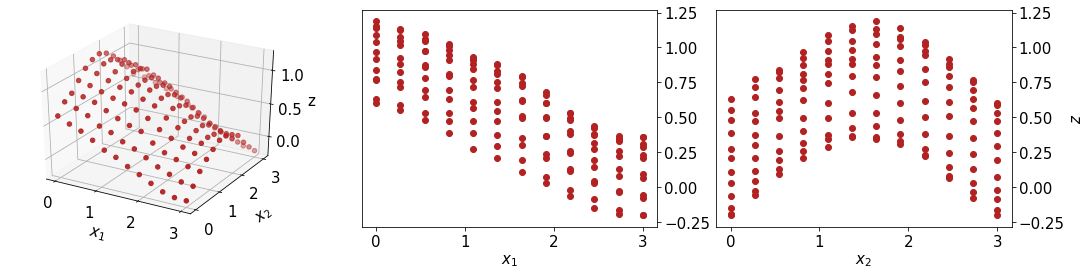

In [66]:
#### Formating data into a data_input dictionary format used for the VC_calibration_hyper functions
# This is independent from any GP specification or the type of variance reduction used

# index generating
Y_index = np.array([i + 1 for i in range(len(Y))])[:,None]
Z_index = np.array([i + 1 + len(Y) for i in range(len(Z))])[:,None]

# Response conc. index
Y_input = np.concatenate((Y_index, np.array([1] * len(Y))[:,None], Y), axis = 1)
Z_input = np.concatenate((Z_index, np.array([0] * len(Z))[:, None], Z), axis = 1)
Response_input = np.concatenate((Y_input, Z_input), axis = 0)

# Input values X
Y_X = np.concatenate((Y_index, input_obs), axis = 1)
Z_X = np.concatenate((Z_index, input_m[:,:d_input]), axis = 1)
X_input = np.concatenate((Y_X, Z_X))

########### This will be done in each stap of the sampling procedure but needs to be initialized to something
# Input values theta
theta_variational = theta
theta_variational = np.repeat(theta_variational, len(Y))
theta_variational = theta_variational.reshape((len(Y),theta_dim), order='F')

Y_theta = np.concatenate((Y_index, theta_variational), axis = 1)
Z_theta = np.concatenate((Z_index, input_m[:,d_input:]), axis = 1)
Theta_input = np.concatenate((Y_theta, Z_theta))

# Data input for 
data_input = {"Response": Response_input, "X": X_input, "Theta": Theta_input}

# Bijection
n = n_m + n_obs

### Save the data_input dictionary as .pickle file
#with open(str(n_obs) + '_' + str(n_m) + '.pickle', 'wb') as handle:
#    pkl.dump(data_input, handle, protocol=pkl.HIGHEST_PROTOCOL)
###

### Load the data_input dictionary from .pickle file
#with open(str(n_obs) + '_' + str(n_m) + "_" + str(lims[0][1]) + '.pickle', 'rb') as handle:
#    data_input = pkl.load(handle)
###

####################### Optional - plots the generated model runs ####################
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(18, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])
ax1 = plt.subplot(gs[0], projection='3d')
ax1.scatter(input_obs[:,0],input_obs[:,1], Y, c = 'firebrick')
ax1.set_xlabel(r'$x_1$', labelpad=10)
ax1.set_ylabel(r'$x_2$', labelpad=10)
ax1.set_zlabel(r'z')

ax2 = plt.subplot(gs[1])
ax2.scatter(input_obs[:,0], Y, c = 'firebrick')
ax2.set_xlabel(r'$x_1$')
ax2.yaxis.tick_right()
ax2.set_ylabel(r'$z$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot(gs[2])
ax3.scatter(input_obs[:,1], Y, c = 'firebrick')
ax3.set_xlabel(r'$x_2$')
ax3.yaxis.tick_right()
ax3.set_ylabel(r'$z$')
ax3.yaxis.set_label_position("right")

plt.show()
plt.show()
####################################################################################

In [67]:
#### Here we define the variational and overdispersed families that will be later initialized
# We set tau for initialization to be 2 here
variational_dictionary = {}
overdispersed_dictionary = {}
param_a = 1.0 # See definition of "a" in "lambda" distribution families
### Theta
mean_theta = np.array([0.5, 0.5])
cov_theta = np.array([1/10, 1/10])
dim = theta_dim
theta_var = gaussian_mean_field_family_lambda_param(param = {"mu": mean_theta, "sigma": cov_theta, "a": param_a}, dim = dim)
variational_dictionary["theta"] = theta_var

tau_theta = np.array([2, 2])
theta_var_od = gaussian_mean_field_family_lambda_param_overdisp(param = {"mu": mean_theta, "sigma": cov_theta, "a": param_a}, tau=tau_theta, dim = dim)
overdispersed_dictionary["theta"] = theta_var_od

### Noise prior
alpha = np.array([1])
beta = np.array([1/100])
dim = 1
noise_var = gamma_mean_field_family_lambda_param(param = {"alpha": alpha, "beta": beta, "a": param_a}, dim = dim)
variational_dictionary["sigma"] = noise_var

tau = np.array([2])
noise_var_od = gamma_mean_field_family_lambda_param_overdisp(param = {"alpha": alpha, "beta": beta, "a": param_a}, tau=tau, dim = dim)
overdispersed_dictionary["sigma"] = noise_var_od

### Kernel f hyperparameters priors
## length scales
alpha = np.array([5])
beta = np.array([1/10])
dim = 1
kernel_f_l_var = gamma_mean_field_family_lambda_param(param = {"alpha": alpha, "beta": beta, "a": param_a}, dim = dim)
variational_dictionary["kernel_f_l"] = kernel_f_l_var

tau = np.array([2])
kernel_f_l_var_od = gamma_mean_field_family_lambda_param_overdisp(param = {"alpha": alpha, "beta": beta, "a": param_a}, tau=tau, dim = dim)
overdispersed_dictionary["kernel_f_l"] = kernel_f_l_var_od

## eta
alpha = np.array([1])
beta = np.array([1/35])
dim = 1
kernel_f_eta_var = gamma_mean_field_family_lambda_param(param = {"alpha": alpha, "beta": beta, "a": param_a}, dim = dim)
variational_dictionary["kernel_f_eta"] = kernel_f_eta_var

tau = np.array([2])
kernel_f_eta_var_od = gamma_mean_field_family_lambda_param_overdisp(param = {"alpha": alpha, "beta": beta, "a": param_a}, tau=tau, dim = dim)
overdispersed_dictionary["kernel_f_eta"] = kernel_f_eta_var_od

### Kernel delta hyperparameters priors
## length scales
alpha = np.array([5])
beta = np.array([1/10])
dim = 1
kernel_delta_l_var = gamma_mean_field_family_lambda_param(param = {"alpha": alpha, "beta": beta, "a": param_a}, dim = dim)
variational_dictionary["kernel_delta_l"] = kernel_delta_l_var

tau = np.array([2])
kernel_delta_l_var_od = gamma_mean_field_family_lambda_param_overdisp(param = {"alpha": alpha, "beta": beta, "a": param_a}, tau=tau, dim = dim)
overdispersed_dictionary["kernel_delta_l"] = kernel_delta_l_var_od

## eta
alpha = np.array([1])
beta = np.array([1/35])
dim = 1
kernel_delta_eta_var = gamma_mean_field_family_lambda_param(param = {"alpha": alpha, "beta": beta, "a": param_a}, dim = dim)
variational_dictionary["kernel_delta_eta"] = kernel_delta_eta_var

tau = np.array([2])
kernel_delta_eta_var_od = gamma_mean_field_family_lambda_param_overdisp(param = {"alpha": alpha, "beta": beta, "a": param_a}, tau=tau, dim = dim)
overdispersed_dictionary["kernel_delta_eta"] = kernel_delta_eta_var_od

mean_beta = np.array([0])
cov_beta = np.array([1/5])
dim = 1
mean_delta_var = gaussian_mean_field_family_lambda_param(param = {"mu": mean_beta, "sigma": cov_beta, "a": param_a}, dim = dim)
variational_dictionary["mean_delta"] = mean_delta_var

tau = np.array([2])
mean_delta_var_od = gaussian_mean_field_family_lambda_param_overdisp(param = {"mu": mean_beta, "sigma": cov_beta, "a": param_a}, tau = tau, dim = dim)
overdispersed_dictionary["mean_delta"] = mean_delta_var_od

###### This loads innitializations used in the simulation study

init_summary = pd.read_json('./' + str(n_obs) + '_' + str(n_m) + "_" + str(lims[0][1]) + '_init.json')
print("Initialization for the variational families")
print(init_summary[["mean", "sd"]])

Initialization for the variational families
                      mean        sd
theta__0          0.502985  0.098578
theta__1          0.502466  0.104133
mean_delta        0.001854  0.246342
sigma             0.012835  0.012055
kernel_f_l__0     0.249247  0.247835
kernel_f_eta      0.023635  0.023487
kernel_delta_l    0.258972  0.256659
kernel_delta_eta  0.024979  0.025863


In [116]:
##### This chunk carries out the VC_calibration_hyper versions of Variational calibration
# The preset of tuning parameters is according to the Application - calibration simulation 
# in Kejzlar and Maiti (2020)
Variance_red = "OD" # Which variance technique
np.random.seed(123)
tf.random.set_seed(123)
vine_type = "D" # Vine decomposition "D" or "C"
l = 3 # Truncation level
variational_dictionary, overdispersed_dictionary = init_variational_dictionary(init_summary, variational_dictionary, overdispersed_dictionary)
# Dimensions
x_dim = 2
theta_dim = 2
# SGA setup
n_steps = 200
S = 50
S_CV = 10
learning_rate = "AdaGrad"
eta = 0.07
decay = 1.0

# RB + CV + Importance sampling
if Variance_red == "OD":
    folder = "OBB_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) + "_vine_" + vine_type + "_learning_" + learning_rate + \
        "_eta_" + str(eta) + "_decay_" + str(param_a)
    time_counter, var_lambda_array, overdispersed_tau_array = VC_calibration_hyper_RB_CV_OD(data_input, Y_index, Z_index, input_m, kernels,
                                                      means, vine_type, priors_dictionary, variational_dictionary, overdispersed_dictionary,
                                                      x_dim, theta_dim, n_steps,
                                                      S, S_CV, l, folder, learning_rate = learning_rate, alpha_tau = 0.05,
                                                      n_core = 1, eta = eta, decay = decay)
# RB + CV
elif Variance_red == "CV":
    folder =str(n_obs) + "_S_" + str(S) + "_l_" + str(l) + "_vine_" + vine_type + "_learning_" + learning_rate + \
        "_eta_" + str(eta) + "_decay_" + str(param_a)
    time_counter, var_lambda_array = VC_calibration_hyper_RB_CV(data_input, Y_index, Z_index, input_m, kernels,
                                                      means, vine_type, priors_dictionary, variational_dictionary,
                                                      x_dim, theta_dim, n_steps,
                                                      S, S_CV, l, folder, learning_rate = learning_rate,
                                                      n_core = 1, eta = eta, decay = decay)

# RB
else:
    folder ="nv" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) + "_vine_" + vine_type + "_learning_" + learning_rate + \
        "_eta_" + str(eta) + "_decay_" + str(param_a)

    time_counter, var_lambda_array = VC_calibration_hyper_RB(data_input, Y_index, Z_index, input_m, kernels,
                                                      means, vine_type, priors_dictionary, variational_dictionary,
                                                      x_dim, theta_dim, n_steps,
                                                      S, l, folder, learning_rate = learning_rate,
                                                      n_core = 1, eta = eta, decay = decay)






SGA optimization:   0%|                                                                        | 0/200 [00:00<?, ?it/s]




SGA optimization:   0%|▎                                                               | 1/200 [00:01<05:06,  1.54s/it]




SGA optimization:   1%|▋                                                               | 2/200 [00:02<04:55,  1.49s/it]




SGA optimization:   2%|▉                                                               | 3/200 [00:04<04:39,  1.42s/it]




SGA optimization:   2%|█▎                                                              | 4/200 [00:05<04:31,  1.39s/it]




SGA optimization:   2%|█▌                                                              | 5/200 [00:06<04:23,  1.35s/it]




SGA optimization:   3%|█▉                                                              | 6/200 [00:08<04:18,  1.33s/it]




SGA optimization:   4%|██▏                                                             | 7/200 [00:09<04:23,  1.36s/it]




SGA

SGA optimization:  29%|██████████████████▎                                            | 58/200 [01:17<03:18,  1.39s/it]




SGA optimization:  30%|██████████████████▌                                            | 59/200 [01:19<03:20,  1.42s/it]




SGA optimization:  30%|██████████████████▉                                            | 60/200 [01:20<03:19,  1.43s/it]




SGA optimization:  30%|███████████████████▏                                           | 61/200 [01:22<03:37,  1.57s/it]




SGA optimization:  31%|███████████████████▌                                           | 62/200 [01:24<03:56,  1.72s/it]




SGA optimization:  32%|███████████████████▊                                           | 63/200 [01:26<03:49,  1.68s/it]




SGA optimization:  32%|████████████████████▏                                          | 64/200 [01:27<03:30,  1.55s/it]




SGA optimization:  32%|████████████████████▍                                          | 65/200 [01:28<03:17,  1.47s/it]




SGA opti

SGA optimization:  58%|███████████████████████████████████▉                          | 116/200 [02:43<02:04,  1.49s/it]




SGA optimization:  58%|████████████████████████████████████▎                         | 117/200 [02:45<02:02,  1.47s/it]




SGA optimization:  59%|████████████████████████████████████▌                         | 118/200 [02:46<01:58,  1.44s/it]




SGA optimization:  60%|████████████████████████████████████▉                         | 119/200 [02:47<01:57,  1.45s/it]




SGA optimization:  60%|█████████████████████████████████████▏                        | 120/200 [02:49<01:54,  1.43s/it]




SGA optimization:  60%|█████████████████████████████████████▌                        | 121/200 [02:51<01:58,  1.50s/it]




SGA optimization:  61%|█████████████████████████████████████▊                        | 122/200 [02:52<01:59,  1.53s/it]




SGA optimization:  62%|██████████████████████████████████████▏                       | 123/200 [02:54<01:55,  1.50s/it]




SGA opti

SGA optimization:  87%|█████████████████████████████████████████████████████▉        | 174/200 [04:09<00:39,  1.51s/it]




SGA optimization:  88%|██████████████████████████████████████████████████████▎       | 175/200 [04:10<00:39,  1.59s/it]




SGA optimization:  88%|██████████████████████████████████████████████████████▌       | 176/200 [04:12<00:40,  1.68s/it]




SGA optimization:  88%|██████████████████████████████████████████████████████▊       | 177/200 [04:14<00:37,  1.61s/it]




SGA optimization:  89%|███████████████████████████████████████████████████████▏      | 178/200 [04:15<00:34,  1.55s/it]




SGA optimization:  90%|███████████████████████████████████████████████████████▍      | 179/200 [04:17<00:32,  1.55s/it]




SGA optimization:  90%|███████████████████████████████████████████████████████▊      | 180/200 [04:18<00:30,  1.52s/it]




SGA optimization:  90%|████████████████████████████████████████████████████████      | 181/200 [04:20<00:28,  1.50s/it]




SGA opti

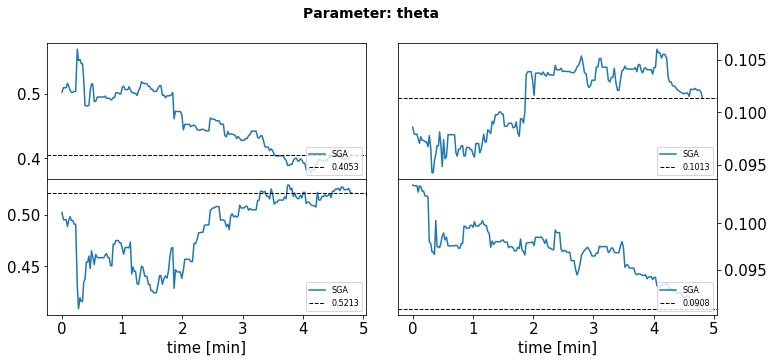

In [117]:
variational_approximation_plot_param(var_lambda_array, param_a = 1, parameter = "theta", time_steps= time_counter, cutoff = len(var_lambda_array))

## Predictions

In [118]:
##### First, we generate the testing dataset of size 50
n_pred = 50
n_m_pred = 50 # this is actually only an arthefact 
n_average = 1
d_input = 2
tf.random.set_seed(123)
np.random.seed(123)
lims = np.array([[0, 3], [0, 3]])
input_obs_pred = input_locations(d_input, n_pred, lims=lims, criterion = "c") # Accord
d_input = 2
lims = np.array([[0, 3], [0,3], [0, 1], [0, 1]])
input_m_pred = input_locations(theta_dim + d_input, n_m_pred, lims=lims, criterion = "c")

tf.random.set_seed(123)
np.random.seed(123)
# Data sample with true theta
# See the definition of gp_mean_cov_pred it does not use the information on model runs
tfd_pred = tfp.distributions
M, K = gp_mean_cov_pred(input_obs_pred, input_m_pred, d_input, theta, kernels_input, means_input) 
mvn_pred = tfd.MultivariateNormalFullCovariance(loc=M, covariance_matrix=K)
input_new = input_obs_pred
Y_new_tensor = mvn_pred.sample(1)
Y_new = Y_new_tensor.numpy().flatten()

##### Loads saved .pickle training data data
#n_obs = 144
#n_m = 81
#limits = 3
#with open(str(n_obs) + '_' + str(n_m) + "_" + str(limits) + '.pickle', 'rb') as handle:
#    data_input = pkl.load(handle)
#Y_Z = data_input["Response"][:,-1]
#input_obs = data_input['X'][:n_obs,1:]
#input_m = np.concatenate([data_input['X'][n_obs:,1:], data_input['Theta'][n_obs:,1:]], axis = 1)
#####

In [119]:
##### This obtains MSE values given testing and training data
tf.random.set_seed(123)
np.random.seed(123)
input_new = input_obs_pred
n_steps = 100
n_sample = 5000

MSE_array, logprob_array = post_pred_vc_indep(variational_dictionary, var_lambda_array,
                 input_obs, input_m, input_new, Y_Z, Y_new,
                 d_input, n_pred, n_steps, n_sample)






  0%|                                                                                          | 0/100 [00:00<?, ?it/s]




  5%|████                                                                              | 5/100 [00:00<00:02, 46.40it/s]




 11%|████████▉                                                                        | 11/100 [00:00<00:01, 48.01it/s]




 17%|█████████████▊                                                                   | 17/100 [00:00<00:01, 49.96it/s]




 23%|██████████████████▋                                                              | 23/100 [00:00<00:01, 51.03it/s]




 29%|███████████████████████▍                                                         | 29/100 [00:00<00:01, 51.42it/s]




 35%|████████████████████████████▎                                                    | 35/100 [00:00<00:01, 51.68it/s]




 40%|████████████████████████████████▍                                                | 40/100 [00:00<00:01, 49.98it/s]




 45

In [135]:
#### Running this block recreates the MSE part of Figure 2 from pre-computed results

#### This Loads Predictions
time_scale = 3600

n_obs = 144
n_steps = 8000
S = 50
l =3
vine_type = "D"
learning_rate = "AdaGrad"
eta = 0.07
decay = 1.0
folder = str(n_obs) + "_S_" + str(S) + "_l_" + str(l) + "_vine_" + vine_type + "_learning_" + learning_rate + \
                                    "_eta_" + str(eta) + "_decay_" + str(decay)
var_lambda_array = np.load("Simulation_results/Memory_profiles/" + folder + "/" + "param_nobs_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) +  "_vine_" + vine_type + "_step_" + str(n_steps) +".npy")
time_steps = np.load("Simulation_results/Memory_profiles/" + folder + "/" + "time_nobs_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) +  "_vine_" + vine_type + "_step_" + str(n_steps) +".npy")
time_steps_no = (time_steps - time_steps[-0]) / time_scale
tf.random.set_seed(123)
np.random.seed(123)
input_new = input_obs_pred
n_steps = 8000
n_sample = 5000
MSE_array_no, logprob_array_no = post_pred_vc_indep(variational_dictionary, var_lambda_array,
                 input_obs, input_m, input_new, Y_Z, Y_new,
                 d_input, n_pred, n_steps, n_sample)


n_obs = 144
n_steps = 8000
S = 50
l =3
vine_type = "D"
learning_rate = "AdaGrad"
eta = 0.07
decay = 1.0
folder = str(n_obs) + "_S_" + str(S) + "_l_" + str(l) + "_vine_" + vine_type + "_learning_" + learning_rate + \
                                    "_eta_" + str(eta) + "_decay_" + str(decay)
var_lambda_array = np.load("Simulation_results/Memory_profiles/OBB_"  + folder + "/" + "param_nobs_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) +  "_vine_" + vine_type + "_step_" + str(n_steps) +".npy")
time_steps = np.load("Simulation_results/Memory_profiles/OBB_" + folder + "/" + "time_nobs_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) +  "_vine_" + vine_type + "_step_" + str(n_steps) +".npy")
time_steps_full = (time_steps - time_steps[-0]) / time_scale
tf.random.set_seed(123)
np.random.seed(123)
input_new = input_obs_pred
n_steps = len(var_lambda_array)
n_steps = 8000
n_sample = 5000
#var_lambda_array = var_lambda_array[-1000:,:]
MSE_array_full, logprob_array_full = post_pred_vc_indep(variational_dictionary, var_lambda_array,
                 input_obs, input_m, input_new, Y_Z, Y_new,
                 d_input, n_pred, n_steps, n_sample)

n_obs = 144
n_steps = 10000
S = 50
l =3
vine_type = "D"
learning_rate = "AdaGrad"
eta = 0.07
decay = 1.0
folder = str(n_obs) + "_S_" + str(S) + "_l_" + str(l) + "_vine_" + vine_type + "_learning_" + learning_rate + \
                                    "_eta_" + str(eta) + "_decay_" + str(decay)
var_lambda_array = np.load("Simulation_results/Memory_profiles/nv" + folder + "/" + "param_nobs_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) +  "_vine_" + vine_type + "_step_" + str(n_steps) +".npy")
time_steps = np.load("Simulation_results/Memory_profiles/nv" + folder + "/" + "time_nobs_" + str(n_obs) + "_S_" + str(S) + "_l_" + str(l) +  "_vine_" + vine_type + "_step_" + str(n_steps) +".npy")
time_steps_nv = (time_steps - time_steps[-0]) / time_scale
tf.random.set_seed(123)
np.random.seed(123)
input_new = input_obs_pred
n_steps = 8000
n_sample = 5000
MSE_array_nv, logprob_array_nv = post_pred_vc_indep(variational_dictionary, var_lambda_array,
                 input_obs, input_m, input_new, Y_Z, Y_new,
                 d_input, n_pred, n_steps, n_sample)






  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]




  0%|                                                                                 | 4/8000 [00:00<03:27, 38.57it/s]




  0%|                                                                                | 10/8000 [00:00<03:11, 41.78it/s]




  0%|▏                                                                               | 16/8000 [00:00<02:59, 44.36it/s]




  0%|▏                                                                               | 21/8000 [00:00<02:57, 44.96it/s]




  0%|▎                                                                               | 27/8000 [00:00<02:50, 46.83it/s]




  0%|▎                                                                               | 33/8000 [00:00<02:44, 48.47it/s]




  0%|▍                                                                               | 39/8000 [00:00<02:39, 49.81it/s]




  1

  4%|███▎                                                                           | 335/8000 [00:06<02:23, 53.60it/s]




  4%|███▎                                                                           | 341/8000 [00:06<02:21, 54.27it/s]




  4%|███▍                                                                           | 347/8000 [00:06<02:21, 54.25it/s]




  4%|███▍                                                                           | 353/8000 [00:06<02:22, 53.51it/s]




  4%|███▌                                                                           | 359/8000 [00:07<02:37, 48.46it/s]




  5%|███▌                                                                           | 364/8000 [00:07<02:42, 47.02it/s]




  5%|███▋                                                                           | 369/8000 [00:07<02:43, 46.57it/s]




  5%|███▋                                                                           | 374/8000 [00:07<02:42, 46.86it/s]




  5%|███

  8%|██████▋                                                                        | 679/8000 [00:13<02:13, 54.73it/s]




  9%|██████▊                                                                        | 685/8000 [00:13<02:13, 54.87it/s]




  9%|██████▊                                                                        | 691/8000 [00:13<02:12, 55.11it/s]




  9%|██████▉                                                                        | 697/8000 [00:13<02:12, 55.20it/s]




  9%|██████▉                                                                        | 703/8000 [00:13<02:12, 55.20it/s]




  9%|███████                                                                        | 709/8000 [00:13<02:11, 55.50it/s]




  9%|███████                                                                        | 715/8000 [00:13<02:10, 55.72it/s]




  9%|███████                                                                        | 721/8000 [00:13<02:13, 54.36it/s]




  9%|███

 13%|█████████▊                                                                    | 1005/8000 [00:19<03:11, 36.52it/s]




 13%|█████████▊                                                                    | 1011/8000 [00:19<02:52, 40.48it/s]




 13%|█████████▉                                                                    | 1017/8000 [00:19<02:39, 43.90it/s]




 13%|█████████▉                                                                    | 1023/8000 [00:20<02:29, 46.67it/s]




 13%|██████████                                                                    | 1029/8000 [00:20<02:22, 48.82it/s]




 13%|██████████                                                                    | 1035/8000 [00:20<02:17, 50.57it/s]




 13%|██████████▏                                                                   | 1041/8000 [00:20<02:16, 51.08it/s]




 13%|██████████▏                                                                   | 1047/8000 [00:20<02:12, 52.39it/s]




 13%|███

 17%|█████████████▏                                                                | 1353/8000 [00:26<01:59, 55.44it/s]




 17%|█████████████▎                                                                | 1359/8000 [00:26<01:59, 55.52it/s]




 17%|█████████████▎                                                                | 1365/8000 [00:26<01:59, 55.73it/s]




 17%|█████████████▎                                                                | 1371/8000 [00:26<01:58, 55.88it/s]




 17%|█████████████▍                                                                | 1377/8000 [00:26<01:57, 56.14it/s]




 17%|█████████████▍                                                                | 1383/8000 [00:26<01:57, 56.16it/s]




 17%|█████████████▌                                                                | 1389/8000 [00:26<01:58, 55.71it/s]




 17%|█████████████▌                                                                | 1395/8000 [00:26<01:59, 55.40it/s]




 18%|███

 21%|████████████████▌                                                             | 1701/8000 [00:32<01:54, 55.10it/s]




 21%|████████████████▋                                                             | 1707/8000 [00:32<01:53, 55.29it/s]




 21%|████████████████▋                                                             | 1713/8000 [00:32<01:54, 54.95it/s]




 21%|████████████████▊                                                             | 1719/8000 [00:32<01:54, 55.02it/s]




 22%|████████████████▊                                                             | 1725/8000 [00:32<01:52, 55.53it/s]




 22%|████████████████▉                                                             | 1731/8000 [00:32<01:52, 55.59it/s]




 22%|████████████████▉                                                             | 1737/8000 [00:33<01:53, 55.31it/s]




 22%|████████████████▉                                                             | 1743/8000 [00:33<01:53, 55.28it/s]




 22%|███

 26%|███████████████████▉                                                          | 2049/8000 [00:38<01:49, 54.26it/s]




 26%|████████████████████                                                          | 2055/8000 [00:38<01:48, 54.67it/s]




 26%|████████████████████                                                          | 2061/8000 [00:38<01:48, 54.97it/s]




 26%|████████████████████▏                                                         | 2067/8000 [00:39<01:47, 55.34it/s]




 26%|████████████████████▏                                                         | 2073/8000 [00:39<01:46, 55.61it/s]




 26%|████████████████████▎                                                         | 2079/8000 [00:39<01:46, 55.48it/s]




 26%|████████████████████▎                                                         | 2085/8000 [00:39<01:46, 55.55it/s]




 26%|████████████████████▍                                                         | 2091/8000 [00:39<01:46, 55.59it/s]




 26%|███

 30%|███████████████████████▎                                                      | 2397/8000 [00:44<01:41, 55.13it/s]




 30%|███████████████████████▍                                                      | 2403/8000 [00:45<01:41, 55.30it/s]




 30%|███████████████████████▍                                                      | 2409/8000 [00:45<01:41, 55.11it/s]




 30%|███████████████████████▌                                                      | 2415/8000 [00:45<01:41, 55.29it/s]




 30%|███████████████████████▌                                                      | 2421/8000 [00:45<01:40, 55.26it/s]




 30%|███████████████████████▋                                                      | 2427/8000 [00:45<01:40, 55.40it/s]




 30%|███████████████████████▋                                                      | 2433/8000 [00:45<01:41, 54.88it/s]




 30%|███████████████████████▊                                                      | 2439/8000 [00:45<01:40, 55.12it/s]




 31%|███

 34%|██████████████████████████▊                                                   | 2745/8000 [00:51<01:34, 55.37it/s]




 34%|██████████████████████████▊                                                   | 2751/8000 [00:51<01:34, 55.31it/s]




 34%|██████████████████████████▉                                                   | 2757/8000 [00:51<01:35, 55.13it/s]




 35%|██████████████████████████▉                                                   | 2763/8000 [00:51<01:35, 54.69it/s]




 35%|██████████████████████████▉                                                   | 2769/8000 [00:51<01:35, 54.98it/s]




 35%|███████████████████████████                                                   | 2775/8000 [00:51<01:36, 54.15it/s]




 35%|███████████████████████████                                                   | 2781/8000 [00:51<01:36, 54.31it/s]




 35%|███████████████████████████▏                                                  | 2787/8000 [00:52<01:34, 55.03it/s]




 35%|███

 39%|██████████████████████████████▏                                               | 3093/8000 [00:57<01:28, 55.23it/s]




 39%|██████████████████████████████▏                                               | 3099/8000 [00:57<01:28, 55.37it/s]




 39%|██████████████████████████████▎                                               | 3105/8000 [00:57<01:28, 55.47it/s]




 39%|██████████████████████████████▎                                               | 3111/8000 [00:57<01:28, 55.54it/s]




 39%|██████████████████████████████▍                                               | 3117/8000 [00:58<01:27, 55.59it/s]




 39%|██████████████████████████████▍                                               | 3123/8000 [00:58<01:27, 55.63it/s]




 39%|██████████████████████████████▌                                               | 3129/8000 [00:58<01:28, 55.19it/s]




 39%|██████████████████████████████▌                                               | 3135/8000 [00:58<01:28, 55.04it/s]




 39%|███

 43%|█████████████████████████████████▌                                            | 3441/8000 [01:03<01:23, 54.84it/s]




 43%|█████████████████████████████████▌                                            | 3447/8000 [01:04<01:23, 54.65it/s]




 43%|█████████████████████████████████▋                                            | 3453/8000 [01:04<01:22, 54.96it/s]




 43%|█████████████████████████████████▋                                            | 3459/8000 [01:04<01:22, 55.19it/s]




 43%|█████████████████████████████████▊                                            | 3465/8000 [01:04<01:22, 55.19it/s]




 43%|█████████████████████████████████▊                                            | 3471/8000 [01:04<01:21, 55.49it/s]




 43%|█████████████████████████████████▉                                            | 3477/8000 [01:04<01:21, 55.71it/s]




 44%|█████████████████████████████████▉                                            | 3483/8000 [01:04<01:21, 55.71it/s]




 44%|███

 47%|████████████████████████████████████▉                                         | 3789/8000 [01:10<01:18, 53.85it/s]




 47%|█████████████████████████████████████                                         | 3795/8000 [01:10<01:17, 54.25it/s]




 48%|█████████████████████████████████████                                         | 3801/8000 [01:10<01:17, 54.00it/s]




 48%|█████████████████████████████████████                                         | 3807/8000 [01:10<01:17, 53.91it/s]




 48%|█████████████████████████████████████▏                                        | 3813/8000 [01:10<01:17, 54.29it/s]




 48%|█████████████████████████████████████▏                                        | 3819/8000 [01:10<01:16, 54.85it/s]




 48%|█████████████████████████████████████▎                                        | 3825/8000 [01:11<01:43, 40.20it/s]




 48%|█████████████████████████████████████▎                                        | 3831/8000 [01:11<01:36, 43.20it/s]




 48%|███

 52%|████████████████████████████████████████▎                                     | 4137/8000 [01:16<01:10, 55.02it/s]




 52%|████████████████████████████████████████▍                                     | 4143/8000 [01:16<01:10, 54.62it/s]




 52%|████████████████████████████████████████▍                                     | 4149/8000 [01:17<01:10, 54.64it/s]




 52%|████████████████████████████████████████▌                                     | 4155/8000 [01:17<01:09, 54.95it/s]




 52%|████████████████████████████████████████▌                                     | 4161/8000 [01:17<01:10, 54.43it/s]




 52%|████████████████████████████████████████▋                                     | 4167/8000 [01:17<01:10, 54.65it/s]




 52%|████████████████████████████████████████▋                                     | 4173/8000 [01:17<01:09, 54.82it/s]




 52%|████████████████████████████████████████▋                                     | 4179/8000 [01:17<01:09, 54.78it/s]




 52%|███

 56%|███████████████████████████████████████████▋                                  | 4485/8000 [01:23<01:03, 55.21it/s]




 56%|███████████████████████████████████████████▊                                  | 4491/8000 [01:23<01:04, 54.31it/s]




 56%|███████████████████████████████████████████▊                                  | 4497/8000 [01:23<01:05, 53.26it/s]




 56%|███████████████████████████████████████████▉                                  | 4503/8000 [01:23<01:05, 53.40it/s]




 56%|███████████████████████████████████████████▉                                  | 4509/8000 [01:23<01:04, 53.78it/s]




 56%|████████████████████████████████████████████                                  | 4515/8000 [01:23<01:05, 53.45it/s]




 57%|████████████████████████████████████████████                                  | 4521/8000 [01:23<01:04, 53.97it/s]




 57%|████████████████████████████████████████████▏                                 | 4527/8000 [01:23<01:03, 54.47it/s]




 57%|███

 60%|███████████████████████████████████████████████                               | 4833/8000 [01:29<00:57, 54.92it/s]




 60%|███████████████████████████████████████████████▏                              | 4839/8000 [01:29<00:57, 55.00it/s]




 61%|███████████████████████████████████████████████▏                              | 4845/8000 [01:29<00:57, 54.91it/s]




 61%|███████████████████████████████████████████████▎                              | 4851/8000 [01:29<00:57, 55.00it/s]




 61%|███████████████████████████████████████████████▎                              | 4857/8000 [01:29<00:57, 55.06it/s]




 61%|███████████████████████████████████████████████▍                              | 4863/8000 [01:30<00:56, 55.25it/s]




 61%|███████████████████████████████████████████████▍                              | 4869/8000 [01:30<00:56, 55.08it/s]




 61%|███████████████████████████████████████████████▌                              | 4875/8000 [01:30<00:57, 54.52it/s]




 61%|███

 65%|██████████████████████████████████████████████████▌                           | 5181/8000 [01:35<00:51, 54.54it/s]




 65%|██████████████████████████████████████████████████▌                           | 5187/8000 [01:35<00:52, 54.00it/s]




 65%|██████████████████████████████████████████████████▋                           | 5193/8000 [01:36<00:52, 53.91it/s]




 65%|██████████████████████████████████████████████████▋                           | 5199/8000 [01:36<00:51, 54.28it/s]




 65%|██████████████████████████████████████████████████▋                           | 5205/8000 [01:36<00:51, 54.26it/s]




 65%|██████████████████████████████████████████████████▊                           | 5211/8000 [01:36<00:51, 54.39it/s]




 65%|██████████████████████████████████████████████████▊                           | 5217/8000 [01:36<00:50, 54.78it/s]




 65%|██████████████████████████████████████████████████▉                           | 5223/8000 [01:36<00:51, 54.45it/s]




 65%|███

 69%|█████████████████████████████████████████████████████▉                        | 5529/8000 [01:42<00:45, 54.08it/s]




 69%|█████████████████████████████████████████████████████▉                        | 5535/8000 [01:42<00:45, 54.41it/s]




 69%|██████████████████████████████████████████████████████                        | 5541/8000 [01:42<00:45, 54.49it/s]




 69%|██████████████████████████████████████████████████████                        | 5547/8000 [01:42<00:44, 54.70it/s]




 69%|██████████████████████████████████████████████████████▏                       | 5553/8000 [01:42<00:44, 54.55it/s]




 69%|██████████████████████████████████████████████████████▏                       | 5559/8000 [01:42<00:46, 52.86it/s]




 70%|██████████████████████████████████████████████████████▎                       | 5565/8000 [01:42<00:45, 53.54it/s]




 70%|██████████████████████████████████████████████████████▎                       | 5571/8000 [01:43<00:44, 54.02it/s]




 70%|███

 73%|█████████████████████████████████████████████████████████▎                    | 5877/8000 [01:48<00:39, 53.59it/s]




 74%|█████████████████████████████████████████████████████████▎                    | 5883/8000 [01:48<00:39, 54.05it/s]




 74%|█████████████████████████████████████████████████████████▍                    | 5889/8000 [01:48<00:38, 54.25it/s]




 74%|█████████████████████████████████████████████████████████▍                    | 5895/8000 [01:49<00:38, 54.52it/s]




 74%|█████████████████████████████████████████████████████████▌                    | 5901/8000 [01:49<00:38, 54.43it/s]




 74%|█████████████████████████████████████████████████████████▌                    | 5907/8000 [01:49<00:38, 54.36it/s]




 74%|█████████████████████████████████████████████████████████▋                    | 5913/8000 [01:49<00:38, 54.75it/s]




 74%|█████████████████████████████████████████████████████████▋                    | 5919/8000 [01:49<00:38, 54.59it/s]




 74%|███

 78%|████████████████████████████████████████████████████████████▋                 | 6225/8000 [01:55<00:32, 53.90it/s]




 78%|████████████████████████████████████████████████████████████▊                 | 6231/8000 [01:55<00:32, 54.13it/s]




 78%|████████████████████████████████████████████████████████████▊                 | 6237/8000 [01:55<00:32, 53.86it/s]




 78%|████████████████████████████████████████████████████████████▊                 | 6243/8000 [01:55<00:32, 54.25it/s]




 78%|████████████████████████████████████████████████████████████▉                 | 6249/8000 [01:55<00:32, 54.53it/s]




 78%|████████████████████████████████████████████████████████████▉                 | 6255/8000 [01:55<00:32, 54.29it/s]




 78%|█████████████████████████████████████████████████████████████                 | 6261/8000 [01:55<00:31, 54.70it/s]




 78%|█████████████████████████████████████████████████████████████                 | 6267/8000 [01:55<00:31, 54.85it/s]




 78%|███

 82%|████████████████████████████████████████████████████████████████              | 6573/8000 [02:01<00:26, 54.24it/s]




 82%|████████████████████████████████████████████████████████████████▏             | 6579/8000 [02:01<00:26, 54.08it/s]




 82%|████████████████████████████████████████████████████████████████▏             | 6585/8000 [02:01<00:26, 54.26it/s]




 82%|████████████████████████████████████████████████████████████████▎             | 6591/8000 [02:01<00:25, 54.24it/s]




 82%|████████████████████████████████████████████████████████████████▎             | 6597/8000 [02:02<00:25, 54.23it/s]




 83%|████████████████████████████████████████████████████████████████▍             | 6603/8000 [02:02<00:25, 54.52it/s]




 83%|████████████████████████████████████████████████████████████████▍             | 6609/8000 [02:02<00:25, 54.42it/s]




 83%|████████████████████████████████████████████████████████████████▍             | 6615/8000 [02:02<00:25, 54.62it/s]




 83%|███

 87%|███████████████████████████████████████████████████████████████████▍          | 6921/8000 [02:08<00:20, 53.06it/s]




 87%|███████████████████████████████████████████████████████████████████▌          | 6927/8000 [02:08<00:20, 53.54it/s]




 87%|███████████████████████████████████████████████████████████████████▌          | 6933/8000 [02:08<00:20, 53.31it/s]




 87%|███████████████████████████████████████████████████████████████████▋          | 6939/8000 [02:08<00:19, 53.86it/s]




 87%|███████████████████████████████████████████████████████████████████▋          | 6945/8000 [02:08<00:19, 54.26it/s]




 87%|███████████████████████████████████████████████████████████████████▊          | 6951/8000 [02:08<00:19, 54.83it/s]




 87%|███████████████████████████████████████████████████████████████████▊          | 6957/8000 [02:08<00:19, 54.64it/s]




 87%|███████████████████████████████████████████████████████████████████▉          | 6963/8000 [02:08<00:18, 54.80it/s]




 87%|███

 91%|██████████████████████████████████████████████████████████████████████▊       | 7269/8000 [02:14<00:13, 54.17it/s]




 91%|██████████████████████████████████████████████████████████████████████▉       | 7275/8000 [02:14<00:13, 54.62it/s]




 91%|██████████████████████████████████████████████████████████████████████▉       | 7281/8000 [02:14<00:13, 54.63it/s]




 91%|███████████████████████████████████████████████████████████████████████       | 7287/8000 [02:14<00:13, 54.36it/s]




 91%|███████████████████████████████████████████████████████████████████████       | 7293/8000 [02:14<00:13, 54.16it/s]




 91%|███████████████████████████████████████████████████████████████████████▏      | 7299/8000 [02:15<00:12, 54.32it/s]




 91%|███████████████████████████████████████████████████████████████████████▏      | 7305/8000 [02:15<00:12, 54.28it/s]




 91%|███████████████████████████████████████████████████████████████████████▎      | 7311/8000 [02:15<00:12, 54.56it/s]




 91%|███

 95%|██████████████████████████████████████████████████████████████████████████▎   | 7617/8000 [02:20<00:07, 53.94it/s]




 95%|██████████████████████████████████████████████████████████████████████████▎   | 7623/8000 [02:21<00:06, 54.01it/s]




 95%|██████████████████████████████████████████████████████████████████████████▍   | 7629/8000 [02:21<00:06, 53.78it/s]




 95%|██████████████████████████████████████████████████████████████████████████▍   | 7635/8000 [02:21<00:06, 54.20it/s]




 96%|██████████████████████████████████████████████████████████████████████████▍   | 7641/8000 [02:21<00:06, 54.49it/s]




 96%|██████████████████████████████████████████████████████████████████████████▌   | 7647/8000 [02:21<00:06, 54.55it/s]




 96%|██████████████████████████████████████████████████████████████████████████▌   | 7653/8000 [02:21<00:06, 54.90it/s]




 96%|██████████████████████████████████████████████████████████████████████████▋   | 7659/8000 [02:21<00:06, 53.52it/s]




 96%|███

100%|█████████████████████████████████████████████████████████████████████████████▋| 7964/8000 [02:27<00:00, 53.51it/s]




100%|█████████████████████████████████████████████████████████████████████████████▋| 7970/8000 [02:27<00:00, 53.58it/s]




100%|█████████████████████████████████████████████████████████████████████████████▊| 7976/8000 [02:27<00:00, 53.90it/s]




100%|█████████████████████████████████████████████████████████████████████████████▊| 7982/8000 [02:27<00:00, 54.14it/s]




100%|█████████████████████████████████████████████████████████████████████████████▉| 7988/8000 [02:27<00:00, 54.45it/s]




100%|█████████████████████████████████████████████████████████████████████████████▉| 7994/8000 [02:28<00:00, 53.94it/s]




100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [02:28<00:00, 54.01it/s]





  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]




  0%|  

  4%|██▉                                                                            | 299/8000 [00:05<02:19, 55.10it/s]




  4%|███                                                                            | 305/8000 [00:05<02:18, 55.43it/s]




  4%|███                                                                            | 311/8000 [00:05<02:19, 55.05it/s]




  4%|███▏                                                                           | 317/8000 [00:05<02:19, 55.10it/s]




  4%|███▏                                                                           | 323/8000 [00:05<02:18, 55.27it/s]




  4%|███▏                                                                           | 329/8000 [00:06<02:17, 55.87it/s]




  4%|███▎                                                                           | 335/8000 [00:06<02:17, 55.66it/s]




  4%|███▎                                                                           | 341/8000 [00:06<02:17, 55.67it/s]




  4%|███

  8%|██████▎                                                                        | 645/8000 [00:11<02:16, 53.92it/s]




  8%|██████▍                                                                        | 651/8000 [00:12<02:15, 54.15it/s]




  8%|██████▍                                                                        | 657/8000 [00:12<02:14, 54.75it/s]




  8%|██████▌                                                                        | 663/8000 [00:12<02:13, 55.04it/s]




  8%|██████▌                                                                        | 669/8000 [00:12<02:13, 54.94it/s]




  8%|██████▋                                                                        | 675/8000 [00:12<02:12, 55.31it/s]




  9%|██████▋                                                                        | 681/8000 [00:12<02:13, 54.82it/s]




  9%|██████▊                                                                        | 687/8000 [00:12<02:13, 54.78it/s]




  9%|███

 12%|█████████▊                                                                     | 991/8000 [00:18<02:07, 55.15it/s]




 12%|█████████▊                                                                     | 997/8000 [00:18<02:07, 55.01it/s]




 13%|█████████▊                                                                    | 1003/8000 [00:18<02:07, 54.92it/s]




 13%|█████████▊                                                                    | 1009/8000 [00:18<02:07, 55.00it/s]




 13%|█████████▉                                                                    | 1015/8000 [00:18<02:08, 54.45it/s]




 13%|█████████▉                                                                    | 1021/8000 [00:18<02:08, 54.44it/s]




 13%|██████████                                                                    | 1027/8000 [00:19<02:08, 54.36it/s]




 13%|██████████                                                                    | 1033/8000 [00:19<02:06, 54.91it/s]




 13%|███

 17%|█████████████                                                                 | 1339/8000 [00:24<02:00, 55.24it/s]




 17%|█████████████                                                                 | 1345/8000 [00:24<02:00, 55.38it/s]




 17%|█████████████▏                                                                | 1351/8000 [00:24<02:00, 55.17it/s]




 17%|█████████████▏                                                                | 1357/8000 [00:25<02:00, 55.02it/s]




 17%|█████████████▎                                                                | 1363/8000 [00:25<01:59, 55.53it/s]




 17%|█████████████▎                                                                | 1369/8000 [00:25<01:59, 55.59it/s]




 17%|█████████████▍                                                                | 1375/8000 [00:25<01:58, 55.77it/s]




 17%|█████████████▍                                                                | 1381/8000 [00:25<02:00, 55.14it/s]




 17%|███

 21%|████████████████▍                                                             | 1687/8000 [00:31<01:57, 53.87it/s]




 21%|████████████████▌                                                             | 1693/8000 [00:31<01:55, 54.41it/s]




 21%|████████████████▌                                                             | 1699/8000 [00:31<01:54, 54.80it/s]




 21%|████████████████▌                                                             | 1705/8000 [00:31<01:54, 55.21it/s]




 21%|████████████████▋                                                             | 1711/8000 [00:31<01:53, 55.36it/s]




 21%|████████████████▋                                                             | 1717/8000 [00:31<01:53, 55.31it/s]




 22%|████████████████▊                                                             | 1723/8000 [00:31<01:53, 55.43it/s]




 22%|████████████████▊                                                             | 1729/8000 [00:31<01:53, 55.36it/s]




 22%|███

 25%|███████████████████▊                                                          | 2035/8000 [00:37<01:48, 55.08it/s]




 26%|███████████████████▉                                                          | 2041/8000 [00:37<01:47, 55.42it/s]




 26%|███████████████████▉                                                          | 2047/8000 [00:37<01:46, 55.66it/s]




 26%|████████████████████                                                          | 2053/8000 [00:37<01:46, 55.67it/s]




 26%|████████████████████                                                          | 2059/8000 [00:37<01:47, 55.38it/s]




 26%|████████████████████▏                                                         | 2065/8000 [00:37<01:46, 55.47it/s]




 26%|████████████████████▏                                                         | 2071/8000 [00:38<01:47, 55.07it/s]




 26%|████████████████████▎                                                         | 2077/8000 [00:38<01:48, 54.80it/s]




 26%|███

 30%|███████████████████████▏                                                      | 2383/8000 [00:43<01:44, 53.95it/s]




 30%|███████████████████████▎                                                      | 2389/8000 [00:43<01:43, 54.38it/s]




 30%|███████████████████████▎                                                      | 2395/8000 [00:44<01:43, 54.33it/s]




 30%|███████████████████████▍                                                      | 2401/8000 [00:44<01:42, 54.88it/s]




 30%|███████████████████████▍                                                      | 2407/8000 [00:44<01:41, 54.97it/s]




 30%|███████████████████████▌                                                      | 2413/8000 [00:44<01:40, 55.35it/s]




 30%|███████████████████████▌                                                      | 2419/8000 [00:44<01:40, 55.61it/s]




 30%|███████████████████████▋                                                      | 2425/8000 [00:44<01:40, 55.63it/s]




 30%|███

 34%|██████████████████████████▋                                                   | 2731/8000 [00:50<01:36, 54.52it/s]




 34%|██████████████████████████▋                                                   | 2737/8000 [00:50<01:36, 54.72it/s]




 34%|██████████████████████████▋                                                   | 2743/8000 [00:50<01:35, 54.86it/s]




 34%|██████████████████████████▊                                                   | 2749/8000 [00:50<01:35, 55.11it/s]




 34%|██████████████████████████▊                                                   | 2755/8000 [00:50<01:35, 54.84it/s]




 35%|██████████████████████████▉                                                   | 2761/8000 [00:50<01:35, 55.02it/s]




 35%|██████████████████████████▉                                                   | 2767/8000 [00:50<01:35, 55.07it/s]




 35%|███████████████████████████                                                   | 2773/8000 [00:51<01:34, 55.11it/s]




 35%|███

 38%|██████████████████████████████                                                | 3079/8000 [00:56<01:30, 54.64it/s]




 39%|██████████████████████████████                                                | 3085/8000 [00:56<01:31, 53.63it/s]




 39%|██████████████████████████████▏                                               | 3091/8000 [00:56<01:33, 52.66it/s]




 39%|██████████████████████████████▏                                               | 3097/8000 [00:56<01:31, 53.55it/s]




 39%|██████████████████████████████▎                                               | 3103/8000 [00:57<01:30, 54.32it/s]




 39%|██████████████████████████████▎                                               | 3109/8000 [00:57<01:29, 54.87it/s]




 39%|██████████████████████████████▎                                               | 3115/8000 [00:57<01:29, 54.67it/s]




 39%|██████████████████████████████▍                                               | 3121/8000 [00:57<01:29, 54.53it/s]




 39%|███

 43%|█████████████████████████████████▍                                            | 3427/8000 [01:02<01:23, 55.06it/s]




 43%|█████████████████████████████████▍                                            | 3433/8000 [01:03<01:23, 54.66it/s]




 43%|█████████████████████████████████▌                                            | 3439/8000 [01:03<01:23, 54.81it/s]




 43%|█████████████████████████████████▌                                            | 3445/8000 [01:03<01:22, 54.93it/s]




 43%|█████████████████████████████████▋                                            | 3451/8000 [01:03<01:22, 55.16it/s]




 43%|█████████████████████████████████▋                                            | 3457/8000 [01:03<01:23, 54.72it/s]




 43%|█████████████████████████████████▊                                            | 3463/8000 [01:03<01:22, 54.71it/s]




 43%|█████████████████████████████████▊                                            | 3469/8000 [01:03<01:22, 54.71it/s]




 43%|███

 47%|████████████████████████████████████▊                                         | 3773/8000 [01:09<01:26, 48.70it/s]




 47%|████████████████████████████████████▊                                         | 3779/8000 [01:09<01:23, 50.35it/s]




 47%|████████████████████████████████████▉                                         | 3785/8000 [01:09<01:21, 51.98it/s]




 47%|████████████████████████████████████▉                                         | 3791/8000 [01:09<01:19, 52.90it/s]




 47%|█████████████████████████████████████                                         | 3797/8000 [01:09<01:19, 53.00it/s]




 48%|█████████████████████████████████████                                         | 3803/8000 [01:09<01:18, 53.21it/s]




 48%|█████████████████████████████████████▏                                        | 3809/8000 [01:10<01:17, 53.94it/s]




 48%|█████████████████████████████████████▏                                        | 3815/8000 [01:10<01:17, 54.16it/s]




 48%|███

 52%|████████████████████████████████████████▏                                     | 4121/8000 [01:15<01:11, 54.08it/s]




 52%|████████████████████████████████████████▏                                     | 4127/8000 [01:15<01:11, 54.11it/s]




 52%|████████████████████████████████████████▎                                     | 4133/8000 [01:16<01:10, 54.58it/s]




 52%|████████████████████████████████████████▎                                     | 4139/8000 [01:16<01:10, 54.61it/s]




 52%|████████████████████████████████████████▍                                     | 4145/8000 [01:16<01:10, 54.94it/s]




 52%|████████████████████████████████████████▍                                     | 4151/8000 [01:16<01:10, 54.56it/s]




 52%|████████████████████████████████████████▌                                     | 4157/8000 [01:16<01:10, 54.46it/s]




 52%|████████████████████████████████████████▌                                     | 4163/8000 [01:16<01:11, 53.80it/s]




 52%|███

 56%|███████████████████████████████████████████▌                                  | 4469/8000 [01:22<01:08, 51.22it/s]




 56%|███████████████████████████████████████████▋                                  | 4475/8000 [01:22<01:07, 52.08it/s]




 56%|███████████████████████████████████████████▋                                  | 4481/8000 [01:22<01:07, 52.01it/s]




 56%|███████████████████████████████████████████▋                                  | 4487/8000 [01:22<01:07, 52.24it/s]




 56%|███████████████████████████████████████████▊                                  | 4493/8000 [01:22<01:07, 52.31it/s]




 56%|███████████████████████████████████████████▊                                  | 4499/8000 [01:22<01:06, 52.72it/s]




 56%|███████████████████████████████████████████▉                                  | 4505/8000 [01:22<01:05, 53.44it/s]




 56%|███████████████████████████████████████████▉                                  | 4511/8000 [01:23<01:05, 53.38it/s]




 56%|███

 60%|██████████████████████████████████████████████▊                               | 4799/8000 [01:28<01:04, 49.79it/s]




 60%|██████████████████████████████████████████████▊                               | 4805/8000 [01:29<01:06, 48.09it/s]




 60%|██████████████████████████████████████████████▉                               | 4810/8000 [01:29<01:06, 48.27it/s]




 60%|██████████████████████████████████████████████▉                               | 4816/8000 [01:29<01:04, 48.99it/s]




 60%|███████████████████████████████████████████████                               | 4821/8000 [01:29<01:06, 47.91it/s]




 60%|███████████████████████████████████████████████                               | 4826/8000 [01:29<01:08, 46.28it/s]




 60%|███████████████████████████████████████████████                               | 4831/8000 [01:29<01:08, 46.45it/s]




 60%|███████████████████████████████████████████████▏                              | 4836/8000 [01:29<01:06, 47.36it/s]




 61%|███

 64%|██████████████████████████████████████████████████                            | 5140/8000 [01:35<00:54, 52.87it/s]




 64%|██████████████████████████████████████████████████▏                           | 5146/8000 [01:35<00:53, 52.97it/s]




 64%|██████████████████████████████████████████████████▏                           | 5152/8000 [01:35<00:54, 52.64it/s]




 64%|██████████████████████████████████████████████████▎                           | 5158/8000 [01:35<00:53, 52.67it/s]




 65%|██████████████████████████████████████████████████▎                           | 5164/8000 [01:36<00:53, 53.27it/s]




 65%|██████████████████████████████████████████████████▍                           | 5170/8000 [01:36<00:53, 52.98it/s]




 65%|██████████████████████████████████████████████████▍                           | 5176/8000 [01:36<00:53, 53.19it/s]




 65%|██████████████████████████████████████████████████▌                           | 5182/8000 [01:36<00:53, 53.07it/s]




 65%|███

 68%|█████████████████████████████████████████████████████▎                        | 5468/8000 [01:42<00:48, 52.39it/s]




 68%|█████████████████████████████████████████████████████▎                        | 5474/8000 [01:42<00:48, 52.23it/s]




 68%|█████████████████████████████████████████████████████▍                        | 5480/8000 [01:42<00:48, 52.39it/s]




 69%|█████████████████████████████████████████████████████▍                        | 5486/8000 [01:42<00:47, 52.51it/s]




 69%|█████████████████████████████████████████████████████▌                        | 5492/8000 [01:42<00:48, 52.23it/s]




 69%|█████████████████████████████████████████████████████▌                        | 5498/8000 [01:42<00:47, 52.25it/s]




 69%|█████████████████████████████████████████████████████▋                        | 5504/8000 [01:42<00:47, 52.41it/s]




 69%|█████████████████████████████████████████████████████▋                        | 5510/8000 [01:43<00:47, 52.79it/s]




 69%|███

 72%|████████████████████████████████████████████████████████▍                     | 5788/8000 [01:48<00:48, 46.05it/s]




 72%|████████████████████████████████████████████████████████▍                     | 5793/8000 [01:48<00:47, 46.94it/s]




 72%|████████████████████████████████████████████████████████▌                     | 5798/8000 [01:49<00:46, 47.18it/s]




 73%|████████████████████████████████████████████████████████▌                     | 5803/8000 [01:49<00:47, 46.55it/s]




 73%|████████████████████████████████████████████████████████▋                     | 5808/8000 [01:49<00:46, 47.30it/s]




 73%|████████████████████████████████████████████████████████▋                     | 5814/8000 [01:49<00:44, 48.70it/s]




 73%|████████████████████████████████████████████████████████▋                     | 5819/8000 [01:49<00:45, 48.33it/s]




 73%|████████████████████████████████████████████████████████▊                     | 5824/8000 [01:49<00:44, 48.57it/s]




 73%|███

 76%|███████████████████████████████████████████████████████████▌                  | 6115/8000 [01:55<00:46, 40.42it/s]




 76%|███████████████████████████████████████████████████████████▋                  | 6120/8000 [01:55<00:47, 39.65it/s]




 77%|███████████████████████████████████████████████████████████▋                  | 6125/8000 [01:55<00:45, 40.76it/s]




 77%|███████████████████████████████████████████████████████████▊                  | 6130/8000 [01:55<00:45, 41.26it/s]




 77%|███████████████████████████████████████████████████████████▊                  | 6135/8000 [01:56<00:44, 41.62it/s]




 77%|███████████████████████████████████████████████████████████▊                  | 6140/8000 [01:56<00:44, 41.88it/s]




 77%|███████████████████████████████████████████████████████████▉                  | 6145/8000 [01:56<00:43, 43.03it/s]




 77%|███████████████████████████████████████████████████████████▉                  | 6150/8000 [01:56<00:41, 44.23it/s]




 77%|███

 80%|██████████████████████████████████████████████████████████████▋               | 6427/8000 [02:02<00:34, 46.23it/s]




 80%|██████████████████████████████████████████████████████████████▋               | 6432/8000 [02:02<00:33, 46.29it/s]




 80%|██████████████████████████████████████████████████████████████▊               | 6437/8000 [02:02<00:33, 46.59it/s]




 81%|██████████████████████████████████████████████████████████████▊               | 6442/8000 [02:02<00:33, 46.93it/s]




 81%|██████████████████████████████████████████████████████████████▊               | 6447/8000 [02:02<00:32, 47.36it/s]




 81%|██████████████████████████████████████████████████████████████▉               | 6453/8000 [02:02<00:31, 49.22it/s]




 81%|██████████████████████████████████████████████████████████████▉               | 6459/8000 [02:02<00:30, 50.49it/s]




 81%|███████████████████████████████████████████████████████████████               | 6465/8000 [02:03<00:30, 50.76it/s]




 81%|███

 85%|█████████████████████████████████████████████████████████████████▉            | 6764/8000 [02:09<00:27, 45.46it/s]




 85%|██████████████████████████████████████████████████████████████████            | 6770/8000 [02:09<00:26, 47.10it/s]




 85%|██████████████████████████████████████████████████████████████████            | 6775/8000 [02:09<00:26, 46.92it/s]




 85%|██████████████████████████████████████████████████████████████████            | 6781/8000 [02:09<00:25, 48.19it/s]




 85%|██████████████████████████████████████████████████████████████████▏           | 6786/8000 [02:09<00:25, 48.48it/s]




 85%|██████████████████████████████████████████████████████████████████▏           | 6792/8000 [02:09<00:24, 49.56it/s]




 85%|██████████████████████████████████████████████████████████████████▎           | 6797/8000 [02:09<00:24, 49.44it/s]




 85%|██████████████████████████████████████████████████████████████████▎           | 6803/8000 [02:09<00:23, 49.89it/s]




 85%|███

 89%|█████████████████████████████████████████████████████████████████████▏        | 7102/8000 [02:15<00:17, 51.84it/s]




 89%|█████████████████████████████████████████████████████████████████████▎        | 7108/8000 [02:15<00:17, 52.12it/s]




 89%|█████████████████████████████████████████████████████████████████████▎        | 7114/8000 [02:15<00:17, 52.04it/s]




 89%|█████████████████████████████████████████████████████████████████████▍        | 7120/8000 [02:16<00:16, 51.79it/s]




 89%|█████████████████████████████████████████████████████████████████████▍        | 7126/8000 [02:16<00:16, 52.61it/s]




 89%|█████████████████████████████████████████████████████████████████████▌        | 7132/8000 [02:16<00:16, 52.80it/s]




 89%|█████████████████████████████████████████████████████████████████████▌        | 7138/8000 [02:16<00:16, 52.93it/s]




 89%|█████████████████████████████████████████████████████████████████████▋        | 7144/8000 [02:16<00:16, 52.74it/s]




 89%|███

 93%|████████████████████████████████████████████████████████████████████████▌     | 7442/8000 [02:22<00:11, 48.68it/s]




 93%|████████████████████████████████████████████████████████████████████████▌     | 7447/8000 [02:22<00:11, 48.12it/s]




 93%|████████████████████████████████████████████████████████████████████████▋     | 7452/8000 [02:22<00:11, 48.01it/s]




 93%|████████████████████████████████████████████████████████████████████████▋     | 7458/8000 [02:22<00:11, 49.22it/s]




 93%|████████████████████████████████████████████████████████████████████████▊     | 7464/8000 [02:22<00:10, 50.49it/s]




 93%|████████████████████████████████████████████████████████████████████████▊     | 7470/8000 [02:23<00:10, 51.15it/s]




 93%|████████████████████████████████████████████████████████████████████████▉     | 7476/8000 [02:23<00:10, 49.71it/s]




 94%|████████████████████████████████████████████████████████████████████████▉     | 7482/8000 [02:23<00:10, 50.09it/s]




 94%|███

 97%|███████████████████████████████████████████████████████████████████████████▌  | 7748/8000 [02:29<00:06, 41.84it/s]




 97%|███████████████████████████████████████████████████████████████████████████▌  | 7753/8000 [02:29<00:05, 42.90it/s]




 97%|███████████████████████████████████████████████████████████████████████████▋  | 7758/8000 [02:29<00:05, 43.67it/s]




 97%|███████████████████████████████████████████████████████████████████████████▋  | 7763/8000 [02:29<00:05, 45.06it/s]




 97%|███████████████████████████████████████████████████████████████████████████▋  | 7768/8000 [02:29<00:05, 46.21it/s]




 97%|███████████████████████████████████████████████████████████████████████████▊  | 7774/8000 [02:29<00:04, 48.00it/s]




 97%|███████████████████████████████████████████████████████████████████████████▊  | 7779/8000 [02:29<00:04, 48.20it/s]




 97%|███████████████████████████████████████████████████████████████████████████▉  | 7785/8000 [02:29<00:04, 49.00it/s]




 97%|███

  1%|▋                                                                               | 73/8000 [00:01<02:33, 51.78it/s]




  1%|▊                                                                               | 79/8000 [00:01<02:31, 52.22it/s]




  1%|▊                                                                               | 85/8000 [00:01<02:30, 52.65it/s]




  1%|▉                                                                               | 91/8000 [00:01<02:30, 52.54it/s]




  1%|▉                                                                               | 97/8000 [00:01<02:29, 53.03it/s]




  1%|█                                                                              | 103/8000 [00:02<02:26, 53.80it/s]




  1%|█                                                                              | 109/8000 [00:02<02:25, 54.21it/s]




  1%|█▏                                                                             | 115/8000 [00:02<02:25, 54.35it/s]




  2%|█▏ 

  5%|████▏                                                                          | 421/8000 [00:07<02:21, 53.45it/s]




  5%|████▏                                                                          | 427/8000 [00:08<02:21, 53.39it/s]




  5%|████▎                                                                          | 433/8000 [00:08<02:21, 53.63it/s]




  5%|████▎                                                                          | 439/8000 [00:08<02:20, 53.66it/s]




  6%|████▍                                                                          | 445/8000 [00:08<02:20, 53.96it/s]




  6%|████▍                                                                          | 451/8000 [00:08<02:20, 53.74it/s]




  6%|████▌                                                                          | 457/8000 [00:08<02:20, 53.73it/s]




  6%|████▌                                                                          | 463/8000 [00:08<02:18, 54.31it/s]




  6%|███

 10%|███████▌                                                                       | 769/8000 [00:14<02:15, 53.39it/s]




 10%|███████▋                                                                       | 775/8000 [00:14<02:13, 54.06it/s]




 10%|███████▋                                                                       | 781/8000 [00:14<02:13, 54.11it/s]




 10%|███████▊                                                                       | 787/8000 [00:14<02:13, 54.14it/s]




 10%|███████▊                                                                       | 793/8000 [00:14<02:13, 54.01it/s]




 10%|███████▉                                                                       | 799/8000 [00:14<02:13, 53.77it/s]




 10%|███████▉                                                                       | 805/8000 [00:15<02:13, 53.90it/s]




 10%|████████                                                                       | 811/8000 [00:15<02:12, 54.14it/s]




 10%|███

 14%|██████████▉                                                                   | 1117/8000 [00:20<02:08, 53.60it/s]




 14%|██████████▉                                                                   | 1123/8000 [00:21<02:06, 54.22it/s]




 14%|███████████                                                                   | 1129/8000 [00:21<02:08, 53.34it/s]




 14%|███████████                                                                   | 1135/8000 [00:21<02:12, 51.93it/s]




 14%|███████████                                                                   | 1141/8000 [00:21<02:13, 51.25it/s]




 14%|███████████▏                                                                  | 1147/8000 [00:21<02:15, 50.65it/s]




 14%|███████████▏                                                                  | 1153/8000 [00:21<02:14, 50.88it/s]




 14%|███████████▎                                                                  | 1159/8000 [00:21<02:14, 51.04it/s]




 15%|███

 18%|██████████████▎                                                               | 1465/8000 [00:27<02:02, 53.25it/s]




 18%|██████████████▎                                                               | 1471/8000 [00:27<02:02, 53.39it/s]




 18%|██████████████▍                                                               | 1477/8000 [00:27<02:03, 52.64it/s]




 19%|██████████████▍                                                               | 1483/8000 [00:27<02:06, 51.59it/s]




 19%|██████████████▌                                                               | 1489/8000 [00:27<02:03, 52.62it/s]




 19%|██████████████▌                                                               | 1495/8000 [00:28<02:02, 53.09it/s]




 19%|██████████████▋                                                               | 1501/8000 [00:28<02:01, 53.42it/s]




 19%|██████████████▋                                                               | 1507/8000 [00:28<02:43, 39.73it/s]




 19%|███

 23%|█████████████████▋                                                            | 1813/8000 [00:34<01:56, 53.00it/s]




 23%|█████████████████▋                                                            | 1819/8000 [00:34<01:56, 53.07it/s]




 23%|█████████████████▊                                                            | 1825/8000 [00:34<01:55, 53.55it/s]




 23%|█████████████████▊                                                            | 1831/8000 [00:34<01:54, 53.74it/s]




 23%|█████████████████▉                                                            | 1837/8000 [00:34<01:55, 53.44it/s]




 23%|█████████████████▉                                                            | 1843/8000 [00:34<01:55, 53.53it/s]




 23%|██████████████████                                                            | 1849/8000 [00:34<01:53, 54.01it/s]




 23%|██████████████████                                                            | 1855/8000 [00:34<01:54, 53.64it/s]




 23%|███

 27%|█████████████████████                                                         | 2161/8000 [00:40<01:50, 52.89it/s]




 27%|█████████████████████▏                                                        | 2167/8000 [00:40<01:48, 53.71it/s]




 27%|█████████████████████▏                                                        | 2173/8000 [00:40<01:48, 53.57it/s]




 27%|█████████████████████▏                                                        | 2179/8000 [00:40<01:50, 52.90it/s]




 27%|█████████████████████▎                                                        | 2185/8000 [00:41<01:48, 53.56it/s]




 27%|█████████████████████▎                                                        | 2191/8000 [00:41<01:48, 53.47it/s]




 27%|█████████████████████▍                                                        | 2197/8000 [00:41<01:48, 53.68it/s]




 28%|█████████████████████▍                                                        | 2203/8000 [00:41<01:48, 53.27it/s]




 28%|███

 31%|████████████████████████▍                                                     | 2509/8000 [00:47<01:43, 53.21it/s]




 31%|████████████████████████▌                                                     | 2515/8000 [00:47<01:42, 53.36it/s]




 32%|████████████████████████▌                                                     | 2521/8000 [00:47<01:43, 53.04it/s]




 32%|████████████████████████▋                                                     | 2527/8000 [00:47<01:43, 52.75it/s]




 32%|████████████████████████▋                                                     | 2533/8000 [00:47<01:42, 53.45it/s]




 32%|████████████████████████▊                                                     | 2539/8000 [00:47<01:41, 53.82it/s]




 32%|████████████████████████▊                                                     | 2545/8000 [00:47<01:42, 53.21it/s]




 32%|████████████████████████▊                                                     | 2551/8000 [00:47<01:42, 53.36it/s]




 32%|███

 36%|███████████████████████████▊                                                  | 2856/8000 [00:53<01:36, 53.25it/s]




 36%|███████████████████████████▉                                                  | 2862/8000 [00:53<01:35, 53.54it/s]




 36%|███████████████████████████▉                                                  | 2868/8000 [00:53<01:35, 53.66it/s]




 36%|████████████████████████████                                                  | 2874/8000 [00:53<01:36, 53.25it/s]




 36%|████████████████████████████                                                  | 2880/8000 [00:54<01:36, 52.96it/s]




 36%|████████████████████████████▏                                                 | 2886/8000 [00:54<01:35, 53.39it/s]




 36%|████████████████████████████▏                                                 | 2892/8000 [00:54<01:36, 53.06it/s]




 36%|████████████████████████████▎                                                 | 2898/8000 [00:54<01:35, 53.68it/s]




 36%|███

 40%|███████████████████████████████▏                                              | 3204/8000 [01:00<01:30, 52.96it/s]




 40%|███████████████████████████████▎                                              | 3210/8000 [01:00<01:29, 53.32it/s]




 40%|███████████████████████████████▎                                              | 3216/8000 [01:00<01:29, 53.58it/s]




 40%|███████████████████████████████▍                                              | 3222/8000 [01:00<01:28, 53.76it/s]




 40%|███████████████████████████████▍                                              | 3228/8000 [01:00<01:29, 53.56it/s]




 40%|███████████████████████████████▌                                              | 3234/8000 [01:00<01:28, 53.60it/s]




 40%|███████████████████████████████▌                                              | 3240/8000 [01:00<01:28, 53.78it/s]




 41%|███████████████████████████████▋                                              | 3246/8000 [01:00<01:28, 53.47it/s]




 41%|███

 44%|██████████████████████████████████▌                                           | 3551/8000 [01:06<01:22, 53.92it/s]




 44%|██████████████████████████████████▋                                           | 3557/8000 [01:06<01:23, 53.42it/s]




 45%|██████████████████████████████████▋                                           | 3563/8000 [01:07<01:23, 53.37it/s]




 45%|██████████████████████████████████▊                                           | 3569/8000 [01:07<01:23, 53.31it/s]




 45%|██████████████████████████████████▊                                           | 3575/8000 [01:07<01:23, 53.15it/s]




 45%|██████████████████████████████████▉                                           | 3581/8000 [01:07<01:22, 53.60it/s]




 45%|██████████████████████████████████▉                                           | 3587/8000 [01:07<01:23, 53.07it/s]




 45%|███████████████████████████████████                                           | 3593/8000 [01:07<01:22, 53.26it/s]




 45%|███

 49%|██████████████████████████████████████                                        | 3899/8000 [01:13<01:15, 54.03it/s]




 49%|██████████████████████████████████████                                        | 3905/8000 [01:13<01:16, 53.23it/s]




 49%|██████████████████████████████████████▏                                       | 3911/8000 [01:13<01:16, 53.65it/s]




 49%|██████████████████████████████████████▏                                       | 3917/8000 [01:13<01:15, 53.96it/s]




 49%|██████████████████████████████████████▏                                       | 3923/8000 [01:13<01:15, 54.32it/s]




 49%|██████████████████████████████████████▎                                       | 3929/8000 [01:13<01:15, 54.00it/s]




 49%|██████████████████████████████████████▎                                       | 3935/8000 [01:13<01:14, 54.20it/s]




 49%|██████████████████████████████████████▍                                       | 3941/8000 [01:14<01:15, 53.76it/s]




 49%|███

 53%|█████████████████████████████████████████▍                                    | 4247/8000 [01:19<01:10, 53.38it/s]




 53%|█████████████████████████████████████████▍                                    | 4253/8000 [01:19<01:10, 53.48it/s]




 53%|█████████████████████████████████████████▌                                    | 4259/8000 [01:20<01:09, 53.47it/s]




 53%|█████████████████████████████████████████▌                                    | 4265/8000 [01:20<01:10, 53.12it/s]




 53%|█████████████████████████████████████████▋                                    | 4271/8000 [01:20<01:09, 53.58it/s]




 53%|█████████████████████████████████████████▋                                    | 4277/8000 [01:20<01:10, 53.05it/s]




 54%|█████████████████████████████████████████▊                                    | 4283/8000 [01:20<01:09, 53.25it/s]




 54%|█████████████████████████████████████████▊                                    | 4289/8000 [01:20<01:09, 53.46it/s]




 54%|███

 57%|████████████████████████████████████████████▊                                 | 4595/8000 [01:26<01:04, 52.63it/s]




 58%|████████████████████████████████████████████▊                                 | 4601/8000 [01:26<01:05, 52.12it/s]




 58%|████████████████████████████████████████████▉                                 | 4607/8000 [01:26<01:04, 52.32it/s]




 58%|████████████████████████████████████████████▉                                 | 4613/8000 [01:26<01:04, 52.86it/s]




 58%|█████████████████████████████████████████████                                 | 4619/8000 [01:26<01:03, 52.84it/s]




 58%|█████████████████████████████████████████████                                 | 4625/8000 [01:26<01:03, 53.38it/s]




 58%|█████████████████████████████████████████████▏                                | 4631/8000 [01:27<01:02, 53.63it/s]




 58%|█████████████████████████████████████████████▏                                | 4637/8000 [01:27<01:02, 53.65it/s]




 58%|███

 62%|████████████████████████████████████████████████▏                             | 4943/8000 [01:32<00:57, 53.45it/s]




 62%|████████████████████████████████████████████████▎                             | 4949/8000 [01:33<00:57, 53.10it/s]




 62%|████████████████████████████████████████████████▎                             | 4955/8000 [01:33<00:57, 53.00it/s]




 62%|████████████████████████████████████████████████▎                             | 4961/8000 [01:33<00:57, 52.93it/s]




 62%|████████████████████████████████████████████████▍                             | 4967/8000 [01:33<00:57, 53.03it/s]




 62%|████████████████████████████████████████████████▍                             | 4973/8000 [01:33<00:56, 53.51it/s]




 62%|████████████████████████████████████████████████▌                             | 4979/8000 [01:33<00:56, 53.57it/s]




 62%|████████████████████████████████████████████████▌                             | 4985/8000 [01:33<00:55, 53.90it/s]




 62%|███

 66%|███████████████████████████████████████████████████▌                          | 5291/8000 [01:39<00:50, 53.49it/s]




 66%|███████████████████████████████████████████████████▋                          | 5297/8000 [01:39<00:50, 53.70it/s]




 66%|███████████████████████████████████████████████████▋                          | 5303/8000 [01:39<00:50, 53.57it/s]




 66%|███████████████████████████████████████████████████▊                          | 5309/8000 [01:39<00:50, 53.61it/s]




 66%|███████████████████████████████████████████████████▊                          | 5315/8000 [01:39<00:50, 52.79it/s]




 67%|███████████████████████████████████████████████████▉                          | 5321/8000 [01:39<00:51, 52.51it/s]




 67%|███████████████████████████████████████████████████▉                          | 5327/8000 [01:40<00:50, 52.70it/s]




 67%|███████████████████████████████████████████████████▉                          | 5333/8000 [01:40<00:50, 52.87it/s]




 67%|███

 70%|██████████████████████████████████████████████████████▉                       | 5639/8000 [01:46<00:44, 52.65it/s]




 71%|███████████████████████████████████████████████████████                       | 5645/8000 [01:46<00:44, 52.69it/s]




 71%|███████████████████████████████████████████████████████                       | 5651/8000 [01:46<00:44, 52.85it/s]




 71%|███████████████████████████████████████████████████████▏                      | 5657/8000 [01:46<00:43, 53.25it/s]




 71%|███████████████████████████████████████████████████████▏                      | 5663/8000 [01:46<00:44, 52.27it/s]




 71%|███████████████████████████████████████████████████████▎                      | 5669/8000 [01:46<00:45, 51.22it/s]




 71%|███████████████████████████████████████████████████████▎                      | 5675/8000 [01:46<00:45, 51.47it/s]




 71%|███████████████████████████████████████████████████████▍                      | 5681/8000 [01:46<00:44, 52.12it/s]




 71%|███

 75%|██████████████████████████████████████████████████████████▎                   | 5987/8000 [01:52<00:38, 52.49it/s]




 75%|██████████████████████████████████████████████████████████▍                   | 5993/8000 [01:52<00:38, 52.16it/s]




 75%|██████████████████████████████████████████████████████████▍                   | 5999/8000 [01:52<00:38, 51.94it/s]




 75%|██████████████████████████████████████████████████████████▌                   | 6005/8000 [01:52<00:38, 52.19it/s]




 75%|██████████████████████████████████████████████████████████▌                   | 6011/8000 [01:53<00:37, 52.63it/s]




 75%|██████████████████████████████████████████████████████████▋                   | 6017/8000 [01:53<00:37, 52.81it/s]




 75%|██████████████████████████████████████████████████████████▋                   | 6023/8000 [01:53<00:37, 53.22it/s]




 75%|██████████████████████████████████████████████████████████▊                   | 6029/8000 [01:53<00:37, 52.95it/s]




 75%|███

 79%|█████████████████████████████████████████████████████████████▊                | 6335/8000 [01:59<00:31, 52.68it/s]




 79%|█████████████████████████████████████████████████████████████▊                | 6341/8000 [01:59<00:31, 52.70it/s]




 79%|█████████████████████████████████████████████████████████████▉                | 6347/8000 [01:59<00:31, 52.86it/s]




 79%|█████████████████████████████████████████████████████████████▉                | 6353/8000 [01:59<00:31, 52.70it/s]




 79%|██████████████████████████████████████████████████████████████                | 6359/8000 [01:59<00:31, 52.72it/s]




 80%|██████████████████████████████████████████████████████████████                | 6365/8000 [01:59<00:30, 52.87it/s]




 80%|██████████████████████████████████████████████████████████████                | 6371/8000 [01:59<00:30, 52.70it/s]




 80%|██████████████████████████████████████████████████████████████▏               | 6377/8000 [02:00<00:31, 52.32it/s]




 80%|███

 84%|█████████████████████████████████████████████████████████████████▏            | 6683/8000 [02:05<00:24, 52.95it/s]




 84%|█████████████████████████████████████████████████████████████████▏            | 6689/8000 [02:06<00:25, 52.07it/s]




 84%|█████████████████████████████████████████████████████████████████▎            | 6695/8000 [02:06<00:24, 52.42it/s]




 84%|█████████████████████████████████████████████████████████████████▎            | 6701/8000 [02:06<00:24, 52.52it/s]




 84%|█████████████████████████████████████████████████████████████████▍            | 6707/8000 [02:06<00:24, 52.60it/s]




 84%|█████████████████████████████████████████████████████████████████▍            | 6713/8000 [02:06<00:24, 52.79it/s]




 84%|█████████████████████████████████████████████████████████████████▌            | 6719/8000 [02:06<00:24, 52.79it/s]




 84%|█████████████████████████████████████████████████████████████████▌            | 6725/8000 [02:06<00:24, 52.78it/s]




 84%|███

 88%|████████████████████████████████████████████████████████████████████▌         | 7031/8000 [02:12<00:18, 52.89it/s]




 88%|████████████████████████████████████████████████████████████████████▌         | 7037/8000 [02:12<00:18, 52.44it/s]




 88%|████████████████████████████████████████████████████████████████████▋         | 7043/8000 [02:12<00:18, 51.73it/s]




 88%|████████████████████████████████████████████████████████████████████▋         | 7049/8000 [02:12<00:18, 52.03it/s]




 88%|████████████████████████████████████████████████████████████████████▊         | 7055/8000 [02:13<00:18, 52.39it/s]




 88%|████████████████████████████████████████████████████████████████████▊         | 7061/8000 [02:13<00:17, 52.93it/s]




 88%|████████████████████████████████████████████████████████████████████▉         | 7067/8000 [02:13<00:17, 53.30it/s]




 88%|████████████████████████████████████████████████████████████████████▉         | 7073/8000 [02:13<00:17, 53.28it/s]




 88%|███

 92%|███████████████████████████████████████████████████████████████████████▉      | 7379/8000 [02:19<00:11, 51.82it/s]




 92%|████████████████████████████████████████████████████████████████████████      | 7385/8000 [02:19<00:11, 52.29it/s]




 92%|████████████████████████████████████████████████████████████████████████      | 7391/8000 [02:19<00:11, 52.78it/s]




 92%|████████████████████████████████████████████████████████████████████████      | 7397/8000 [02:19<00:11, 52.50it/s]




 93%|████████████████████████████████████████████████████████████████████████▏     | 7403/8000 [02:19<00:11, 52.71it/s]




 93%|████████████████████████████████████████████████████████████████████████▏     | 7409/8000 [02:19<00:11, 52.46it/s]




 93%|████████████████████████████████████████████████████████████████████████▎     | 7415/8000 [02:19<00:11, 52.42it/s]




 93%|████████████████████████████████████████████████████████████████████████▎     | 7421/8000 [02:20<00:11, 51.44it/s]




 93%|███

 97%|███████████████████████████████████████████████████████████████████████████▎  | 7727/8000 [02:25<00:05, 51.59it/s]




 97%|███████████████████████████████████████████████████████████████████████████▍  | 7733/8000 [02:26<00:05, 51.80it/s]




 97%|███████████████████████████████████████████████████████████████████████████▍  | 7739/8000 [02:26<00:05, 51.03it/s]




 97%|███████████████████████████████████████████████████████████████████████████▌  | 7745/8000 [02:26<00:05, 50.89it/s]




 97%|███████████████████████████████████████████████████████████████████████████▌  | 7751/8000 [02:26<00:04, 51.18it/s]




 97%|███████████████████████████████████████████████████████████████████████████▋  | 7757/8000 [02:26<00:04, 51.64it/s]




 97%|███████████████████████████████████████████████████████████████████████████▋  | 7763/8000 [02:26<00:04, 52.11it/s]




 97%|███████████████████████████████████████████████████████████████████████████▋  | 7769/8000 [02:26<00:04, 52.31it/s]




 97%|███

In [133]:
# This loads memory profiles

folder = "Simulation_results/Memory_profiles"

# RB
df_nv = pd.read_csv("Simulation_results/Memory_profiles/mprofile_nv.dat", 
                 sep="\s+", #separator whitespace
                 index_col=0,
                 header=None) 
df_nv_ind = df_nv.iloc[:,0].values != '__main__.VC_calibration_hyper_RB'
df_nv_mem = df_nv.iloc[df_nv_ind,0].values
df_nv_mem = df_nv_mem[1:].astype(float)

df_nv_time = df_nv.iloc[df_nv_ind,1].values
df_nv_time = df_nv_time[1:].astype(float)
df_nv_time = (df_nv_time - df_nv_time[0])

time_steps_nv_mem = np.load(folder + "/" + "nv144_S_50_l_3_vine_D_learning_AdaGrad_eta_0.07_decay_1.0/" + "time_nobs_144_S_50_l_3_vine_D_step_8000"+ ".npy")
time_steps_nv_mem = time_steps_nv_mem - time_steps_nv_mem[0]

index_nv_match = []
for i in range(len(time_steps_nv_mem)):
    index = np.where(np.round(df_nv_time) == np.round(time_steps_nv_mem[i]))[0][0]
    index_nv_match = index_nv_match + [index]
    
# RB + CV
df_cv = pd.read_csv("Simulation_results/Memory_profiles/mprofile_cv.dat", 
                 index_col=0,
                 header=None)
df_cv = df_cv.iloc[1:]
mem = []
tim = []
for i in range(len(df_cv)):
    mem = mem + [df_cv.index[i].split()[1]]
    tim = tim + [df_cv.index[i].split()[2]]
    
del(df_cv)
df_cv = pd.DataFrame(data = {"col1": mem, "col2":tim})    
df_cv_ind = df_cv.iloc[:,0].values != '__main__.VC_calibration_hyper_RB'
df_cv_ind = df_cv.iloc[:,0].values != '__main__.VC_calibration_hyper_RB_CV'
df_cv_mem = df_cv.iloc[df_cv_ind,0].values
df_cv_mem = df_cv_mem[1:].astype(float)

df_cv_time = df_cv.iloc[df_cv_ind,1].values
df_cv_time = df_cv_time[1:].astype(float)
df_cv_time = (df_cv_time - df_cv_time[0])

time_steps_cv = np.load(folder + "/" + "144_S_50_l_3_vine_D_learning_AdaGrad_eta_0.07_decay_1.0/" + "time_nobs_144_S_50_l_3_vine_D_step_8000"+ ".npy")
time_steps_cv = time_steps_cv - time_steps_cv[0]

index_cv_match = []
for i in range(len(time_steps_cv)):
    index = np.where(np.round(df_cv_time) == np.round(time_steps_cv[i]))[0][0]
    index_cv_match = index_cv_match + [index]
    
# RB + CV + OD
df_od = pd.read_csv("Simulation_results/Memory_profiles/mprofile_od.dat", 
                 index_col=0,
                 header=None)
df_od = df_od.iloc[1:]
mem = []
tim = []
for i in range(len(df_od)):
    mem = mem + [df_od.index[i].split()[1]]
    tim = tim + [df_od.index[i].split()[2]]
    
del(df_od)
df_od = pd.DataFrame(data = {"col1": mem, "col2":tim})  
df_od_ind = df_od.iloc[:,0].values != '__main__.VC_calibration_hyper_RB_CV_OD_simple'
df_od_mem = df_od.iloc[df_od_ind,0].values
df_od_mem = df_od_mem[1:].astype(float)

df_od_time = df_od.iloc[df_od_ind,1].values
df_od_time = df_od_time[1:].astype(float)
df_od_time = (df_od_time - df_od_time[0])

time_steps_od = np.load(folder + "/" + "OBB_144_S_50_l_3_vine_D_learning_AdaGrad_eta_0.07_decay_1.0/" + "time_nobs_144_S_50_l_3_vine_D_step_8000"+ ".npy")
time_steps_od = time_steps_od - time_steps_od[0]

index_od_match = []
for i in range(len(time_steps_od)):
    index = np.where(np.round(df_od_time) == np.round(time_steps_od[i]))[0][0]
    index_od_match = index_od_match + [index]


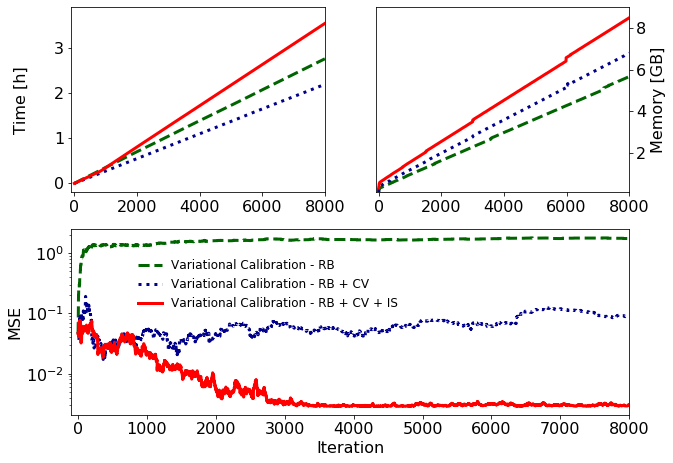

In [140]:
fig = plt.figure(figsize = (10,7.5))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)
#fig.tight_layout()
#plt.subplots_adjust(hspace = 0.001)
plt.rcParams.update({'font.size': 16})

lw = 3
#fig.tight_layout()
ax3.plot(MSE_array_nv, label = "Variational Calibration - RB", color = "darkgreen", lw = lw, ls = '--')
ax3.plot(MSE_array_no, label = "Variational Calibration - RB + CV", color = "darkblue", lw = lw, ls = 'dotted')
ax3.plot(MSE_array_full, label = "Variational Calibration - RB + CV + IS", color = "red", lw = lw, ls = '-')
ax3.set_xlabel("Iteration")
ax3.set_ylabel("MSE")
ax3.set_yscale('log')
ax3.set_xlim([-100,8000])

ax3.legend(frameon=False, bbox_to_anchor=(0.1,0.9), prop={'size': 12})
ax1.plot(time_steps_nv, label = "Variational Calibration - RB", color = "darkgreen", lw = lw, ls = '--')
ax1.plot(time_steps_no, label = "Variational Calibration - RB + CV", color = "darkblue", lw = lw, ls = 'dotted')
ax1.plot(time_steps_full, label = "Variational Calibration - RB + CV + IS", color = "red", lw = lw, ls = '-')
ax1.set_ylabel("Time [h]", labelpad=25)
#axes[0,0].set_xticklabels(())
#axes[0,0].legend(frameon=False, bbox_to_anchor=(0.58,0.47), prop={'size': 14})
#plt.yscale('log')
ax1.set_xlim([-100,8000])
ax1.set_ylim([-0.2,3.9])
ax2.plot((df_nv_mem[index_nv_match]) / 1024, label = "Variational Calibration - RB", color = "darkgreen", lw = lw, ls = '--')
ax2.plot((df_cv_mem[index_cv_match] + 100) / 1024 , label = "Variational Calibration - RB + CV", color = "darkblue", lw = lw, ls = 'dotted')
ax2.plot((df_od_mem[index_od_match] + 300) / 1024, label = "Variational Calibration - RB + CV + IS", color = "red", lw = lw, ls = '-')
ax2.set_ylabel("Memory [GB]", labelpad=5)
#axes[2].set_yscale('log')
ax2.set_xlim([-100,8000])
#axes[0,1].set_xlabel("Iteration #")
ax2.set_ylim([0.1,9])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

#plt.savefig("MSE_simulation_variance_time_mem_together_v2" + '.pdf', dpi=300)
plt.show()

# Application - LDM

In [241]:
##### This is a utility function for LS fit of Liquid drop model
def LDM_input_matrix(BE_data_train):
    """Computes design matrix for Least Squares estimate of LDM parameters according to the parameterization
       described in Kejzlar and Maiti (2020)
       
       NOTE: a_surf, a_sym, a_c are here with an oppiste sign, this is handled during the fit
       to get proper parametrization
    
    Args:
        BE_data_train: Pandas DataFrame of AME2003 binding energies that are preprocessed below
    Return:
        X: Traditional design matrix for linear regression models
    """
    # Precalc of A
    A = (BE_data_train["Z"] + BE_data_train["N"]).values
    # a_vol term
    X = A[:, None]
    # a_surf term
    X = np.concatenate([X,  A[:, None] ** (2/ 3)], axis = 1)
    # a_sym term
    X = np.concatenate([X, ((BE_data_train["N"] - BE_data_train["Z"]).values[:, None] ** 2) / (A[:, None])],
                       axis = 1)
    # a_C term
    
    X = np.concatenate([X, ((BE_data_train["Z"]).values[:, None] * ((BE_data_train["Z"]).values[:, None] - 1)) / (A[:, None] ** (1 / 3))],
                       axis = 1)
    return X

In [242]:
##### Preprocessing the AME2003 dataset
np.random.seed(0)
tf.random.set_seed(0)
df = pd.read_fwf('mass.mas03', usecols=(2,3,4,11),
              names=('N', 'Z', 'A', 'avEbind'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the avEbind column won't be numeric. Coerce to float and drop these entries.
df['avEbind'] = pd.to_numeric(df['avEbind'], errors='coerce')
df = df.dropna()
# Also convert from keV to MeV.
df['BE_per_A'] = df['avEbind'] / 1000
df['AME2003'] = df['BE_per_A'] * df['A']
BE_data_train = df[['Z', 'N', 'AME2003', 'BE_per_A']]
BE_data_train = BE_data_train.drop(0)
BE_data_test = BE_data_train.sample(n = 226)
BE_data_train = pd.concat([BE_data_train, BE_data_test]).drop_duplicates(keep=False)
print("n_test: " + str(len(BE_data_test)))
print("n_train: " + str(len(BE_data_train)))
X = LDM_input_matrix(BE_data_train[['Z', 'N', 'AME2003', 'BE_per_A']])

# Saving the testing and training dataset
BE_data_train.to_pickle("AME2003_train.pkl")
BE_data_test.to_pickle("AME2003_test.pkl")

n_test: 226
n_train: 2000


In [243]:
##### Least squares fit of LDM
X_design = np.matrix(X)
X_design[:,1:] =  - X_design[:,1:] # This is to get correct LDM parametrization
# Parameter estimates
Beta = np.dot(np.dot(np.linalg.inv(np.dot(X_design.T, X_design)), X_design.T), np.matrix(BE_data_train.AME2003.values[:,None]))
print("a_vol, a_surf, a_sym, a_C, = " + str(Beta.flatten()))
# Parameter standard error estimates
Sigma_err = np.sqrt(np.sum((np.array(X_design * Beta).flatten() - BE_data_train["AME2003"].values) ** 2) / (X.shape[0] - 4))
sigma = np.linalg.inv(np.dot(X_design.T, X_design))* Sigma_err ** 2
param_std = np.sqrt(np.diag(sigma))
print("standard error of parameters: " + str(np.sqrt(np.diag(sigma))))

a_vol, a_surf, a_sym, a_C, = [[15.41821202 16.91049219 22.46990944  0.69448381]]
standard error of parameters: [0.02735596 0.08551347 0.06900493 0.00194449]


Root MSE with an outlier present: 4.2735450708986065


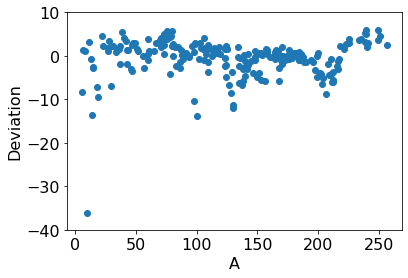

Root MSE without an outlier present: 3.5390648837483596


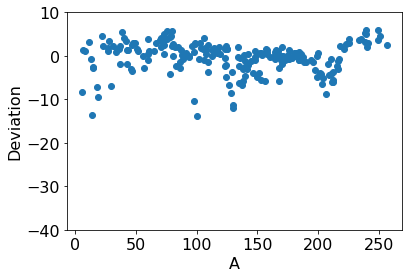

In [244]:
##### Root MSE of the Least Squares fit
X = LDM_input_matrix(BE_data_test[['Z', 'N', 'AME2003', 'BE_per_A']])
X_design = np.matrix(X)
X_design[:,1:] =  - X_design[:,1:]
print("Root MSE with an outlier present: " + str(np.sqrt(np.mean((np.array(X_design * Beta).flatten() - BE_data_test["AME2003"].values) ** 2))))
# It turns out, there is one large outliers in the training dataset
plt.scatter(BE_data_test["Z"] + BE_data_test["N"], np.array(X_design * Beta).flatten() - BE_data_test["AME2003"].values)
plt.ylabel("Deviation")
plt.xlabel("A")
plt.ylim([-40,10])
plt.show()
# To mitigate the leverage of this nucleus, we remove it from the testing dataset
ind = np.abs(np.array(X_design * Beta).flatten() - BE_data_test["AME2003"].values) <20 # This removes the nucleus
print("Root MSE without an outlier present: " + str(np.sqrt(np.mean((np.array(X_design * Beta).flatten()[ind] - BE_data_test["AME2003"].values[ind]) ** 2))))
# It turns out, there is one large outliers in the training dataset
plt.scatter(BE_data_test["Z"][ind] + BE_data_test["N"][ind], np.array(X_design * Beta).flatten()[ind] - BE_data_test["AME2003"].values[ind])
plt.ylabel("Deviation")
plt.xlabel("A")
plt.ylim([-40,10])
plt.show()

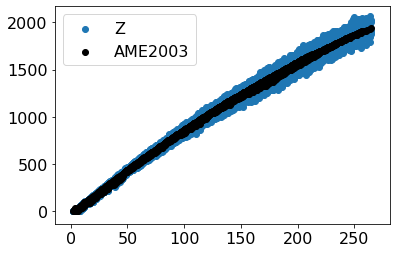

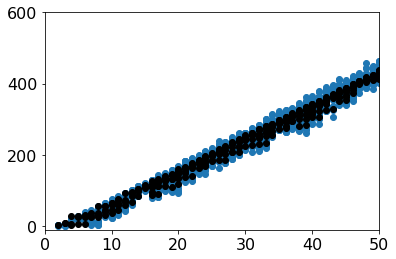

In [245]:
#### Generating model runs for LDM
np.random.seed(0)
tf.random.set_seed(0)
n_m = 10000
n_obs = len(BE_data_train)
lims = np.concatenate([np.array((- param_std * 15 +  Beta.flatten()).T), np.array((param_std * 15 +  Beta.flatten()).T)], axis = 1)
input_m_theta = input_locations(4, n_m, lims=lims, criterion = "c")
input_Z_N = BE_data_train[["Z", "N"]].values.astype(float)
input_Z_N = np.repeat(input_Z_N, repeats=5, axis=0)
np.random.shuffle(input_Z_N)
input_obs = BE_data_train[["Z","N"]].values.astype(float)

# Plot of the model runs
X = LDM_input_matrix(pd.DataFrame(input_Z_N, columns=["Z", "N"]))
X[:,1:] =  - X[:,1:]
Z = np.sum(X * input_m_theta, axis = 1)
index = Z > 0 # We need to remove values that give non-physical Binding energies
Z = Z[index]
n_m = len(Z)
input_Z_N = input_Z_N[index,:]
input_m_theta = input_m_theta[index, :]
input_m = np.concatenate([input_Z_N, input_m_theta], axis = 1)
plt.scatter(np.sum(input_Z_N, axis = 1), Z, label = "Z")
plt.scatter(BE_data_train["Z"] + BE_data_train["N"], BE_data_train["AME2003"], color = 'k', label = "AME2003")
plt.legend()
plt.show()
plt.scatter(np.sum(input_Z_N, axis = 1), Z)
plt.scatter(BE_data_train["Z"] + BE_data_train["N"], BE_data_train["AME2003"], color = 'k')
plt.xlim([0,50])
plt.ylim([-10,600])
plt.show()

In [246]:
#### Preprocessing data for VC_calibration_hyper function
d_input = 2
theta_dim = 4
Y = BE_data_train["AME2003"].values[:,None]
Z = Z[:, None]
Y_index = np.array([i + 1 for i in range(len(Y))])[:,None]
Z_index = np.array([i + 1 + len(Y) for i in range(len(Z))])[:,None]

# Response conc index
Y_input = np.concatenate((Y_index, np.array([1] * len(Y))[:,None], Y), axis = 1)
Z_input = np.concatenate((Z_index, np.array([0] * len(Z))[:, None], Z), axis = 1)
Response_input = np.concatenate((Y_input, Z_input), axis = 0)

# Input values X
Y_X = np.concatenate((Y_index, input_obs), axis = 1)
Z_X = np.concatenate((Z_index, input_m[:,:d_input]), axis = 1)
X_input = np.concatenate((Y_X, Z_X))

# This is purely for initialization
theta_variational = np.array(Beta).flatten() 
theta_variational = np.repeat(theta_variational, len(Y))
theta_variational = theta_variational.reshape((len(Y),theta_dim), order='F')

Y_theta = np.concatenate((Y_index, theta_variational), axis = 1)
Z_theta = np.concatenate((Z_index, input_m[:,d_input:]), axis = 1)
Theta_input = np.concatenate((Y_theta, Z_theta))

# Data input for 
data_input = {"Response": Response_input, "X": X_input, "Theta": Theta_input}

# Bijection
n = n_m + n_obs
    
### Save the data_input dictionary as .pickle file
#with open("AME2003_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'wb') as handle:
#    pkl.dump(data_input, handle, protocol=pkl.HIGHEST_PROTOCOL)
###

### Load the data_input dictionary from .pickle file
#with open("AME2003_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'rb') as handle:
#    data_input = pkl.load(handle)
###

##### Setting up prior distribution, see Kejzlar and Maiti (2020) for more details
priors_dictionary = {}
theta_dim = 4
tf.random.set_seed(123)
np.random.seed(123)
### Theta prior
mean_theta = np.array(Beta).flatten()
cov_theta = param_std * 7.5
dim = theta_dim
theta_prior = gaussian_mean_field_family(param = {"mu": mean_theta, "sigma": cov_theta}, dim = dim)
priors_dictionary["theta"] = theta_prior

### Noise prior
alpha = np.array([2])
beta = np.array([1])
dim = 1
noise_prior = gamma_mean_field_family(param = {"alpha": alpha, "beta": beta}, dim = dim)
priors_dictionary["sigma"] = noise_prior


### Kernel delta hyperparameters priors
## length scales
alpha = np.array([10, 10])
beta = np.array([1, 1])
dim = 2
kernel_delta_l_prior = gamma_mean_field_family(param = {"alpha": alpha, "beta": beta}, dim = dim)
priors_dictionary["kernel_delta_l"] = kernel_delta_l_prior

## eta
alpha = np.array([10])
beta = np.array([1])
dim = 1
kernel_delta_eta_prior = gamma_mean_field_family(param = {"alpha": alpha, "beta": beta}, dim = dim)
priors_dictionary["kernel_delta_eta"] = kernel_delta_eta_prior

### Kernel f hyperparameters priors
## length scales
alpha = np.array([10, 10, 10, 10, 10, 10])
beta = np.array([1, 1, 1, 1, 1, 1])
dim = 6
kernel_f_l_prior = gamma_mean_field_family(param = {"alpha": alpha, "beta": beta}, dim = dim)
priors_dictionary["kernel_f_l"] = kernel_f_l_prior

## eta
alpha = np.array([110])
beta = np.array([10])
dim = 1
kernel_f_eta_prior = gamma_mean_field_family(param = {"alpha": alpha, "beta": beta}, dim = dim)
priors_dictionary["kernel_f_eta"] = kernel_f_eta_prior

#### Kernels definition
kernels = {"f": "sq_quad", "delta": "sq_quad"}

### Mean f hyperparameters
dim = 1
f_beta = 1
mean_beta = np.array([0])
cov_beta = np.array([10])
dim = 1

##### Means definition
model_hyperparameters = {"Beta": float(f_beta)}
delta_hyperparameters = {"Beta": float(f_beta)}
#delta_hyperparameters = {}

f_mean_init = model_mean(model_hyperparameters)
delta_mean_init = delta_mean(delta_hyperparameters)
means = {"f": f_mean_init.zero, "delta": delta_mean_init.zero}

#### Initialization of variational family and overdispersed family to a sample from prior distribution
tf.random.set_seed(1)
np.random.seed(1)
init_summary = pd.read_json('./LDM' + '_init.json') # this loads a sample from prior distribution
init_summary = init_summary.rename(index= {'beta': 'mean_delta', 'a_vol': 'theta_1',
                                           'a_surf': 'theta_2', "a_sym": 'theta_3',
                                           'a_C': "theta_4", 'ls__0': 'kernel_delta_l_1',
                                           'ls__1': 'kernel_delta_l_2', 'eta': 'kernel_delta_eta', 'sigma': 'sigma'})
init_summary = init_summary[["mean", "sd"]]
init_summary.sort_index(inplace=True)
# kernels
kernel_f_l_std = priors_dictionary["kernel_f_l"].sample(5000).std(axis = 0)
kernel_f_l_m = priors_dictionary["kernel_f_l"].sample(1)
kernel_delta_l_std = priors_dictionary["kernel_delta_l"].sample(5000).std(axis = 0)
kernel_delta_l_m = priors_dictionary["kernel_delta_l"].sample(1)

kernel_f_eta_std = priors_dictionary["kernel_f_eta"].sample(5000).std(axis = 0)
kernel_f_eta_m = priors_dictionary["kernel_f_eta"].sample(1)
kernel_delta_eta_std = priors_dictionary["kernel_delta_eta"].sample(5000).std(axis = 0)
kernel_delta_eta_m = priors_dictionary["kernel_delta_eta"].sample(1)

init_summary.loc["kernel_f_l_1"] = [kernel_f_l_m[0,0], kernel_f_l_std[0]]
init_summary.loc["kernel_f_l_2"] = [kernel_f_l_m[0,1], kernel_f_l_std[1]]
init_summary.loc["kernel_f_l_3"] = [kernel_f_l_m[0,2], kernel_f_l_std[2]]
init_summary.loc["kernel_f_l_4"] = [kernel_f_l_m[0,3], kernel_f_l_std[3]]
init_summary.loc["kernel_f_l_5"] = [kernel_f_l_m[0,4], kernel_f_l_std[4]]
init_summary.loc["kernel_f_l_6"] = [kernel_f_l_m[0,5], kernel_f_l_std[5]]
init_summary.loc["kernel_f_eta"] = [kernel_f_eta_m[0,0], kernel_f_eta_std[0]]

init_summary.loc["kernel_delta_l_1"] = [kernel_delta_l_m[0,0], kernel_delta_l_std[0]]
init_summary.loc["kernel_delta_l_2"] = [kernel_delta_l_m[0,1], kernel_delta_l_std[1]]
init_summary.loc["kernel_delta_eta"] = [kernel_delta_eta_m[0,0], kernel_delta_eta_std[0]]
# Sigma
sigma_std = priors_dictionary["sigma"].sample(5000).std(axis = 0)
sigma_m = priors_dictionary["sigma"].sample(1)
init_summary.loc["sigma"] = [sigma_m[0,0], sigma_std[0]]

# Calibration parameters
theta_m = priors_dictionary["theta"].sample(1)
init_summary.loc["theta_1"] = [theta_m[0,0], priors_dictionary["theta"].sigma[0]]
init_summary.loc["theta_2"] = [theta_m[0,1], priors_dictionary["theta"].sigma[1]]
init_summary.loc["theta_3"] = [theta_m[0,2], priors_dictionary["theta"].sigma[2]]
init_summary.loc["theta_4"] = [theta_m[0,3], priors_dictionary["theta"].sigma[3]]


### Overdispersed and variational dictionaries
variational_dictionary = {}
overdispersed_dictionary = {}
param_a = 1.0
### Theta prior
mean_theta = np.array(Beta).flatten()
cov_theta = param_std * 7.5
dim = theta_dim
theta_var = gaussian_mean_field_family_lambda_param(param = {"mu": mean_theta, "sigma": cov_theta, "a": param_a}, dim = dim)
variational_dictionary["theta"] = theta_var

tau_theta = np.array([1, 1, 1, 1])
theta_var_od = gaussian_mean_field_family_lambda_param_overdisp(param = {"mu": mean_theta, "sigma": cov_theta, "a": param_a}, tau=tau_theta, dim = dim)
overdispersed_dictionary["theta"] = theta_var_od

### Noise prior
alpha = np.array([2])
beta = np.array([0.5])
dim = 1
noise_var = gamma_mean_field_family_lambda_param(param = {"alpha": alpha, "beta": beta, "a": param_a}, dim = dim)
variational_dictionary["sigma"] = noise_var

tau = np.array([1])
noise_var_od = gamma_mean_field_family_lambda_param_overdisp(param = {"alpha": alpha, "beta": beta, "a": param_a}, tau=tau, dim = dim)
overdispersed_dictionary["sigma"] = noise_var_od

### Kernel delta hyperparameters priors
## length scales
alpha = np.array([2,2])
beta = np.array([0.5, 0.5])
dim = 2
kernel_delta_l_var = gamma_mean_field_family_lambda_param(param = {"alpha": alpha, "beta": beta, "a": param_a}, dim = dim)
variational_dictionary["kernel_delta_l"] = kernel_delta_l_var

tau = np.array([1,1])
kernel_delta_l_var_od = gamma_mean_field_family_lambda_param_overdisp(param = {"alpha": alpha, "beta": beta, "a": param_a}, tau=tau, dim = dim)
overdispersed_dictionary["kernel_delta_l"] = kernel_delta_l_var_od


## length scales
alpha = np.array([2,2,2,2,2,2])
beta = np.array([1,1,1,1,1,1])
dim = 6
kernel_f_l_var = gamma_mean_field_family_lambda_param(param = {"alpha": alpha, "beta": beta, "a": param_a}, dim = dim)
variational_dictionary["kernel_f_l"] = kernel_f_l_var

tau = np.array([1,1,1,1,1,1])
kernel_f_l_var_od = gamma_mean_field_family_lambda_param_overdisp(param = {"alpha": alpha, "beta": beta, "a": param_a}, tau=tau, dim = dim)
overdispersed_dictionary["kernel_f_l"] = kernel_f_l_var_od

## eta
alpha = np.array([2])
beta = np.array([0.5])
dim = 1
kernel_delta_eta_var = gamma_mean_field_family_lambda_param(param = {"alpha": alpha, "beta": beta, "a": param_a}, dim = dim)
variational_dictionary["kernel_delta_eta"] = kernel_delta_eta_var

tau = np.array([1])
kernel_delta_eta_var_od = gamma_mean_field_family_lambda_param_overdisp(param = {"alpha": alpha, "beta": beta, "a": param_a}, tau=tau, dim = dim)
overdispersed_dictionary["kernel_delta_eta"] = kernel_delta_eta_var_od

# Direct parametrization throught mean and standard deviation due to the scales involved
alpha = np.array([2])
beta = np.array([0.5])
dim = 1
kernel_f_eta_var = gamma_mean_field_family_ms(param = {"alpha": alpha, "beta": beta, "a": param_a}, dim = dim)
variational_dictionary["kernel_f_eta"] = kernel_f_eta_var

tau = np.array([1])
kernel_f_eta_var_od = gamma_mean_field_family_ms_overdisp(param = {"alpha": alpha, "beta": beta, "a": param_a}, tau=tau, dim = dim)
overdispersed_dictionary["kernel_f_eta"] = kernel_f_eta_var_od

if "mean_delta" in priors_dictionary:
    mean_beta = np.array([0])
    cov_beta = np.array([5])
    dim = 1
    mean_delta_var = gaussian_mean_field_family_lambda_param(param = {"mu": mean_beta, "sigma": cov_beta, "a": param_a}, dim = dim)
    variational_dictionary["mean_delta"] = mean_delta_var

    tau = np.array([1])
    mean_delta_var_od = gaussian_mean_field_family_lambda_param_overdisp(param = {"mu": mean_beta, "sigma": cov_beta, "a": param_a}, tau = tau, dim = dim)
    overdispersed_dictionary["mean_delta"] = mean_delta_var_od

In [247]:
##### This chunk carries out the VC_calibration_hyper versions of Variational calibration
# The preset of tuning parameters is according to the Application - calibration simulation 
# in Kejzlar and Maiti (2020)
np.random.seed(2)
tf.random.set_seed(2)
vine_type = "D" # Vine choice
l = 3 # Truncation level choice
variational_dictionary, overdispersed_dictionary = init_variational_dictionary_LDM(init_summary, variational_dictionary, overdispersed_dictionary)
# Dimensions
x_dim = 2
theta_dim = 4
# SGA setup
n_steps = 20
S = 50
S_CV = 10
learning_rate = "AdaGrad"
# Innitial step size
eta = 0.05
eta = np.repeat(eta,30)
#kernel_delta_eta multiplier is larger due to scales involved
eta[[22,23]] = 10

decay = 0.2
# Folder to save
folder = str(n) + "_S_" + str(S) + "_l_" + str(l) + "_vine_" + vine_type + "_learning_" + learning_rate + \
        "_eta_" + str(eta[0]) + "_decay_" + str(decay)

time_counter, var_lambda_array, overdispersed_tau_array = VC_calibration_hyper_RB_CV_OD(data_input, Y_index, Z_index, input_m, kernels,
                                                      means, vine_type, priors_dictionary, variational_dictionary, overdispersed_dictionary,
                                                      x_dim, theta_dim, n_steps,
                                                      S, S_CV, l, folder, learning_rate = learning_rate, alpha_tau = 0.01,
                                                      n_core = 1, eta = eta, decay = decay)







SGA optimization:   0%|                                                                         | 0/20 [00:00<?, ?it/s]





SGA optimization:   5%|███▎                                                             | 1/20 [00:02<00:44,  2.34s/it]





SGA optimization:  10%|██████▌                                                          | 2/20 [00:04<00:42,  2.37s/it]





SGA optimization:  15%|█████████▊                                                       | 3/20 [00:07<00:40,  2.37s/it]





SGA optimization:  20%|█████████████                                                    | 4/20 [00:09<00:38,  2.42s/it]





SGA optimization:  25%|████████████████▎                                                | 5/20 [00:12<00:36,  2.41s/it]





SGA optimization:  30%|███████████████████▌                                             | 6/20 [00:14<00:34,  2.44s/it]





SGA optimization:  35%|██████████████████████▊                                          | 7/20 [00:17<00:33,  2.55s/it]

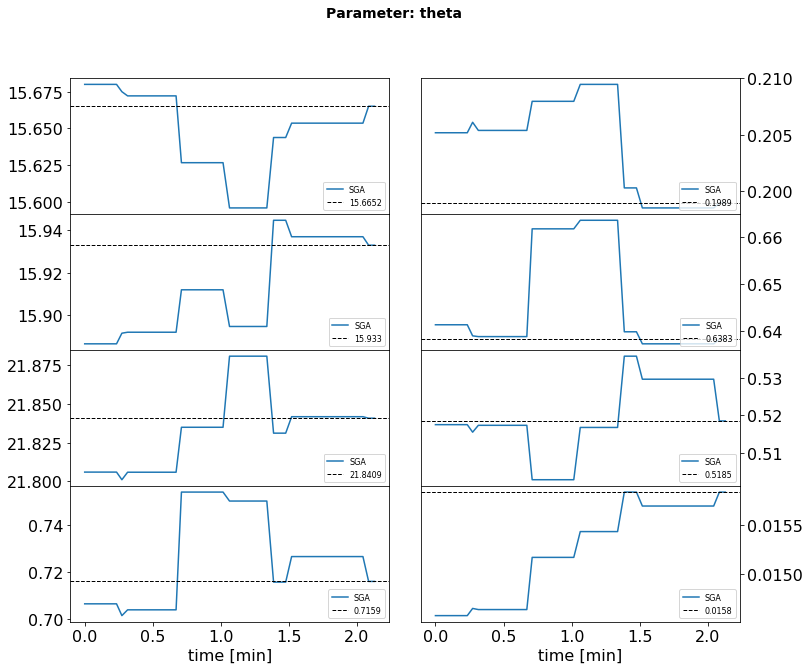

In [222]:
variational_approximation_plot_param(var_lambda_array, param_a = 1, parameter = "theta", time_steps= time_counter, cutoff = len(var_lambda_array))

## Predictions

In [252]:
# Setting for sampling from the posterior predictive distribution
n_obs = int(np.sum(data_input["Response"][:,1]))
n_m = int(len(data_input["Response"])) - n_obs
input_obs = data_input['X'][:n_obs,1:]
input_m = np.concatenate([data_input['X'][n_obs:,1:], data_input['Theta'][n_obs:,1:]], axis = 1)
input_new = BE_data_test[["Z", "N"]].values.astype(float)
Y_Z = data_input["Response"][:,-1]
Y_new = BE_data_test["AME2003"].values.astype(float)
d_input = 2
n_pred = len(Y_new)
n_sample = 2

folder = "LDM_predictions"

np.random.seed(0)
tf.random.set_seed(0)
MSE_array, y_new_array, pred_mean_array, pd_status_array, pd_diff_array = post_pred_vc_LDM("pred_" + folder, variational_dictionary, var_lambda_array,
                      input_obs, input_m, input_new, Y_Z, Y_new,
                      d_input, n_pred, n_sample)
y_new_array = np.array(y_new_array)
pd_status_array = np.array(pd_status_array)







  0%|                                                                                            | 0/2 [00:00<?, ?it/s]





 50%|██████████████████████████████████████████                                          | 1/2 [00:38<00:38, 38.97s/it]





100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:19<00:00, 39.88s/it]


In [335]:
##### Loading precomputed results
folder = "LDM_results/pred_11970_S_50_l_3_vine_D_learning_AdaGrad_eta_0.05_decay_0.2_eta_10"
MSE_array = np.load(folder + "/" + "mse" +".npy")
y_new_array = np.load(folder + "/" + "y_new" +".npy")
pred_mean_array  = np.load(folder + "/" + "pred_mean" +".npy")
pd_status_array = np.load(folder + "/" + "pd" +".npy")
pd_diff_array = np.load(folder + "/" + "diff" +".npy")

root MSE: 1.5236520156722122
MSE: 2.321515464861995


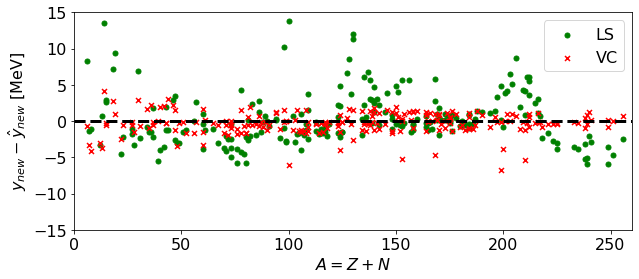

In [341]:
#### Removing outliers from the posterior samples that occur due to numerical instabilities
# Outliers are considered those samples that are Larger than q3 + IQR_factor * IQR or smaller than 
# q3 - IQR_factor * IQR
IQR_factor = 3 #
q3 = np.quantile(y_new_array, 0.75, axis = 0)
q1 = np.quantile(y_new_array, 0.25, axis = 0)
IQR = q3 - q1
ub = q3 + IQR_factor * IQR
lb = q1 - IQR_factor * IQR
t_array = []

# Outliers removal
for i in range(y_new_array.shape[1]):
    #t_array = t_array & ((y_new_array[:,i] <= ub[i]) & (y_new_array[:,i] >= lb[i]))
    t_array = t_array + [((y_new_array[:,i] <= ub[i]) & (y_new_array[:,i] >= lb[i]))]
t_array = np.array(t_array).T

# Mean_calc
mean_array = []
for i in range(y_new_array.shape[1]):
    mean_array = mean_array + [np.mean(np.array(y_new_array[:,i])[t_array[:,i]])]
mean_array = np.array(mean_array)

print("root MSE: " + str(np.sqrt(np.mean((mean_array[ind] - Y_new.flatten()[ind]) ** 2))))
print("MSE: " + str(np.mean((mean_array[ind] - Y_new.flatten()[ind]) ** 2)))

#### Calculate quantiles for equal-tail credible itervals
top_q = 0.95
top_array = []
for i in range(y_new_array.shape[1]):
    top_array = top_array + [np.quantile(np.array(y_new_array[:,i])[t_array[:,i]], top_q)]
top_array = np.array(top_array)
low_q = 0.05
low_array = []
for i in range(y_new_array.shape[1]):
    low_array = low_array + [np.quantile(np.array(y_new_array[:,i])[t_array[:,i]], low_q)]
low_array = np.array(low_array)
#### END Calculate quantiles for equal-tail credible itervals

plt.figure(figsize=(10,4))
lw = 3
s = 25
top = np.abs(mean_array - top_array)
low = np.abs(mean_array - low_array) 
X = LDM_input_matrix(BE_data_test[['Z', 'N', 'AME2003', 'BE_per_A']])
X_design = np.matrix(X)
X_design[:,1:] =  - X_design[:,1:]
ind = np.abs(np.array(X_design * Beta).flatten() - BE_data_test["AME2003"].values) < 20
x = (BE_data_test["Z"] + BE_data_test["N"]).values
plt.scatter(x[ind], Y_new.flatten()[ind] - np.array(X_design * Beta).flatten()[ind], s = s, marker = "o", color = "green", label = "LS")
#plt.scatter(x[ind], Y_new.flatten()[ind] - np.mean(np.array(y_new_array)[t_array,:], axis = 0)[ind])
plt.scatter(x[ind], Y_new.flatten()[ind] - mean_array[ind], s =s, marker = "x", color = "red", label = "VC")
#plt.errorbar(x[ind], Y_new.flatten()[ind] - mean_array[ind], yerr = np.concatenate([low[ind,None], top[ind,None]], axis = 1).T, ls = " ", color = "darkorange")
plt.hlines(xmin = 0, xmax = 260, y = 0, ls = "--", lw = lw)
plt.ylim([-15, 15])
plt.xlim([0,260])
plt.xlabel(r'$A = Z + N$')
plt.ylabel(r'$y_{new} - \hat{y}_{new}$ [MeV]')
plt.legend()
#plt.savefig('LDM_deviation.pdf',dpi=300,bbox_inches='tight')
plt.show()